# TL;DR

The goal of this notebook is to visualize COVID-19 infections using data from https://github.com/CSSEGISandData/COVID-19.

Most illustrative plots of how the pandemic is being controlled:
- [Relative increases per day by country](#country_relative_increases)
- [Relative increases per day by state](#us_state_relative_increases)

Visualizations found in this notebook:
- Countries
    - [Top 20 countries by cumulative confirmed COVID-19 cases](#top_countries_confirmed)
    - [Top 10 countries by NEW confirmed COVID-19 cases](#top_countries_confirmed_new)
    - [Time-series plots of infections in most infected countries](#time-series_countries)
    - [Forecasts of infections/deaths 1 and 7 days in the future](#forecasts_countries)
    - [Relative increases per day by country](#country_relative_increases)
    - [Time-series plots of mortality](#time-series_country_mortality)
    - [Mortality as currently measured, compared to expected based on WHO mortality expectations](#counry_mortality_expectations)
      - [Source of expectations](http://weekly.chinacdc.cn/en/article/id/e53946e2-c6c4-41e9-9a9b-fea8db1a8f51)
    - [Density of infections per million people](#density_of_infections_by_country)
    - [How many days behind is each country from Italy?](#days_behind)
- US states
    - [US states with the most new infections](#states_most_infections)
    - [Time-series plots of infections in most-infected states](#time-series_states)
    - [State forecasts of infections/deaths 1 and 7 days in the future](#forecast_us_state)
    - [States and their daily increase fraction in confirmed cases/deaths](#us_state_daily_increase_fraction)
    - [Compare US state infections against Washington](#state_infections_vs_wa)
    - [Compare US state infections against New York](#state_infections_vs_ny)
    - [Mortality rate by US state](#mortality_by_us_state)
    - [Relative increases per day by state](#us_state_relative_increases)
    - [When will each US state hit 1 case?](#us_state_0_new)
    - [Smoothed trend for each US state](#us_state_smoothed_trend)

In [1]:


from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



# Imports and definitions

In [2]:
import pandas as pd
import numpy as np
import os
import datetime
import re
from dateutil import parser
from matplotlib import pyplot as plt
import warnings

plt.rcParams['figure.figsize'] = 12,6
#plt.style.use('seaborn-dark-palette')
plt.style.use('seaborn-darkgrid')
pd.options.display.max_columns = 300

def datetime_to_unixtime(dt):
    return (dt - datetime.datetime(1970, 1, 1)).total_seconds()

# Load data

In [692]:
# define paths to each raw file
d_ts = {}
#d_ts['confirmed'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
#d_ts['deaths'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
d_ts['confirmed'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
d_ts['deaths'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

#d_ts['recovered'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'

# load in each CSV
d_data = {}
for key, file_path in d_ts.items():
    d_data[key] = pd.read_csv(file_path)

# Clean to long form

In [693]:
def clean_wide_to_long(dfp, key):
    # find columns with dates in them
    cols = list(dfp.columns)
    date_cols = [col for col in cols if re.findall('(\d+/\d+/\d+)', col)]  #if '/' in col
    non_date_cols = list(set(cols) - set(date_cols))
    
    # wide to long
    dfp_melt = pd.melt(dfp, id_vars=non_date_cols, value_vars=date_cols)
    dfp_melt = dfp_melt.rename(columns={'variable': 'date', 
                                        'value': key,
                                        'Country/Region': 'country',
                                        'Province/State': 'state',
                                       })
    dfp_melt['date'] = dfp_melt['date'].apply(parser.parse)
    dfp_melt[key] = dfp_melt[key].apply(float)
    return dfp_melt

In [694]:
# convert from wide to long form
d_dfps = {}
dfp = None
merge_cols = ['country', 'state', 'date']
for key, dfp_wide in d_data.items():
    print(f'metric: {key} at {datetime.datetime.now()}')
    d_dfps[key] = clean_wide_to_long(dfp_wide, key)
    
    if dfp is None:
        dfp = d_dfps[key].copy()
    else:
        dfp_temp = d_dfps[key][merge_cols + [key]]
        dfp = dfp.merge(dfp_temp, on=merge_cols, how='left')
        
print(f"Latest data from {dfp['date'].max().strftime('%Y-%m-%d')}")

metric: confirmed at 2020-06-14 22:13:48.359155
metric: deaths at 2020-06-14 22:13:50.214370
Latest data from 2020-06-14


In [695]:
# aggregate by country (the US data is reported by state)
dfp_country = (dfp.groupby(['date', 'country'], as_index=False).
               agg({
                   'confirmed': np.sum,
                   'deaths': np.sum,
                   #'recovered': np.sum,
               }))
#dfp_country['active'] = dfp_country['confirmed'] - dfp_country['recovered']
dfp_country['confirmed_lag1'] = dfp_country.groupby(['country'])['confirmed'].shift(1)
dfp_country['confirmed_new'] = dfp_country['confirmed'] - dfp_country['confirmed_lag1']
dfp_country['deaths_lag1'] = dfp_country.groupby(['country'])['deaths'].shift(1)
dfp_country['deaths_new'] = dfp_country['deaths'] - dfp_country['deaths_lag1']
dfp_country['mortality_rate'] = dfp_country['deaths'] / dfp_country['confirmed']

<a id='top_countries_confirmed'></a>
##### Top 20 countries by cumulative confirmed COVID-19 cases

In [696]:
# get the top countries
id_cols = ['date', 'country']
value_cols = [
    'confirmed',
    'confirmed_new',
    'deaths',
    'deaths_new',
    #'active',
    'mortality_rate',
]
dfp_top_countries = dfp_country[dfp_country['date'] == dfp_country['date'].max()][id_cols + value_cols]
dfp_top_countries = dfp_top_countries.sort_values(by='deaths', ascending=0).reset_index(drop=True)
for key in value_cols:
    if 'rate' in key:
        continue
    dfp_top_countries[key] = dfp_top_countries[key].apply(int)
dfp_top_countries.head(20)

date         country  confirmed  confirmed_new  deaths  deaths_new  \
0  2020-06-14              US    2094058          19532  115732         296   
1  2020-06-14          Brazil     867624          17110   43332         612   
2  2020-06-14  United Kingdom     297342           1514   41783          36   
3  2020-06-14           Italy     236989            338   34345          44   
4  2020-06-14          France     194153            407   29410           9   
5  2020-06-14           Spain     243928            323   27136           0   
6  2020-06-14          Mexico     146837           4147   17141         269   
7  2020-06-14         Belgium      60029            111    9655           5   
8  2020-06-14           India     320922          11929    9195         311   
9  2020-06-14            Iran     187427           2472    8837         107   
10 2020-06-14         Germany     187518            251    8801           8   
11 2020-06-14          Canada     100404            361    8218          35   
12 2020-06-14          Russia     528267           8809    6938         119   
13 2020-06-14            Peru     229736           8987    6688         380   
14 2020-06-14     Netherlands      48990            143    6078           2   
15 2020-06-14          Sweden      51614            683    4874           0   
16 2020-06-14          Turkey     178239           1562    4807          15   
17 2020-06-14           China      84335             49    4638           0   
18 2020-06-14         Ecuador      46751            395    3896          22   
19 2020-06-14           Chile     174293           6938    3323         222   

    mortality_rate  
0         0.055267  
1         0.049943  
2         0.140522  
3         0.144922  
4         0.151478  
5         0.111246  
6         0.116735  
7         0.160839  
8         0.028652  
9         0.047149  
10        0.046934  
11        0.081849  
12        0.013134  
13        0.029112  
14        0.124066  
15        0.094432  
16        0.026969  
17        0.054995  
18        0.083335  
19        0.019066

<a id='top_countries_confirmed_new'></a>
##### Top 10 countries by NEW confirmed COVID-19 cases

In [697]:
dfp_top_countries.sort_values(by='confirmed_new', ascending=0).head(10)

date       country  confirmed  confirmed_new  deaths  deaths_new  \
0  2020-06-14            US    2094058          19532  115732         296   
1  2020-06-14        Brazil     867624          17110   43332         612   
20 2020-06-14      Pakistan     144478          12073    2729         178   
8  2020-06-14         India     320922          11929    9195         311   
13 2020-06-14          Peru     229736           8987    6688         380   
12 2020-06-14        Russia     528267           8809    6938         119   
19 2020-06-14         Chile     174293           6938    3323         222   
27 2020-06-14  South Africa      70038           4302    1480          57   
32 2020-06-14  Saudi Arabia     127541           4233     972          40   
6  2020-06-14        Mexico     146837           4147   17141         269   

    mortality_rate  
0         0.055267  
1         0.049943  
20        0.018889  
8         0.028652  
13        0.029112  
12        0.013134  
19        0.019066  
27        0.021131  
32        0.007621  
6         0.116735

<a id='time-series_countries'></a>
# Time-series plots of infections in most infected countries

In [698]:
def plot_countries(
    dfp_country,
    countries=dfp_top_countries.iloc[:10]['country'],
    plot_cols=['confirmed', 'deaths', 'recovered', 'active', 'confirmed_new'],
    country_col='country',
    n_columns=2,
    y_min=1,
    y_max=dfp_top_countries['confirmed'].max() * 1.5,
    date_col='date',
    y_label='num_cases',
    date_min=datetime.datetime(2020,2,1),
    is_log=True,
):
    i = 1
    n_rows = int(np.ceil(len(countries) / n_columns))
    plt.figure(figsize=(12,n_rows*5))
    
    for country in countries:
        dfp_plot = dfp_country[(dfp_country[country_col] == country) &
                               (dfp_country[date_col] >= date_min)
                              ]
        dfp_plot = dfp_plot[dfp_plot['confirmed_new'] != 0]
        plt.subplot(n_rows, n_columns, i)
        for key in plot_cols:
            plt.plot(dfp_plot[date_col], dfp_plot[key], alpha=0.7, label=key)
        plt.legend(loc='best')
        plt.ylabel(f'{y_label}')
        plt.title(f'{country_col}: {country}')
        if is_log:
            plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()

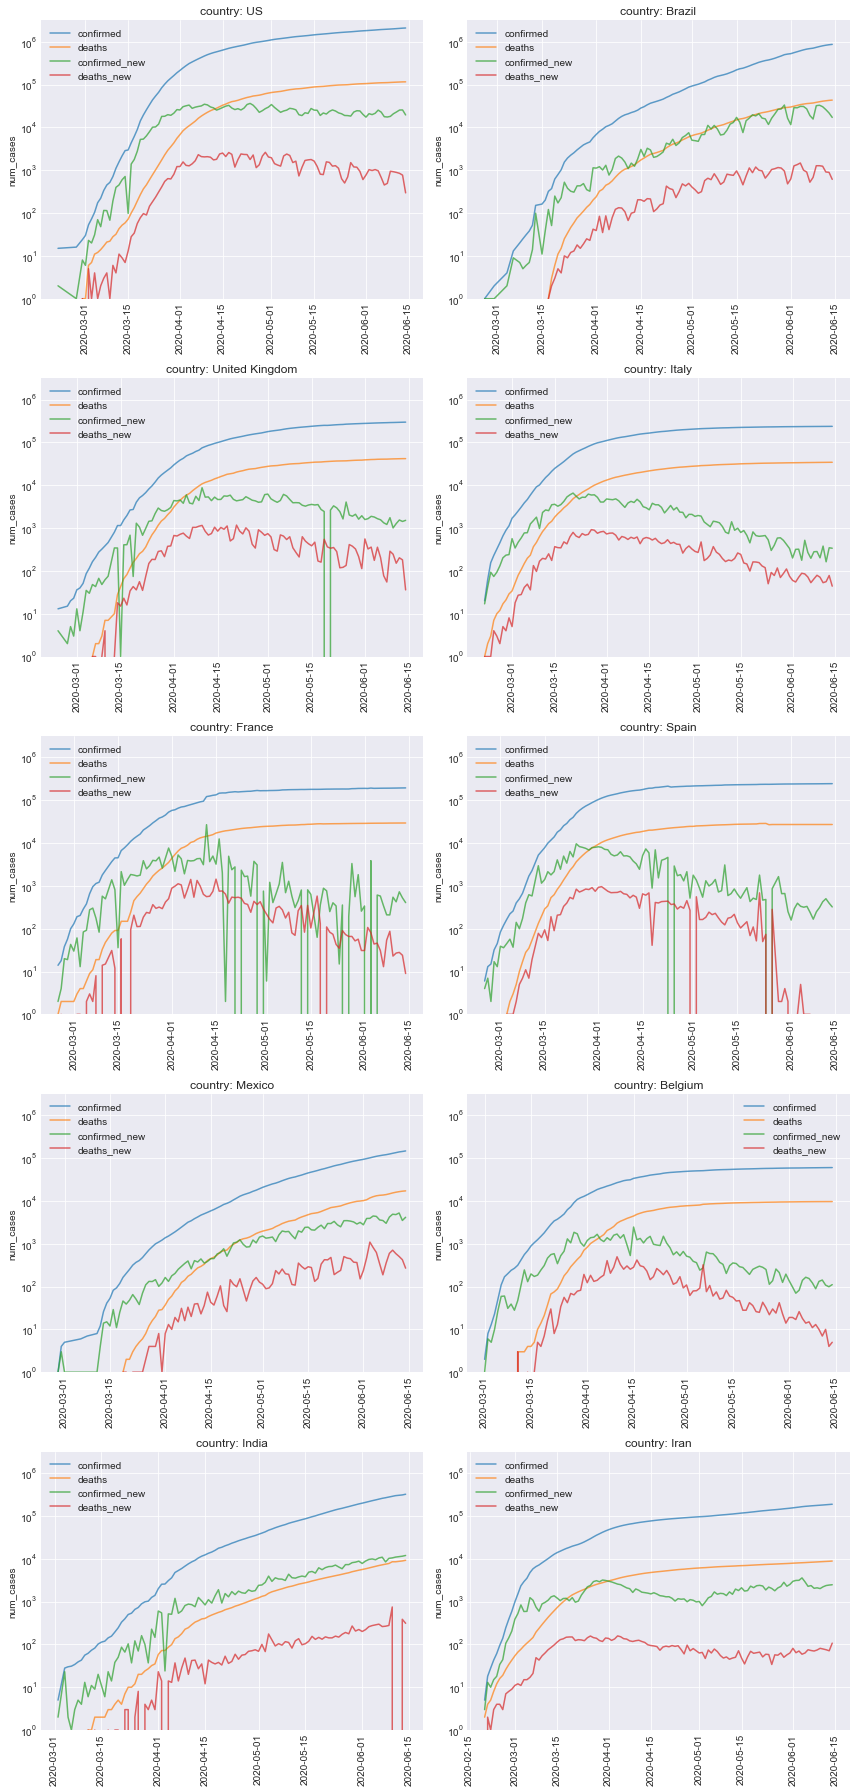

In [699]:
n_countries = 10

plot_countries(dfp_country, 
               countries=dfp_top_countries.iloc[:n_countries]['country'],
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='country',
               date_min=datetime.datetime(2020,2,20),
              )

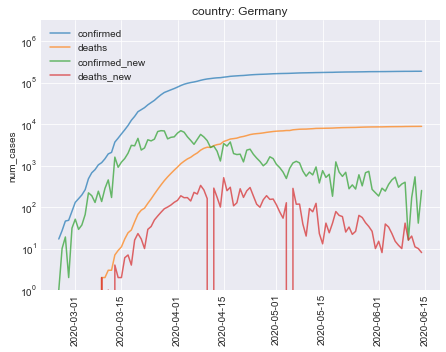

In [700]:
plot_countries(dfp_country, 
               countries=['Germany'],
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='country',
               date_min=datetime.datetime(2020,2,20),
              )

<a id='forecasts_countries'></a>
# Forecasts of infections/deaths 1 and 7 days in the future

For confirmed cases (`confirmed_pred`) and deaths (`deaths_pred`)

In [701]:
def predict_from_fit(row):
    return int(10**(row['slope'] * row['unixtime'] + row['intercept']))

def shift_future(dfp, date_most_recent, days=1, cols_to_be_null_in_future=[]):
    dfp_most_recent = dfp.copy()
    dfp_most_recent['date'] = date_most_recent + datetime.timedelta(days=days)  #dfp_most_recent['date'] + datetime.timedelta(days=days)
    dfp_most_recent['unixtime'] = dfp_most_recent['date'].apply(datetime_to_unixtime)
    #dfp_most_recent['unixtime'] = dfp_most_recent['unixtime'] + 86400 * days
    
    cols_nullable = ['confirmed', 'deaths', 'recovered', 'active', 'confirmed_lag1', 'confirmed_new', 'deaths_new']
    cols_nullable.extend(cols_to_be_null_in_future)
    for col in cols_nullable:
        dfp_most_recent[col] = np.nan
    return dfp_most_recent

def fit_poly1(dfp_country_recent, 
              col_fit='confirmed_log', 
              col_pred='confirmed_pred', 
              date_most_recent=None,
              col_locale='country'
             ):
    warnings.simplefilter('ignore', np.RankWarning)
    if date_most_recent is None:
        date_most_recent = dfp_country_recent['date'].max()
    dfp_country_recent = dfp_country_recent.set_index(col_locale)
    
    # fit
    dfp_country_recent_clean = dfp_country_recent[(dfp_country_recent['date'] <= date_most_recent) &
                                                  (dfp_country_recent[col_fit] > 0)
                                                 ]
    dfp_country_confirmed_fit = (dfp_country_recent[dfp_country_recent['date'] <= date_most_recent].
                                 groupby([col_locale]).
                                 apply(lambda x: np.polyfit(x['unixtime'], x[col_fit], 1))
                                )
    dfp_country_recent['fits'] = dfp_country_confirmed_fit
    dfp_country_recent[['slope', 'intercept']] = dfp_country_recent['fits'].apply(pd.Series)   
    
    dfp_country_recent[col_pred] = dfp_country_recent.apply(predict_from_fit, axis=1)
    dfp_country_recent = dfp_country_recent.drop(columns=['fits', 'intercept']).reset_index() #'slope', 
    fit_col = col_fit.split('_')[0]
    dfp_country_recent[f"frac_increase_{fit_col}"] = (10**(dfp_country_recent['slope'] * 86400) - 1)
    #dfp_country_recent = dfp_country_recent.rename(columns={'slope': f'slope_{col_fit.split("_")[0]}'})
    return dfp_country_recent, dfp_country_confirmed_fit

def fit_exp(dfp_country, 
            n_days_predict=14, 
            n_days_into_future=[1,7],
            col_locale='country', 
            top_countries=None, 
            n_countries=10, 
            date_most_recent=None,
            is_silent=False
           ):
    # make predictions based on the last 2 weeks of data
    if date_most_recent is None:
        date_most_recent = dfp_country['date'].max()
    date_n_days_ago = date_most_recent - datetime.timedelta(days=n_days_predict-1)
    dfp_country_recent = (dfp_country[dfp_country['date'].between(date_n_days_ago, date_most_recent)].
                          sort_values(by=[col_locale, 'date'])
                         ).copy()

    # clean data for fit (convert to log)
    dfp_country_recent['confirmed_log'] = dfp_country_recent['confirmed'].apply(lambda x: np.log10(x) if x > 0 else 0)
    dfp_country_recent['deaths_log'] = dfp_country_recent['deaths'].apply(lambda x: np.log10(x) if x > 0 else 0)
    dfp_country_recent['unixtime'] = dfp_country_recent['date'].apply(datetime_to_unixtime)
    
    
    # make predictions to past, then future
    # add in future points
    dfp_country_recent_max_date = dfp_country_recent.groupby([col_locale], as_index=False).agg({'date': np.max})
    dfp_most_recent = dfp_country_recent.merge(dfp_country_recent_max_date, on=[col_locale, 'date'], how='inner').copy()
    #dfp_most_recent = dfp_country_recent[dfp_country_recent['date'] == date_most_recent].copy()
    list_dfp_recent = [dfp_country_recent]
    for n in n_days_into_future:
        dfp_most_recent_tmp = shift_future(dfp_most_recent, date_most_recent, n)
        list_dfp_recent.append(dfp_most_recent_tmp)
    #dfp_most_recent_7 = shift_future(dfp_most_recent, 7)
    #dfp_country_recent = pd.concat([dfp_country_recent, dfp_most_recent_1, dfp_most_recent_7], axis=0, sort=False)
    dfp_country_recent = pd.concat(list_dfp_recent, axis=0, sort=False)
    dfp_country_recent, dfp_country_deaths_fit = fit_poly1(dfp_country_recent, 
                                                           col_fit='deaths_log', 
                                                           col_pred='deaths_pred', 
                                                           col_locale=col_locale, 
                                                           date_most_recent=date_most_recent
                                                          )
    dfp_country_recent, dfp_country_confirmed_fit = fit_poly1(dfp_country_recent, 
                                                              col_fit='confirmed_log', 
                                                              col_pred='confirmed_pred', 
                                                              col_locale=col_locale, 
                                                              date_most_recent=date_most_recent
                                                             )
    dfp_country_recent['mortality_rate_pred'] = dfp_country_recent['deaths_pred'] / dfp_country_recent['confirmed_pred']

    # look only at the predictions for top countries
    if top_countries is None:
        top_countries = (dfp_most_recent.
                         sort_values(by='deaths', ascending=0).iloc[:n_countries][col_locale].values)
    dfp_forecasts = dfp_country_recent[(dfp_country_recent['date'] > date_most_recent)
                                       
                                      ].sort_values(by=[col_locale, 'date']).reset_index(drop=True)
    dfp_forecasts_out = dfp_forecasts[['date', 
                                       col_locale, 
                                       'confirmed_pred', 
                                       'deaths_pred', 
                                       'mortality_rate_pred', 
                                       'frac_increase_confirmed', 
                                       'frac_increase_deaths'
                                      ]].copy()
    dfp_forecasts_out['date'] = dfp_forecasts_out['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

    # find the daily fractional increase in cases
    dfp_frac_increase = (dfp_forecasts_out.
                         groupby([col_locale]).
                         agg({'frac_increase_confirmed': np.mean, 
                              'frac_increase_deaths': np.mean}))
    dfp_frac_increase.columns = pd.MultiIndex.from_product([dfp_frac_increase.columns, ['']])

    # pivot so each date of prediction has its own column
    dfp_forecasts_print = dfp_forecasts_out.pivot(index=col_locale, 
                                                  columns='date', 
                                                  values=['confirmed_pred', 'deaths_pred', 'mortality_rate_pred']
                                                 ).sort_values(by=('deaths_pred', dfp_forecasts_out['date'].min()), ascending=0)
    dfp_forecasts_print = dfp_forecasts_print.merge(dfp_frac_increase, on=col_locale, how='inner')
    if not is_silent:
        display(dfp_forecasts_print[dfp_forecasts_print.index.isin(top_countries)])
    return dfp_country_recent, dfp_forecasts_out


def plot_forecasts(dfp_country_recent, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='country',
                  ):
    # subset the top countries
    dfp_non_pred = dfp_country_recent.dropna(subset=['deaths'])
    dt_max = dfp_non_pred['date'].max()
    dfp_top_countries = (dfp_non_pred[dfp_non_pred['date'] == dt_max].
                         sort_values(by='deaths', ascending=0).
                         iloc[:n_countries]
                        )
    top_countries = (dfp_top_countries.
                     iloc[:n_countries][col_locale].values
                    )

    # plot the top countries
    i = 1
    n_rows = int(np.ceil(n_countries / n_columns))
    plt.figure(figsize=figsize)
    y_max = dfp_country_recent['confirmed_pred'].max()
    y_min = max(dfp_country_recent['deaths'].min(), 1)

    for country in top_countries:
        dfp_plot = dfp_country_recent[(dfp_country_recent[col_locale] == country) &
                               (dfp_country_recent['date'] >= date_min)
                              ].sort_values(by='date')
        plt.subplot(n_rows, n_columns, i)
        for key in ['confirmed', 'deaths']:
            p = plt.plot(dfp_plot['date'], dfp_plot[key], alpha=0.5, linewidth=2, label=key)
            pred_col = f'{key}_pred'
            plt.plot(dfp_plot['date'], dfp_plot[pred_col], linestyle='--', linewidth=2, alpha=0.5, color=p[0].get_color(), label=pred_col)
        plt.legend(loc='best')
        plt.ylabel('num cases')
        plt.title(f'{col_locale}: {country}')
        plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()
    return None
                       
                       
def save_forecast(dfp_forecasts_out, dfp_country_recent, n_days_training=14):
    date_most_recent = dfp_country_recent.dropna(subset=['deaths'])['date'].max()
    dfp_forecasts_out['date_of_forecast'] = date_most_recent
    save_name = f"covid-19_country_forecast_from_{date_most_recent.strftime('%Y-%m-%d')}_n_days_training={n_days_training}.csv"
    save_path = os.path.join('predictions', save_name)
    dfp_forecasts_out.to_csv(save_path, index=False)
    print(f'saved forecast to {save_path}')
    return None

##### Forecasts based on last 1 week

confirmed_pred                       deaths_pred             \
date               2020-06-15 2020-06-21 2020-07-05  2020-06-15 2020-06-21   
country                                                                      
US                  2118343.0  2265299.0  2649072.0    116931.0   122020.0   
Brazil               910697.0  1119332.0  1811303.0     44963.0    52562.0   
United Kingdom       298648.0   307248.0   328291.0     42083.0    43239.0   
Italy                237222.0   238919.0   242926.0     34418.0    34802.0   
France               194669.0   197749.0   205128.0     29460.0    29644.0   
Spain                244325.0   246673.0   252242.0     27135.0    27135.0   
Mexico               152918.0   187585.0   302172.0     18024.0    22080.0   
Belgium               60156.0    60863.0    62546.0      9666.0     9715.0   
India                329543.0   393363.0   594544.0      9523.0    11537.0   
Iran                 189622.0   204454.0   243730.0      8906.0     9413.0   

                          mortality_rate_pred                        \
date           2020-07-05          2020-06-15 2020-06-21 2020-07-05   
country                                                               
US               134774.0            0.055199   0.053865   0.050876   
Brazil            75668.0            0.049372   0.046958   0.041775   
United Kingdom    46061.0            0.140912   0.140730   0.140305   
Italy             35714.0            0.145088   0.145664   0.147016   
France            30079.0            0.151334   0.149907   0.146635   
Spain             27135.0            0.111061   0.110004   0.107575   
Mexico            35455.0            0.117867   0.117707   0.117334   
Belgium            9830.0            0.160682   0.159621   0.157164   
India             18051.0            0.028898   0.029329   0.030361   
Iran              10713.0            0.046967   0.046040   0.043954   

               frac_increase_confirmed frac_increase_deaths  
date                                                         
country                                                      
US                            0.011241         7.126190e-03  
Brazil                        0.034977         2.636664e-02  
United Kingdom                0.004743         4.526657e-03  
Italy                         0.001189         1.850143e-03  
France                        0.002620         1.039471e-03  
Spain                         0.001596        -1.110223e-16  
Mexico                        0.034641         3.440399e-02  
Belgium                       0.001950         8.383224e-04  
India                         0.029944         3.248830e-02  
Iran                          0.012630         9.280287e-03

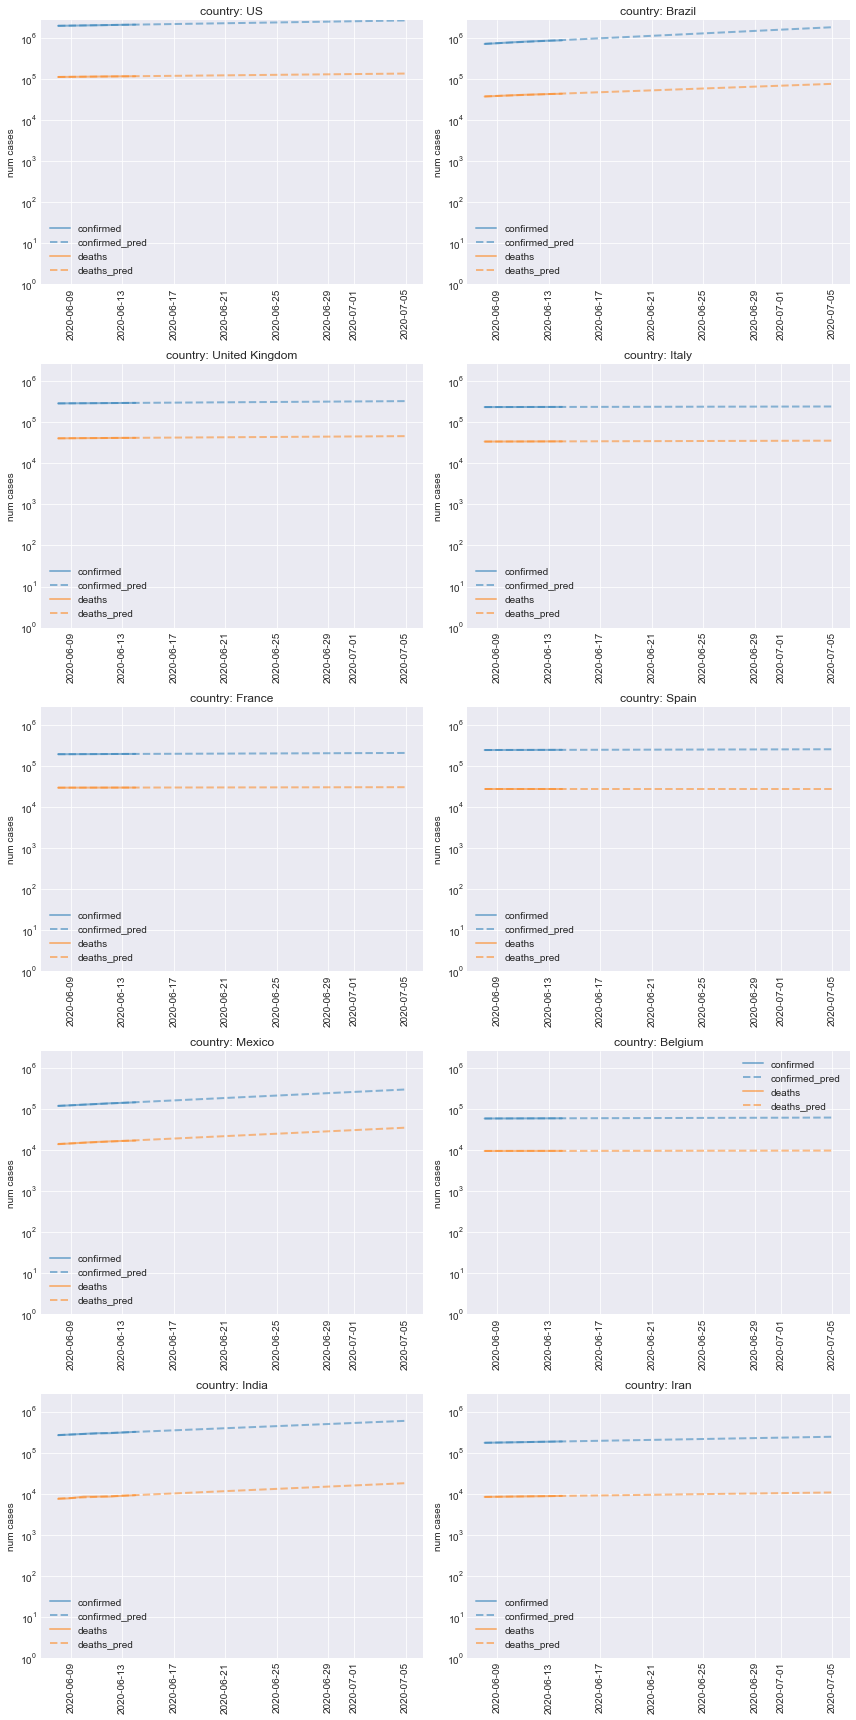

In [702]:
dfp_country_recent_1, dfp_forecasts_out_1 = fit_exp(dfp_country, 
                                                    n_days_predict=7,
                                                    n_days_into_future=[1,7,21], 
                                                    col_locale='country', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_country_recent_1)

In [703]:
save_forecast(dfp_forecasts_out_1, dfp_country_recent_1, 7)

saved forecast to predictions/covid-19_country_forecast_from_2020-06-14_n_days_training=7.csv


<a id='country_relative_increases'></a>
### Relative increases per day by country

In [704]:
def find_relative_increase_data_and_plot(dfp_us_g, 
                                         n_days_fit=7, 
                                         dt=datetime.datetime(2020,3,10),
                                         n_locales=7,
                                         col_locale='state'
                                        ):
    dt_max = dfp_us_g['date'].max()
    list_dfp_state_relative = []
    while dt <= dt_max:
        try:
            dfp_state_recent_tmp, dfp_state_forecasts_out_tmp = fit_exp(dfp_us_g, 
                                                                        n_days_predict=n_days_fit, 
                                                                        col_locale=col_locale, 
                                                                        top_countries=None,
                                                                        date_most_recent=dt,
                                                                        is_silent=True
                                                                       )
            dfp_state_recent_tmp = dfp_state_recent_tmp.dropna(subset=['confirmed'])
            dfp_state_recent_tmp_single = dfp_state_recent_tmp[dfp_state_recent_tmp['date'] == dfp_state_recent_tmp['date'].max()]
            list_dfp_state_relative.append(dfp_state_recent_tmp_single)
        except Exception as e:
            print(f"failed on {dt.strftime('%Y-%m-%d')}")

        dt += datetime.timedelta(days=1)
    dfp_state_relative_chng = pd.concat(list_dfp_state_relative)
                  
    # plot states
    top_states = (dfp_state_relative_chng[(dfp_state_relative_chng['date'] == dfp_state_relative_chng['date'].max())].
                  sort_values(by='deaths', ascending=0).
                  reset_index(drop=True).
                  iloc[:n_locales][col_locale].values
                 )
                  
    # deaths
    plt.subplot(1,2,1)
    for state in top_states:
        dfp_st = dfp_state_relative_chng[(dfp_state_relative_chng[col_locale] == state) & 
                                         (dfp_state_relative_chng['deaths'] > 2)]
        #
        plt.plot(dfp_st['date'], dfp_st['frac_increase_deaths'], label=state, alpha=0.7)
        plt.ylabel('relative increase in deaths')
        plt.xticks(rotation=90)
        plt.legend(loc='best')
        plt.axhline(0, color='k', alpha=0.5)
        plt.title('Relative daily increase in deaths')

    # confirmed cases
    plt.subplot(1,2,2)
    for state in top_states:
        dfp_st = dfp_state_relative_chng[(dfp_state_relative_chng[col_locale] == state) & 
                                         (dfp_state_relative_chng['deaths'] > 2)]
        
        plt.plot(dfp_st['date'], dfp_st['frac_increase_confirmed'], label=state, alpha=0.7)
        plt.ylabel('relative increase in confirmed')
        plt.xticks(rotation=90)
        plt.legend(loc='best')
        plt.axhline(0, color='k', alpha=0.5)
        plt.title('Relative daily increase in confirmed')

    plt.show()
    return None


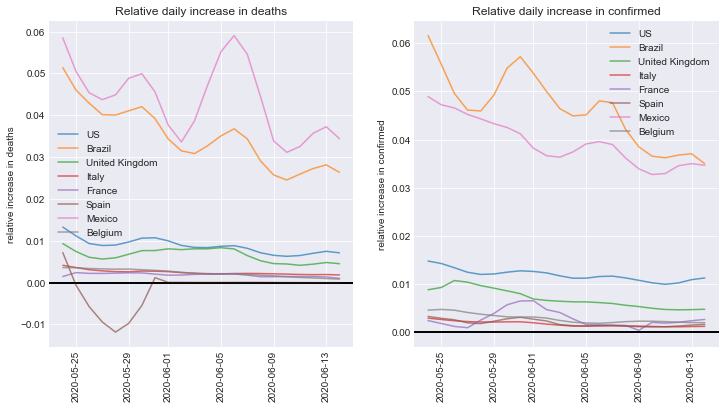

In [705]:
now = datetime.datetime.now()
now = datetime.datetime(now.year, now.month, now.day)
n_days_back = 21
dt_start = now - datetime.timedelta(days=n_days_back)
#dt_start = datetime.datetime(2020,3,2)
find_relative_increase_data_and_plot(dfp_country, n_locales=8, col_locale='country', dt=dt_start)

##### Forecasts based on last 2 weeks

confirmed_pred            deaths_pred             \
date               2020-06-15 2020-06-21  2020-06-15 2020-06-21   
country                                                           
US                  2116694.0  2258811.0    117007.0   122110.0   
Brazil               927235.0  1166391.0     45396.0    53641.0   
United Kingdom       299188.0   308530.0     42178.0    43443.0   
Italy                237256.0   238988.0     34441.0    34860.0   
France               194114.0   196281.0     29507.0    29765.0   
Spain                244099.0   246039.0     27139.0    27143.0   
Mexico               153489.0   188818.0     18482.0    23317.0   
India                339167.0   422946.0      9772.0    12338.0   
Belgium               60175.0    60921.0      9687.0     9767.0   
Iran                 191169.0   208303.0      8888.0     9366.0   

               mortality_rate_pred            frac_increase_confirmed  \
date                    2020-06-15 2020-06-21                           
country                                                                 
US                        0.055278   0.054059                0.010889   
Brazil                    0.048958   0.045989                0.038985   
United Kingdom            0.140975   0.140806                0.005138   
Italy                     0.145164   0.145865                0.001213   
France                    0.152009   0.151645                0.001852   
Spain                     0.111180   0.110320                0.001320   
Mexico                    0.120413   0.123489                0.035129   
India                     0.028812   0.029172                0.037477   
Belgium                   0.160980   0.160322                0.002054   
Iran                      0.046493   0.044963                0.014409   

               frac_increase_deaths  
date                                 
country                              
US                         0.007140  
Brazil                     0.028207  
United Kingdom             0.004935  
Italy                      0.002017  
France                     0.001448  
Spain                      0.000026  
Mexico                     0.039491  
India                      0.039627  
Belgium                    0.001370  
Iran                       0.008773

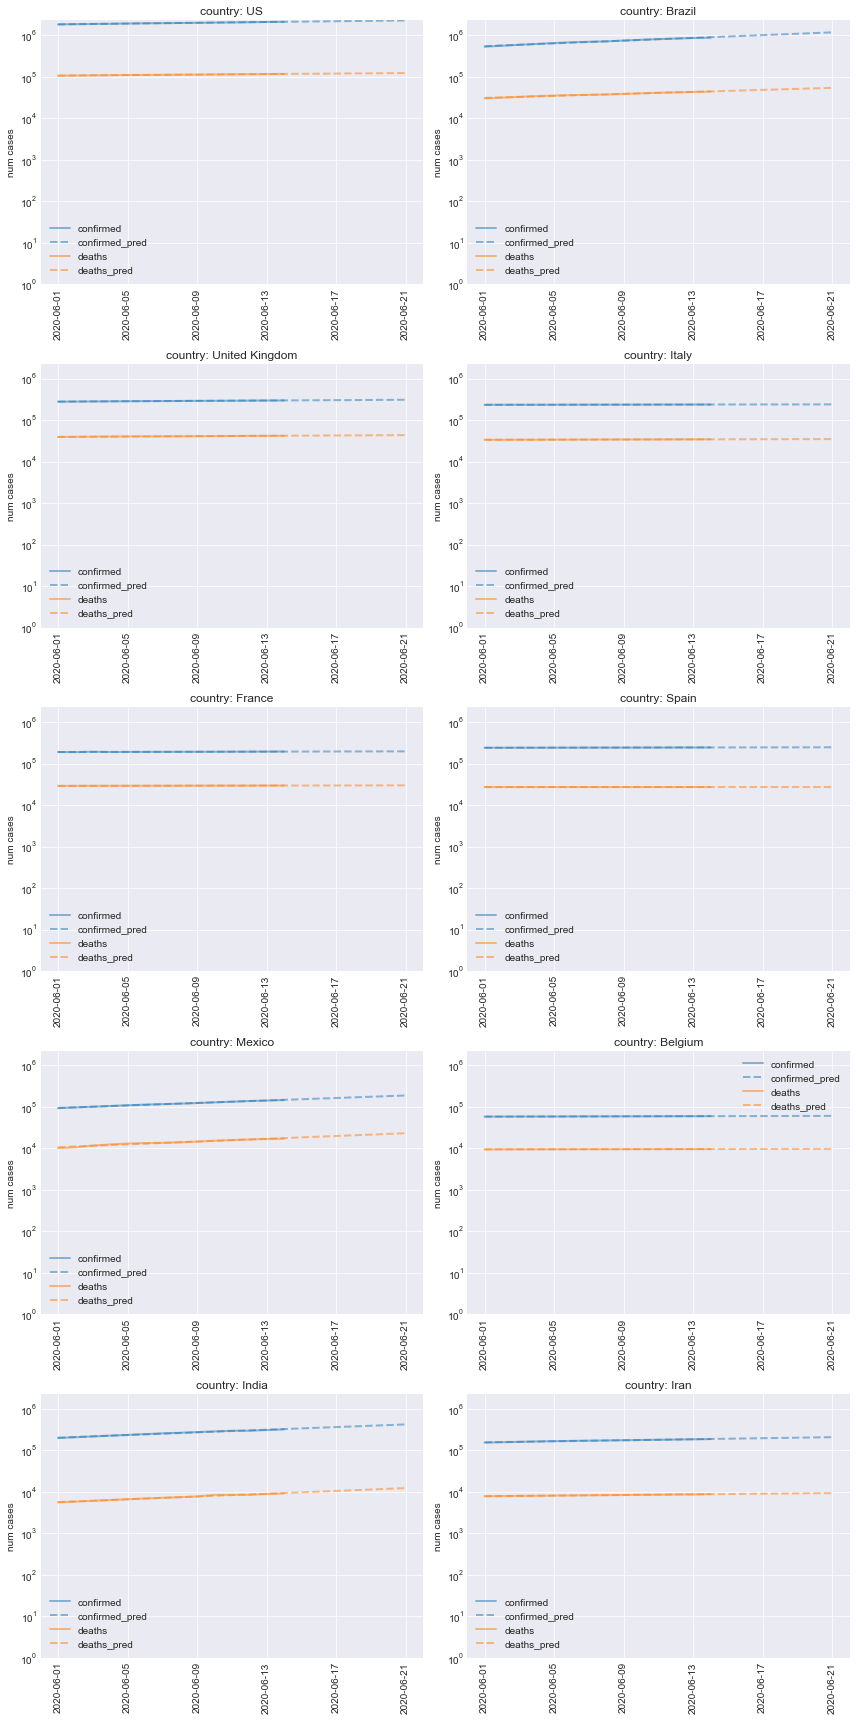

In [706]:
dfp_country_recent_2, dfp_forecasts_out_2 = fit_exp(dfp_country, 
                                                    n_days_predict=14, 
                                                    col_locale='country', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_country_recent_2)

In [707]:
save_forecast(dfp_forecasts_out_2, dfp_country_recent_2, 14)

saved forecast to predictions/covid-19_country_forecast_from_2020-06-14_n_days_training=14.csv


<a id='time-series_country_mortality'></a>
# Time-series plots of mortality

In [708]:
def plot_mortality_rate(
    dfp, 
    locales, 
    id_col='country', 
    upper_lim=0.2, 
    date_min=datetime.datetime(2020,2,20),
    dfp_country_mortality_expected=None
):
    
    for locale in locales:
        dfp_plot = dfp[(dfp[id_col] == locale) &
                       (dfp['date'] >= date_min)
                      ]
        p = plt.plot(dfp_plot['date'], dfp_plot['mortality_rate'], label=locale, alpha=0.7)
        
        if dfp_country_mortality_expected is not None:
            dfp_expected = dfp_country_mortality_expected[dfp_country_mortality_expected['country'] == locale]
            
            color = p[0].get_color()
            expected = dfp_expected['frac_mortality'].values[0]
            plt.axhline(expected, 
                        color=color, 
                        alpha=0.5, 
                        linestyle='--', 
                        label=f'{locale} expected = {expected:0.4f}'
                       )
    #plt.legend(loc='best')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    if upper_lim is not None:
        plt.ylim([0,upper_lim])
    #plt.yscale('log')
    plt.ylabel('mortality rate')
    plt.title(f'Mortality by {id_col}')
    plt.xticks(rotation=90)
    plt.show()
    return None

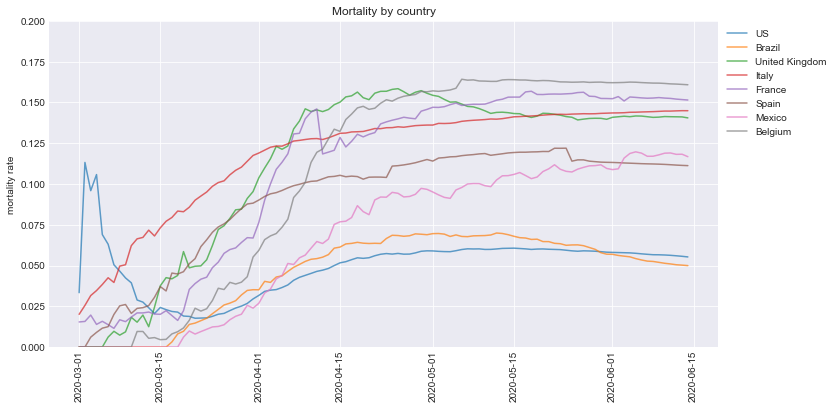

In [709]:
n_countries = 8
countries = dfp_top_countries.iloc[:n_countries]['country']

plot_mortality_rate(dfp_country, countries, upper_lim=0.2, id_col='country', date_min=datetime.datetime(2020,3,1))

### Is mortality rate a function of number of infections?

In [710]:
def plot_mortality_rate_vs_infections(
    dfp, 
    locales, 
    id_col='country', 
    upper_lim=0.2, 
    date_min=datetime.datetime(2020,2,20),
    x_col='confirmed',
    y_col='mortality_rate'
):
    
    for locale in locales:
        dfp_plot = dfp[(dfp[id_col] == locale) &
                       (dfp['date'] >= date_min)
                      ]
        plt.plot(dfp_plot[x_col], dfp_plot[y_col], 'o', label=locale, alpha=0.3)
    plt.legend(loc='best')
    #plt.ylim([0,upper_lim])
    plt.gca().set_ylim(top=upper_lim)
    plt.xscale('log')
    #plt.yscale('log')
    #plt.xlabel('# confirmed cases')
    #plt.ylabel('mortality rate')
    plt.xlabel(x_col.replace('_', ' '))
    plt.ylabel(y_col.replace('_', ' '))
    plt.title(f'{y_col} vs {x_col} by {id_col}')
    plt.xticks(rotation=90)
    plt.show()
    return None

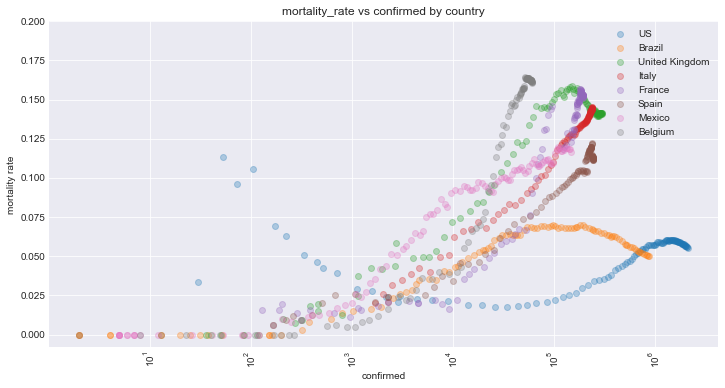

In [711]:
plot_mortality_rate_vs_infections(dfp_country, countries, upper_lim=0.2, id_col='country', date_min=datetime.datetime(2020,3,1))

# Compare mortality rate to expected given country demographics and mortality by age data?

- Country demographic data source: https://www.census.gov/data-tools/demo/idb/region.php?T=10&RT=0&A=both&Y=2020&C=AF&R=1
- Mortality by age source: https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/

In [712]:
# mortality data
d_mortality = {0: 0, 10: 0.002, 20: 0.002, 30: 0.002, 40: 0.004, 50: 0.013, 60: 0.036, 70: 0.08, 80: 0.148, 90: 0.148, 100: 0.148}
dfp_mortality = pd.DataFrame.from_dict(d_mortality, orient='index', columns=['mortality_rate']).reset_index(drop=False)
dfp_mortality = dfp_mortality.rename(columns={'index': 'age_decade'})

# demographic data
dfp_demo = pd.read_csv('supporting_data/census_data_20200320_10a682338c.csv', skiprows=1, skipinitialspace=True)

# clean demographic data
dfp_demo = dfp_demo[(dfp_demo['Region'] == 'World') & (dfp_demo['Age'] != 'Total')]
dfp_demo['age_min'] = dfp_demo['Age'].apply(lambda x: np.min([int(y) for y in re.findall('(\d+)', x)]))
dfp_demo['age_mid'] = dfp_demo['age_min'] + 2.5
dfp_demo['age_decade'] = dfp_demo['age_min'].apply(lambda x: int(x / 10) * 10)
dfp_demo = dfp_demo.rename(columns={'Percent Both Sexes': 'pct_pop', 
                                    'Country': 'country',
                                    'Both Sexes Population': 'pop'
                                   })
dfp_demo_decade = dfp_demo.groupby(['country', 'age_decade'], as_index=False).agg({'pct_pop': np.sum, 'pop': np.sum})
dfp_demo_decade.loc[dfp_demo_decade['country'] == 'United States', 'country'] = 'US'

# join mortality with demographics
dfp_demo_decade_mortality = (dfp_demo_decade.merge(dfp_mortality, on=['age_decade'], how='inner').
                             sort_values(by=['country', 'age_decade']).
                             reset_index(drop=True)
                            )
dfp_demo_decade_mortality['frac_mortality'] = dfp_demo_decade_mortality['pct_pop'] * dfp_demo_decade_mortality['mortality_rate'] / 100
dfp_demo_decade_mortality['num_deaths_max_expected'] = dfp_demo_decade_mortality['pop'] * dfp_demo_decade_mortality['mortality_rate']
dfp_country_mortality_expected = (dfp_demo_decade_mortality.
                                  groupby(['country'], as_index=False).
                                  agg({'frac_mortality': np.sum, 
                                       'num_deaths_max_expected': np.sum, 
                                       'pop': np.sum
                                      })
                                 )
dfp_country_mortality_expected.loc[dfp_country_mortality_expected['country'] == 'United States', 'country'] = 'US'

### Age distributions for most infected countries

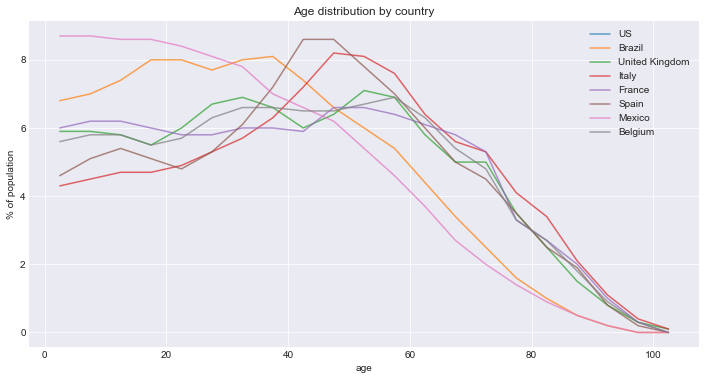

In [713]:
n_countries = 8
countries = dfp_top_countries.iloc[:n_countries]['country']
for country in countries:
    dfp_plot = dfp_demo[dfp_demo.country == country]
    plt.plot(dfp_plot['age_mid'], dfp_plot['pct_pop'], alpha=0.7, label=country)
plt.xlabel('age')
plt.ylabel('% of population')
plt.title('Age distribution by country')
plt.legend(loc='best')
plt.show()

<a id='counry_mortality_expectations'></a>
### Mortality as currently measured, compared to expected based on WHO mortality expectations

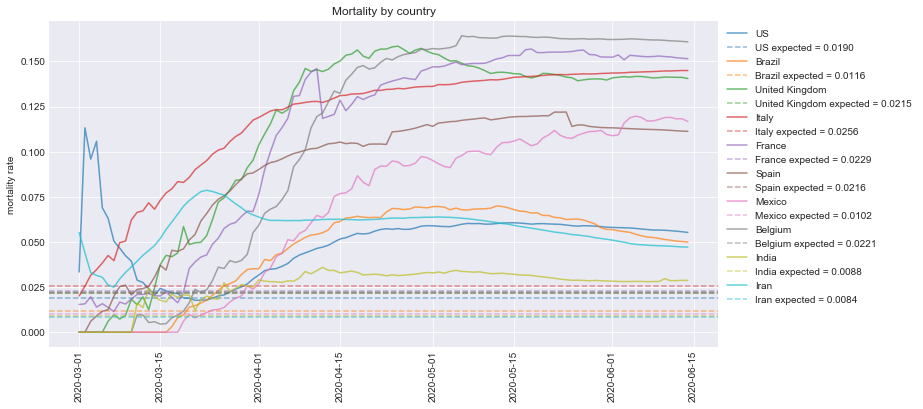

date         country  mortality_rate  confirmed    deaths
0 2020-06-14         Belgium        0.160839    60029.0    9655.0
1 2020-06-14          France        0.151478   194153.0   29410.0
2 2020-06-14           Italy        0.144922   236989.0   34345.0
3 2020-06-14  United Kingdom        0.140522   297342.0   41783.0
4 2020-06-14          Mexico        0.116735   146837.0   17141.0
5 2020-06-14           Spain        0.111246   243928.0   27136.0
6 2020-06-14              US        0.055267  2094058.0  115732.0
7 2020-06-14          Brazil        0.049943   867624.0   43332.0
8 2020-06-14            Iran        0.047149   187427.0    8837.0
9 2020-06-14           India        0.028652   320922.0    9195.0

In [714]:
n_countries = 10
countries = dfp_top_countries.iloc[:n_countries]['country']

plot_mortality_rate(dfp_country, countries, upper_lim=None, id_col='country', date_min=datetime.datetime(2020,3,1), dfp_country_mortality_expected=dfp_country_mortality_expected)
dfp_display = (dfp_country[(dfp_country['date'] == dfp_country['date'].max()) & 
                           (dfp_country['country'].isin(countries))
                          ].
               sort_values(by='mortality_rate', ascending=0).
               reset_index(drop=True)
              )[['date', 'country', 'mortality_rate', 'confirmed', 'deaths']]
display(dfp_display)

**Remarks about the mortality rate being above the expected mortality rate**

Assuming the [cited report](https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/) of age-wise mortality is correct and that the virus is homogeneously distributed amongst the population, a discrepancy like this could arise if the country has:
- Preferentially tested people in critical condition, ignoring test for mild cases (perhaps if testing capacity is saturated)
- An overloaded hospital system, where patients are not receiving the same quality of care they would otherwise

If the testing is biased, we can estimate the true number of infections by multiplying the confirmed cases by the ratio between the measured mortality rate and the expected mortality rate.  For example, in Iran (as of 2020-03-22), we might estimate the true number of cases is 9.3x higher using this method (200,589 vs 21,638).

### Distribution of expected mortality fractions

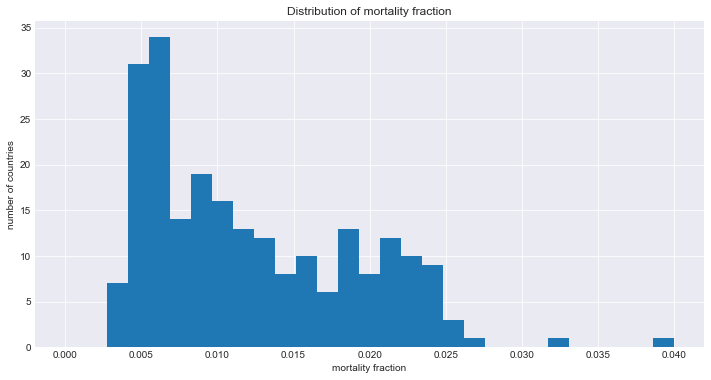

In [715]:
dfp_country_mortality_expected['frac_mortality'].hist(bins=np.linspace(0,0.04,30))
plt.title('Distribution of mortality fraction')
plt.ylabel('number of countries')
plt.xlabel('mortality fraction')
plt.show()

### Top expected mortality fractions based on age demographics
For countries with populations greater than 10 million.

In [716]:
dfp_country_mortality_expected = dfp_country_mortality_expected.sort_values(by='frac_mortality', ascending=0).reset_index(drop=True)
dfp_country_mortality_expected[dfp_country_mortality_expected['pop'] > 1E7].head(10)

country  frac_mortality  num_deaths_max_expected        pop
1         Japan        0.031837              3998380.024  125507472
2       Germany        0.026398              2128411.026   80159662
3        Greece        0.025745               271233.247   10607051
4         Italy        0.025637              1599267.592   62402659
10     Portugal        0.023736               244829.259   10302674
18       France        0.022950              1564984.503   67848156
20       Sweden        0.022575               231555.716   10202491
23      Belgium        0.022146               259573.363   11720716
24  Netherlands        0.022076               382222.125   17280397
27       Canada        0.021712               820035.480   37694085

<a id='density_of_infections_by_country'></a>
# Density of infections per million people

In [717]:
# plot of country fractions that are infected
dfp_country_pop = dfp_country.merge(dfp_country_mortality_expected[['country', 'pop']], on='country', how='left').copy()
dfp_country_pop['deaths_per_million'] = dfp_country_pop['deaths'] / dfp_country_pop['pop'] * 1E6
dfp_country_pop['confirmed_per_million'] = dfp_country_pop['confirmed'] / dfp_country_pop['pop'] * 1E6

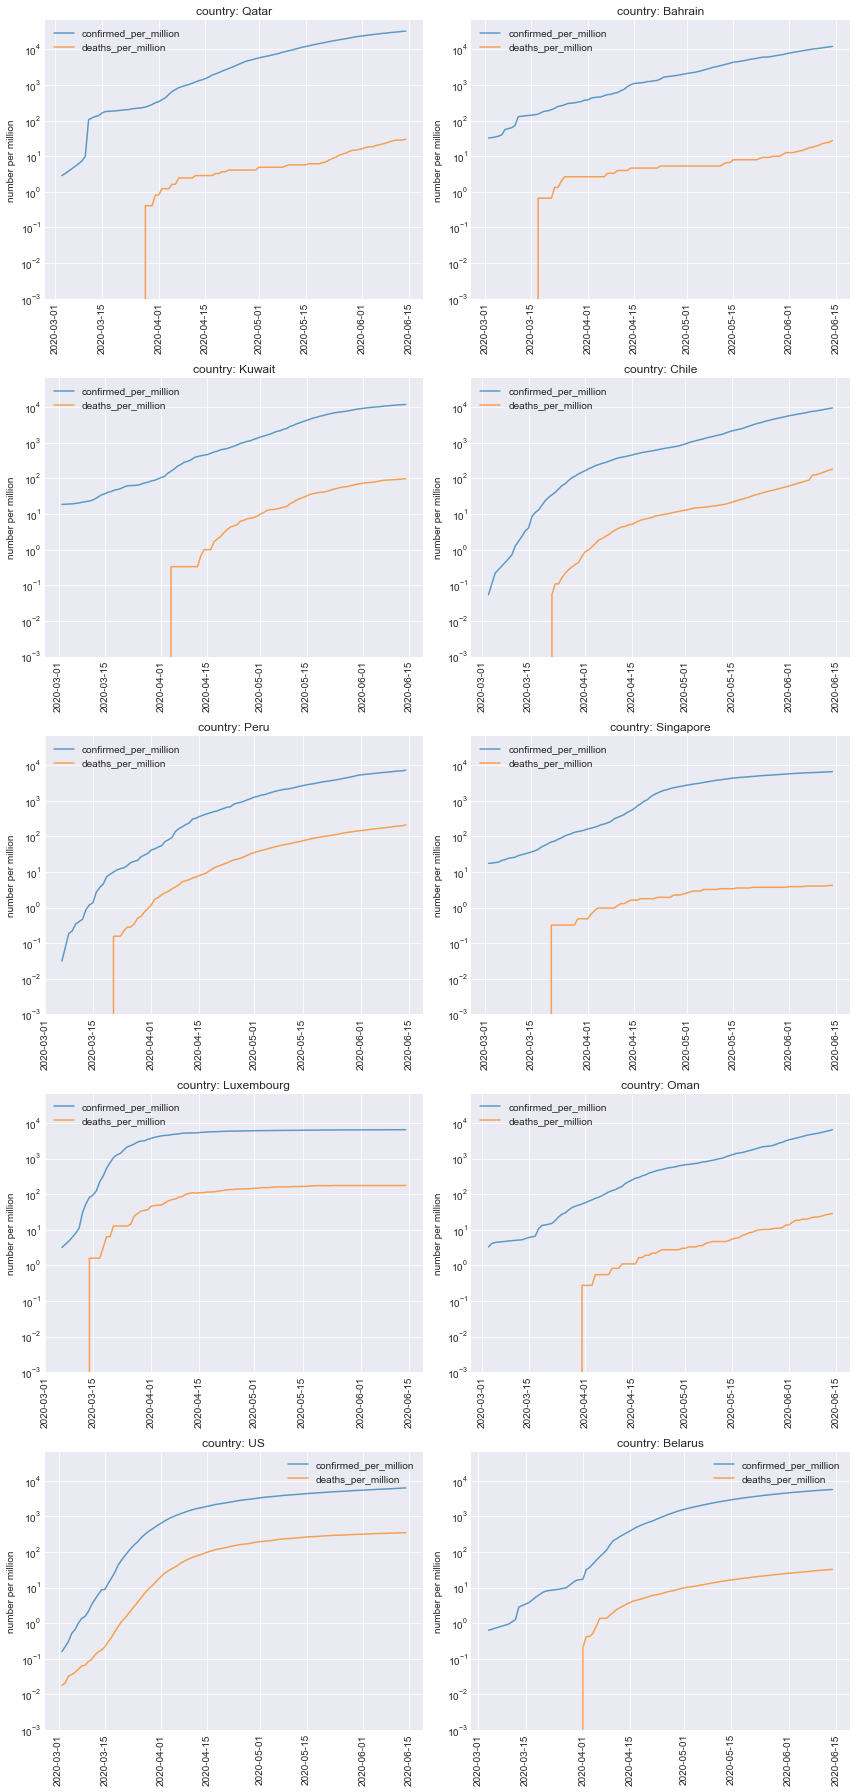

country   population  confirmed    deaths  confirmed_per_million  \
0       Qatar    2444174.0    79602.0      73.0           32568.057757   
1     Bahrain    1505003.0    18227.0      42.0           12110.939314   
2      Kuwait    2993706.0    35920.0     296.0           11998.506199   
3       Chile   18186770.0   174293.0    3323.0            9583.504932   
4        Peru   31914989.0   229736.0    6688.0            7198.373153   
5   Singapore    6209660.0    40604.0      26.0            6538.844317   
6  Luxembourg     628381.0     4070.0     110.0            6476.962225   
7        Oman    3634689.0    23481.0     104.0            6460.250107   
8          US  332639102.0  2094058.0  115732.0            6295.285153   
9     Belarus    9477918.0    53973.0     308.0            5694.605081   

   deaths_per_million  mortality_rate  
0           29.866941        0.000917  
1           27.906921        0.002304  
2           98.874105        0.008241  
3          182.715238        0.019066  
4          209.556707        0.029112  
5            4.187025        0.000640  
6          175.053033        0.027027  
7           28.613177        0.004429  
8          347.920612        0.055267  
9           32.496588        0.005707

In [718]:
n_countries = 10
dfp_country_pop_top = (dfp_country_pop[(dfp_country_pop['date'] == dfp_country_pop['date'].max()) &
                                       (dfp_country_pop['pop'] >= 1E5)
                                      ].
                       sort_values(by='confirmed_per_million', ascending=0).
                       reset_index(drop=True)
                      )

plot_countries(dfp_country_pop, 
               countries=dfp_country_pop_top.iloc[:n_countries]['country'],
               plot_cols=['confirmed_per_million', 'deaths_per_million'],
               country_col='country',
               y_max=dfp_country_pop['confirmed_per_million'].max()*2,
               y_min=0.001,
               y_label='number per million',
               date_min=datetime.datetime(2020,3,2)
              )
display_cols = ['country', 'pop', 'confirmed', 'deaths', 'confirmed_per_million', 'deaths_per_million', 'mortality_rate']
display(dfp_country_pop_top[display_cols].rename(columns={'pop': 'population'}).head(10))

In [719]:
dfp_country_pop_top[display_cols].sort_values(by='deaths_per_million', ascending=0).head(10)

country          pop  confirmed    deaths  confirmed_per_million  \
14         Belgium   11720716.0    60029.0    9655.0            5121.615437   
19  United Kingdom   65761117.0   297342.0   41783.0            4521.547285   
22           Italy   62402659.0   236989.0   34345.0            3797.738811   
17           Spain   50015792.0   243928.0   27136.0            4877.019642   
15          Sweden   10202491.0    51614.0    4874.0            5058.960601   
29          France   67848156.0   194153.0   29410.0            2861.581087   
30     Netherlands   17280397.0    48990.0    6078.0            2835.004312   
8               US  332639102.0  2094058.0  115732.0            6295.285153   
16         Ireland    5176569.0    25303.0    1706.0            4887.986618   
25     Switzerland    8403994.0    31117.0    1938.0            3702.644243   

    deaths_per_million  mortality_rate  
14          823.755136        0.160839  
19          635.375461        0.140522  
22          550.377188        0.144922  
17          542.548641        0.111246  
15          477.726469        0.094432  
29          433.467934        0.151478  
30          351.728030        0.124066  
8           347.920612        0.055267  
16          329.561916        0.067423  
25          230.604639        0.062281

### Mortality rate by deaths per capita, confirmed per capita

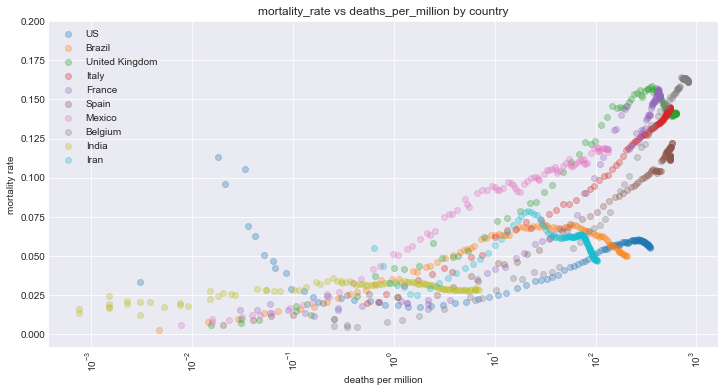

In [720]:
plot_mortality_rate_vs_infections(dfp_country_pop, 
                                  countries, 
                                  upper_lim=0.2, 
                                  id_col='country', 
                                  date_min=datetime.datetime(2020,3,1), 
                                  x_col='deaths_per_million', 
                                  y_col='mortality_rate'
                                 )

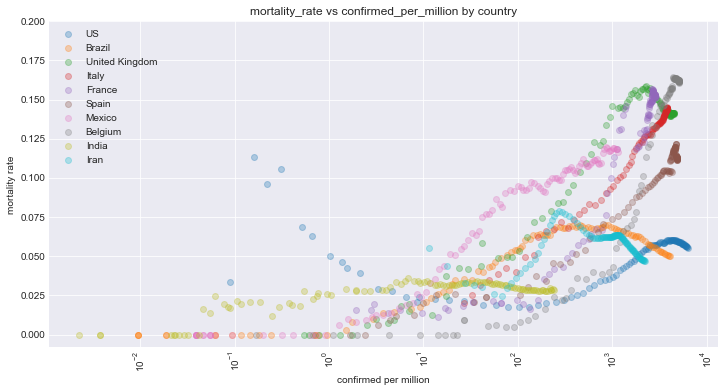

In [721]:
plot_mortality_rate_vs_infections(dfp_country_pop, 
                                  countries, 
                                  upper_lim=0.2, 
                                  id_col='country', 
                                  date_min=datetime.datetime(2020,3,1), 
                                  x_col='confirmed_per_million', 
                                  y_col='mortality_rate'
                                 )

<a id='days_behind'></a>
# How many days behind is each country from Italy?

In [722]:
def days_behind_multi_country(
    countries_compare, 
    country_base, 
    dfp=dfp_country_pop, 
    n_days=14, 
    country_col='country',
    compare_col='confirmed_frac'
):
#     country_compare = 'Spain'
#     country_base = 'Italy'
    countries = [country_base] + countries_compare
    #n_days = 14  # compare the lag over the last n_days

    # compare the fraction of cases directly
    list_dfp_compare = []
    d_dfp_compare = {}

    for i, country in enumerate(countries):
        dfp_p = dfp[dfp[country_col] == country]
        dfp_p = dfp_p.sort_values(by='date', ascending=0).reset_index(drop=True)
        
        if country == country_base:
            line_style = '-'
            dfp_comp = dfp_p.copy()
            alpha=1
        else:
            line_style = '--'
            list_dfp_compare.append(dfp_p)
            d_dfp_compare[country] = dfp_p
            alpha=0.7
        
        plt.plot(dfp_p['date'], dfp_p['confirmed'], linestyle=line_style, alpha=alpha, label=country)
        
    plt.legend(loc='best')
    plt.title('Raw number of cases')
    plt.ylabel('cases')
    plt.yscale('log')
    plt.show()


    # compute the best estimate of the lag between countries
    # this assumes that the best metric is density of cases
    # though this may be more dependent on localities
    metric = compare_col
    delta_col = f'delta_{metric}'
    list_series = []

    for country, dfp_test in d_dfp_compare.items():
        list_series = []
        delta_col = f'delta_{metric}_{country}'
        for i, row in dfp_test[:n_days].iterrows():
            dfp_comp[delta_col] = np.abs(dfp_comp[metric] - row[metric])
            min_loc = dfp_comp[delta_col] == dfp_comp[delta_col].min()
            #print(row['date'] - dfp_comp[min_loc]['date'])
            days_diff = pd.to_timedelta(row['date'] - dfp_comp[min_loc]['date']).astype('timedelta64[D]').values[0]
            row['days_diff'] = days_diff
            row['country_compare'] = country
            list_series.append(row)

        # plot days behind
        dfp_days_behind = pd.concat(list_series, axis=1).T
        plt.plot(dfp_days_behind['date'], dfp_days_behind['days_diff'], label=country, alpha=0.5)
        mean_days_diff = dfp_days_behind['days_diff'].mean()#{str(dfp['date'].max())}
        date_max = dfp['date'].max().strftime('%Y-%m-%d')
    plt.axhline(0, label='0', color='k', linestyle='--', alpha=0.5)
    #print(f'Computing how far behind a country is using the {compare_col} column:')
    plt.title(f'Number days each {country_col} is from {country_base} as of {date_max} using {compare_col}')
    plt.ylabel('# days')
    plt.legend(loc='best')
    plt.show()
    return dfp_days_behind

##### Days behind Italy via density of cases

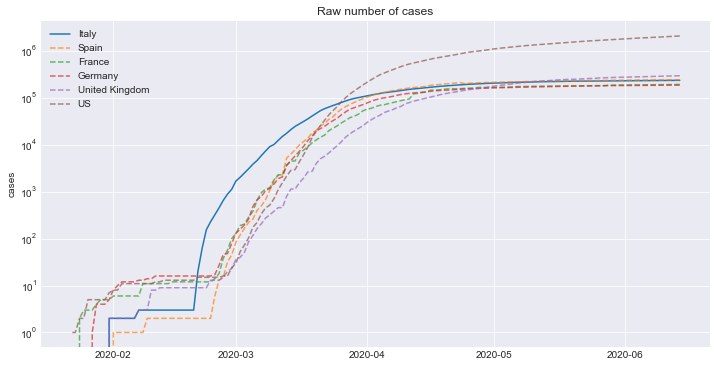

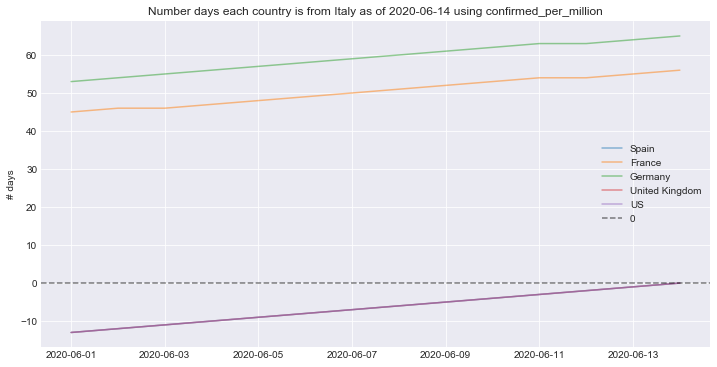

In [723]:
_ = days_behind_multi_country(['Spain', 'France', 'Germany', 'United Kingdom', 'US'], 'Italy', dfp=dfp_country_pop, compare_col='confirmed_per_million')

##### Days behind Italy via number of confirmed cases

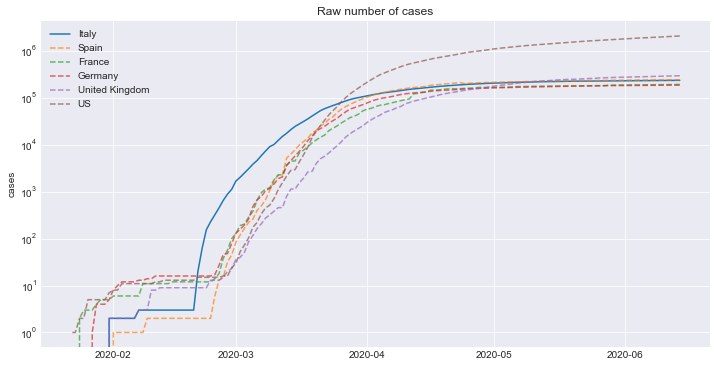

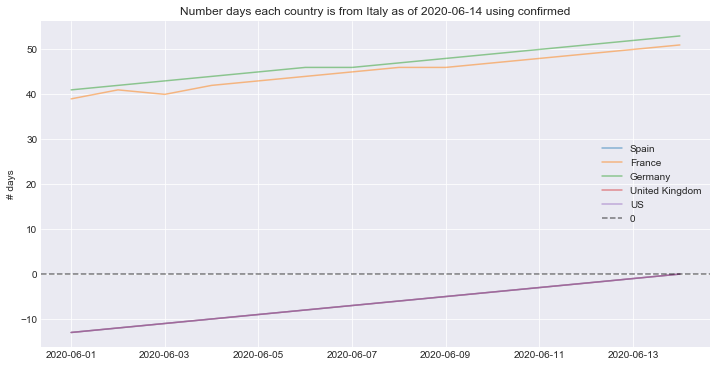

In [724]:
_ = days_behind_multi_country(['Spain', 'France', 'Germany', 'United Kingdom', 'US'], 'Italy', dfp=dfp_country_pop, compare_col='confirmed')

# US state breakdown

In [725]:
# load and clean data
dfp_us_raw = pd.read_csv('state_data/states-daily.csv')
dfp_us_raw = dfp_us_raw.rename(columns={'state': 'state_clean_1',
                                        'positive': 'confirmed',
                                        'death': 'deaths',
                                        'date': 'date_str'
                                       })
dfp_us_raw['date'] = dfp_us_raw['date_str'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
dfp_us_raw['country'] = 'US'

In [726]:
# load and clean data from CSSEGIS
state_base_dir = '../COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/'
data_paths_raw = os.listdir(state_base_dir)
data_paths = [path for path in data_paths_raw if path.endswith('csv')]
list_dfp_states = []
cols_of_interest = ['country', 'state', 'date', 'confirmed', 'deaths', 'recovered']
for path in data_paths:
    full_path = os.path.join(state_base_dir, path)
    
    # read state data
    dfp_temp = pd.read_csv(full_path)
    cols = list(dfp_temp.columns)
    
    # clean column names
    cols_translate = {'Country/Region': 'country',
                      'Province/State': 'state',
                      'Confirmed': 'confirmed',
                      'Deaths': 'deaths',
                      'Recovered': 'recovered',
                      'Country_Region': 'country',
                      'Province_State': 'state',
                      'Last_Update': 'Last Update'
                     }
    dfp_temp = dfp_temp.rename(columns=cols_translate)
    dfp_temp['date'] = dfp_temp['Last Update'].apply(lambda x: parser.parse(x).date())
    dfp_temp['date'] = dfp_temp['date'].apply(lambda x: datetime.datetime(x.year, x.month, x.day))
    dfp_temp = dfp_temp[dfp_temp['country'] == 'US']
    list_dfp_states.append(dfp_temp[cols_of_interest])
dfp_us_raw = pd.concat(list_dfp_states)
dfp_us_raw['state_clean_1'] = dfp_us_raw['state'].apply(lambda x: re.findall('\, ([A-Z]{2}$)', x)[0].strip() if re.findall('\, ([A-Z]{2}$)', x) else x)

In [727]:
# look only at the US
#dfp_us_raw = dfp[dfp['country'] == 'US'].copy()
#dfp_us_raw['state_clean_1'] = dfp_us_raw['state'].apply(lambda x: re.findall('\, ([A-Z]{2})', x)[0].strip() if re.findall('\, ([A-Z]{2})', x) else x)

# load codes to convert two-letter codes to state names
dfp_state_codes = pd.read_csv('supporting_data/us_state_to_two_letter_code.csv')
dfp_state_codes = dfp_state_codes.rename(columns={'state': 'state_name'})
dfp_us = dfp_us_raw.merge(dfp_state_codes, left_on=['state_clean_1'], right_on=['two_letter_code'], how='left')

In [728]:
# get the most appropriate state name
dfp_us['abbrev'] = ~dfp_us['state_name'].isnull()
dfp_us['state_clean'] = dfp_us.apply(lambda x: x['state_name'] if x['abbrev'] else x['state_clean_1'], axis=1)

# aggregate infections by state
dfp_us_g = (dfp_us.groupby(['date', 'country', 'state_clean'], as_index=False).
            agg({
                'confirmed': np.sum,
                'deaths': np.sum,
                #'recovered': np.sum,
               })
           )
dfp_us_g = dfp_us_g.sort_values(by='date')
dfp_us_g = dfp_us_g.rename(columns={'state_clean': 'state'})
#dfp_us_g['active'] = dfp_us_g['confirmed'] - dfp_us_g['recovered']
dfp_us_g['confirmed_lag1'] = dfp_us_g.groupby(['country', 'state'])['confirmed'].shift(1)
dfp_us_g['deaths_lag1'] = dfp_us_g.groupby(['country', 'state'])['deaths'].shift(1)
dfp_us_g['confirmed_new'] = dfp_us_g['confirmed'] - dfp_us_g['confirmed_lag1']
dfp_us_g['deaths_new'] = dfp_us_g['deaths'] - dfp_us_g['deaths_lag1']
dfp_us_g['deaths_new'] = dfp_us_g['deaths_new'].fillna(0)
dfp_us_g['mortality_rate'] = dfp_us_g['deaths'] / dfp_us_g['confirmed']

<a id='states_most_infections'></a>
### US states with the most new infections

In [729]:
id_cols_state = ['date', 'state']
value_cols_state = ['confirmed', 'confirmed_new', 'deaths', 'deaths_new', 'mortality_rate']

dfp_us_top_states = dfp_us_g[dfp_us_g['date'] == dfp_us_g['date'].max()][id_cols_state + value_cols_state]
dfp_us_top_states = dfp_us_top_states.sort_values(by='deaths', ascending=0).reset_index(drop=True)
dfp_us_top_states = dfp_us_top_states.fillna(0)
for key in value_cols_state:
    if 'rate' in key:
        continue
    dfp_us_top_states[key] = dfp_us_top_states[key].apply(int)
dfp_us_top_states.head(15)

date          state  confirmed  confirmed_new  deaths  deaths_new  \
0  2020-06-15       New York     383324            694   30825          30   
1  2020-06-15     New Jersey     166881            276   12659          38   
2  2020-06-15  Massachusetts     105603            208    7624          48   
3  2020-06-15       Illinois     132543            672    6308          19   
4  2020-06-15   Pennsylvania      83203            259    6215           4   
5  2020-06-15       Michigan      66054            218    6016           3   
6  2020-06-15     California     152300           2282    5099          23   
7  2020-06-15    Connecticut      45088             94    4201          15   
8  2020-06-15      Louisiana      46619            336    3014          10   
9  2020-06-15       Maryland      61701            396    2939          13   
10 2020-06-15        Florida      75568           2016    2931           6   
11 2020-06-15           Ohio      41148            297    2559           3   
12 2020-06-15        Georgia      57681            877    2451           4   
13 2020-06-15        Indiana      39909            366    2422           9   
14 2020-06-15          Texas      88523           1608    1984          13   

    mortality_rate  
0         0.080415  
1         0.075856  
2         0.072195  
3         0.047592  
4         0.074697  
5         0.091077  
6         0.033480  
7         0.093173  
8         0.064652  
9         0.047633  
10        0.038786  
11        0.062190  
12        0.042492  
13        0.060688  
14        0.022412

<a id='time-series_states'></a>
### Time-series plots of infections in most-infected states

In [730]:
def plot_state_data(dfp_us_g, states_oi, plot_col='confirmed', date_min=datetime.datetime(2020, 2, 25)):
    for state in states_oi:
        dfp_s = dfp_us_g[(dfp_us_g['state'] == state) & (dfp_us_g['date'] >= date_min)]
        plt.plot(dfp_s['date'], dfp_s[plot_col], label=state, alpha=0.5)
    plt.ylabel('# cases')
    plt.xticks(rotation=90)
    plt.title(f'{plot_col} in: {", ".join(states_oi)}')
    plt.yscale('log')
    plt.legend(loc='best')
    plt.show()
    return None

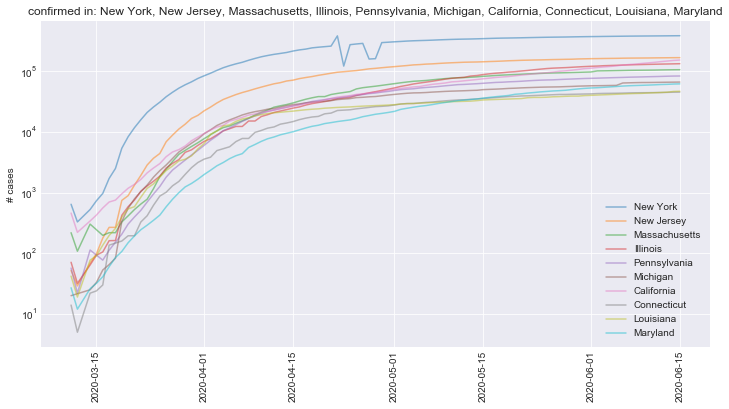

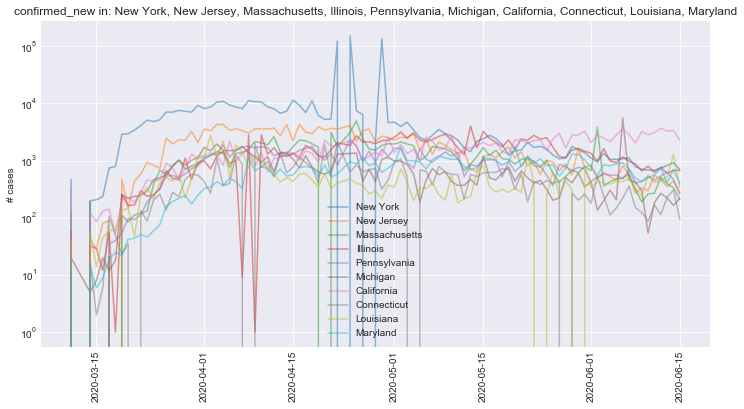

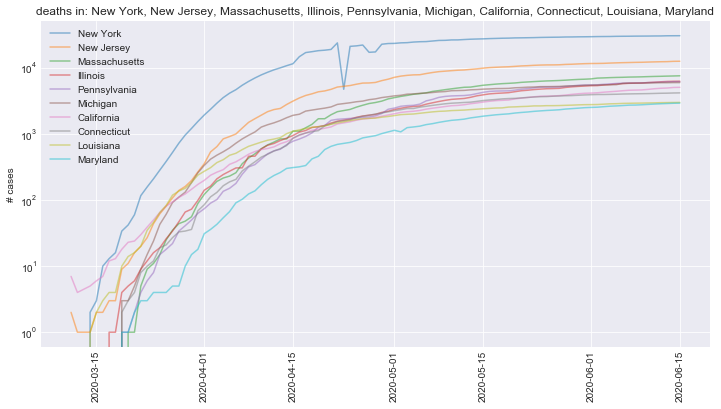

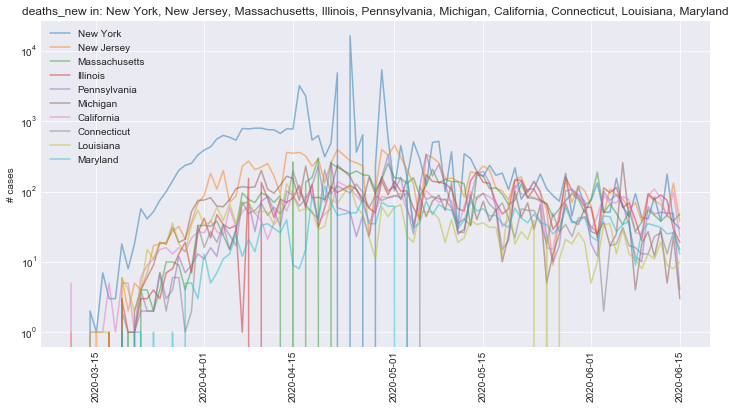

In [731]:
states_oi = dfp_us_top_states.iloc[:10]['state'].values
dt_min = datetime.datetime(2020,3,11)
plot_state_data(dfp_us_g, states_oi, plot_col='confirmed', date_min=dt_min)
plot_state_data(dfp_us_g, states_oi, plot_col='confirmed_new', date_min=dt_min)
plot_state_data(dfp_us_g, states_oi, plot_col='deaths', date_min=dt_min)
plot_state_data(dfp_us_g, states_oi, plot_col='deaths_new', date_min=dt_min)

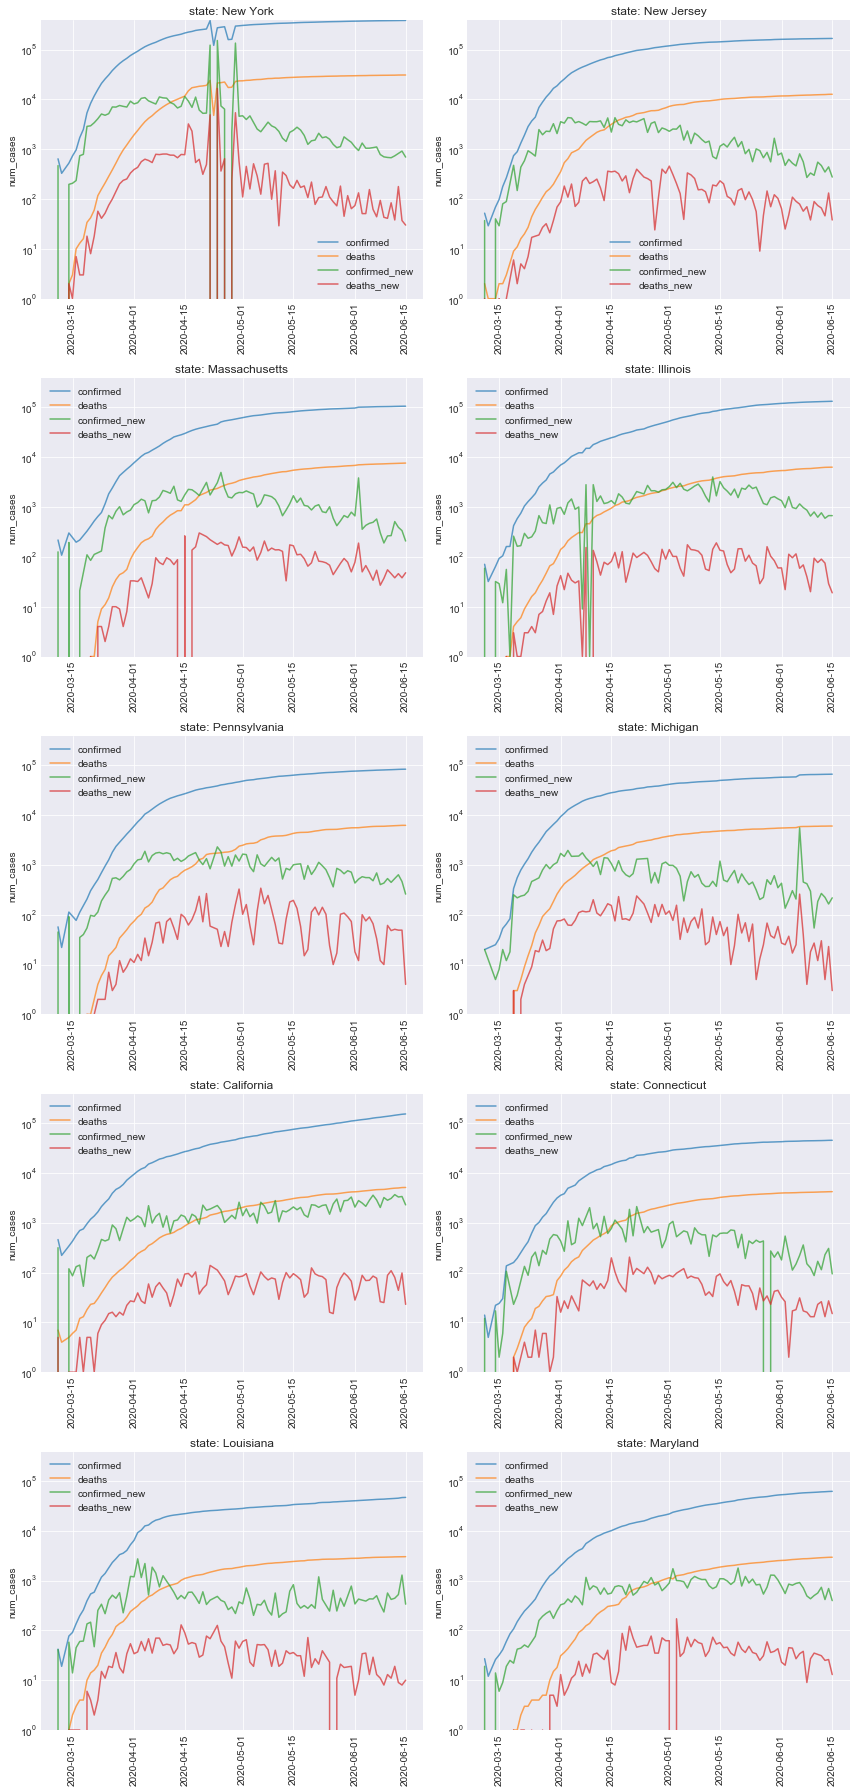

In [732]:
plot_countries(dfp_us_g, 
               countries=dfp_us_top_states.iloc[:10]['state'].values,
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='state',
               date_min=datetime.datetime(2020,3,11),
               y_max=dfp_us_g['confirmed'].max()
              )

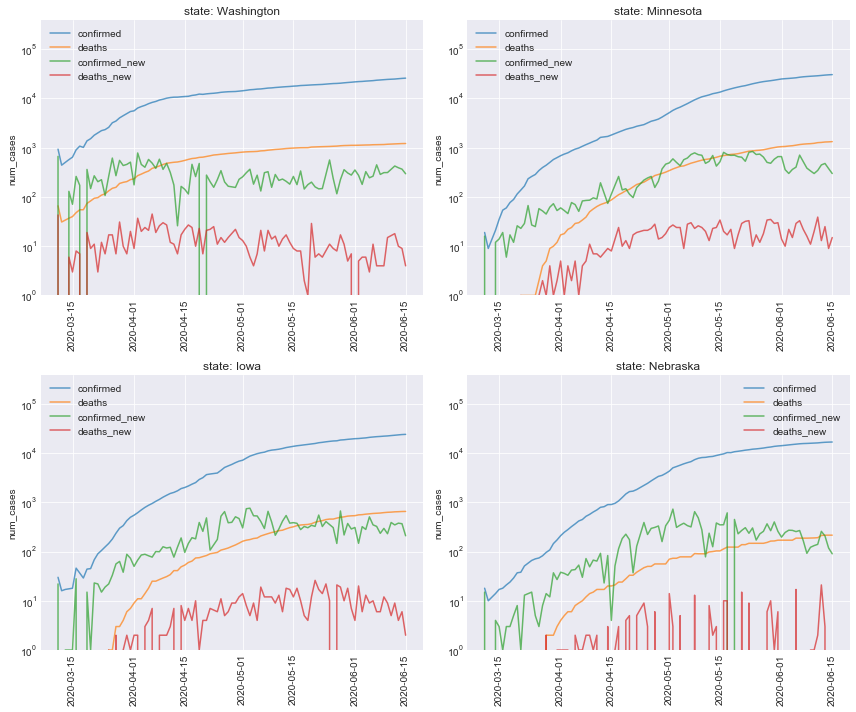

In [733]:
plot_countries(dfp_us_g, 
               countries=['Washington', 'Minnesota', 'Iowa', 'Nebraska'],
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='state',
               date_min=datetime.datetime(2020,3,11),
               y_max=dfp_us_g['confirmed'].max()
              )

<a id='forecast_us_state'></a>
### Forecast by state

##### 1 week of data

confirmed_pred                       deaths_pred             \
date              2020-06-16 2020-06-22 2020-07-06  2020-06-16 2020-06-22   
state                                                                       
New York            384069.0   388726.0   399811.0     30928.0    31388.0   
New Jersey          167391.0   169918.0   175965.0     12743.0    13209.0   
Massachusetts       106041.0   108201.0   113415.0      7669.0     7945.0   
Illinois            133270.0   137508.0   147928.0      6425.0     6856.0   
Pennsylvania         83862.0    86973.0    94687.0      6289.0     6579.0   
Michigan             66236.0    67438.0    70329.0      6042.0     6146.0   
California          156403.0   178759.0   244146.0      5216.0     5722.0   
Connecticut          45262.0    46354.0    49005.0      4223.0     4349.0   
Louisiana            47196.0    51195.0    61892.0      3029.0     3102.0   
Maryland             62380.0    66007.0    75313.0      2979.0     3157.0   

                         mortality_rate_pred                        \
date          2020-07-06          2020-06-16 2020-06-22 2020-07-06   
state                                                                
New York         32491.0            0.080527   0.080746   0.081266   
New Jersey       14362.0            0.076127   0.077737   0.081619   
Massachusetts     8627.0            0.072321   0.073428   0.076066   
Illinois          7978.0            0.048210   0.049859   0.053932   
Pennsylvania      7307.0            0.074992   0.075644   0.077170   
Michigan          6395.0            0.091219   0.091136   0.090930   
California        7102.0            0.033350   0.032010   0.029089   
Connecticut       4658.0            0.093301   0.093821   0.095052   
Louisiana         3280.0            0.064179   0.060592   0.052996   
Maryland          3615.0            0.047756   0.047828   0.048000   

              frac_increase_confirmed frac_increase_deaths  
date                                                        
state                                                       
New York                     0.002010             0.002468  
New Jersey                   0.002501             0.005997  
Massachusetts                0.003367             0.005897  
Illinois                     0.005231             0.010888  
Pennsylvania                 0.006088             0.007530  
Michigan                     0.003003             0.002846  
California                   0.022516             0.015552  
Connecticut                  0.003981             0.004910  
Louisiana                    0.013646             0.003987  
Maryland                     0.009465             0.009721

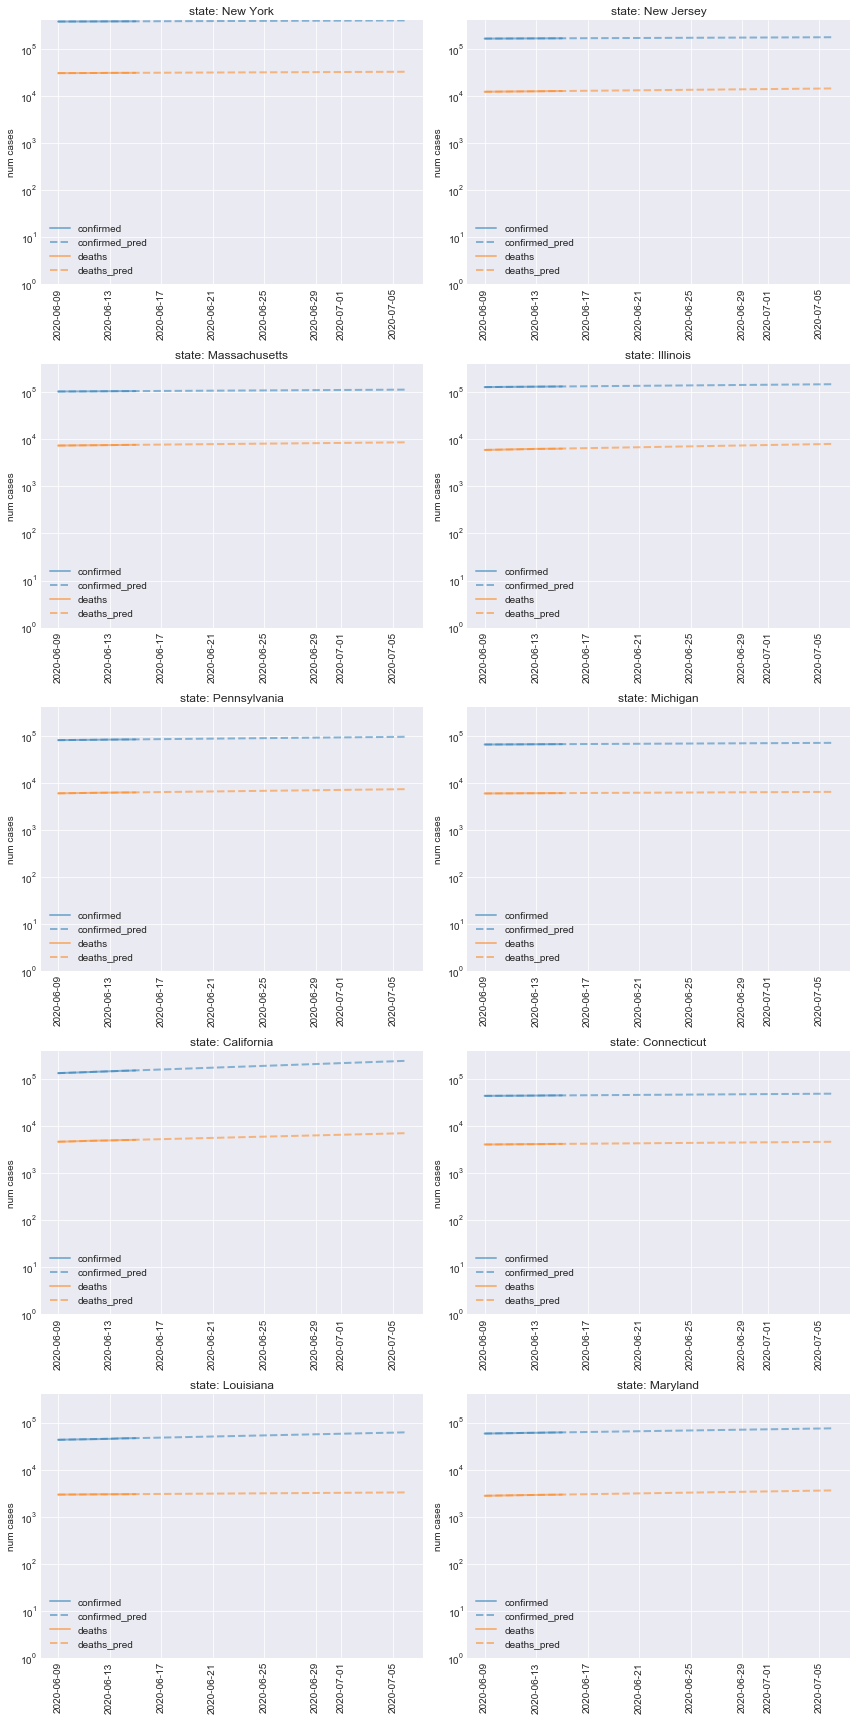

In [734]:
dfp_state_recent_1, dfp_state_forecasts_out_1 = fit_exp(dfp_us_g, 
                                                    n_days_predict=7,
                                                    n_days_into_future=[1,7,21],
                                                    col_locale='state', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_state_recent_1, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='state',
                  )

##### 2 weeks of data

confirmed_pred                       deaths_pred             \
date              2020-06-16 2020-06-22 2020-07-06  2020-06-16 2020-06-22   
state                                                                       
New York            384553.0   389857.0   402518.0     30920.0    31360.0   
New Jersey          167608.0   170409.0   177127.0     12744.0    13201.0   
Massachusetts       106179.0   108493.0   114090.0      7676.0     7958.0   
Illinois            134042.0   139438.0   152887.0      6452.0     6914.0   
Pennsylvania         83981.0    87256.0    95402.0      6309.0     6615.0   
Michigan             68701.0    73693.0    86798.0      6152.0     6421.0   
California          156387.0   178678.0   243838.0      5204.0     5679.0   
Connecticut          45293.0    46412.0    49131.0      4218.0     4334.0   
Louisiana            46725.0    49834.0    57916.0      3046.0     3142.0   
Maryland             62824.0    67079.0    78163.0      2993.0     3191.0   

                         mortality_rate_pred                        \
date          2020-07-06          2020-06-16 2020-06-22 2020-07-06   
state                                                                
New York         32409.0            0.080405   0.080440   0.080516   
New Jersey       14333.0            0.076035   0.077467   0.080919   
Massachusetts     8656.0            0.072293   0.073350   0.075870   
Illinois          8125.0            0.048134   0.049585   0.053144   
Pennsylvania      7386.0            0.075124   0.075811   0.077420   
Michigan          7095.0            0.089547   0.087132   0.081742   
California        6962.0            0.033276   0.031783   0.028552   
Connecticut       4618.0            0.093127   0.093381   0.093994   
Louisiana         3378.0            0.065190   0.063049   0.058326   
Maryland          3705.0            0.047641   0.047571   0.047401   

              frac_increase_confirmed frac_increase_deaths  
date                                                        
state                                                       
New York                     0.002285             0.002354  
New Jersey                   0.002766             0.005891  
Massachusetts                0.003599             0.006030  
Illinois                     0.006599             0.011597  
Pennsylvania                 0.006396             0.007910  
Michigan                     0.011760             0.007153  
California                   0.022457             0.014653  
Connecticut                  0.004075             0.004541  
Louisiana                    0.010793             0.005189  
Maryland                     0.010983             0.010728

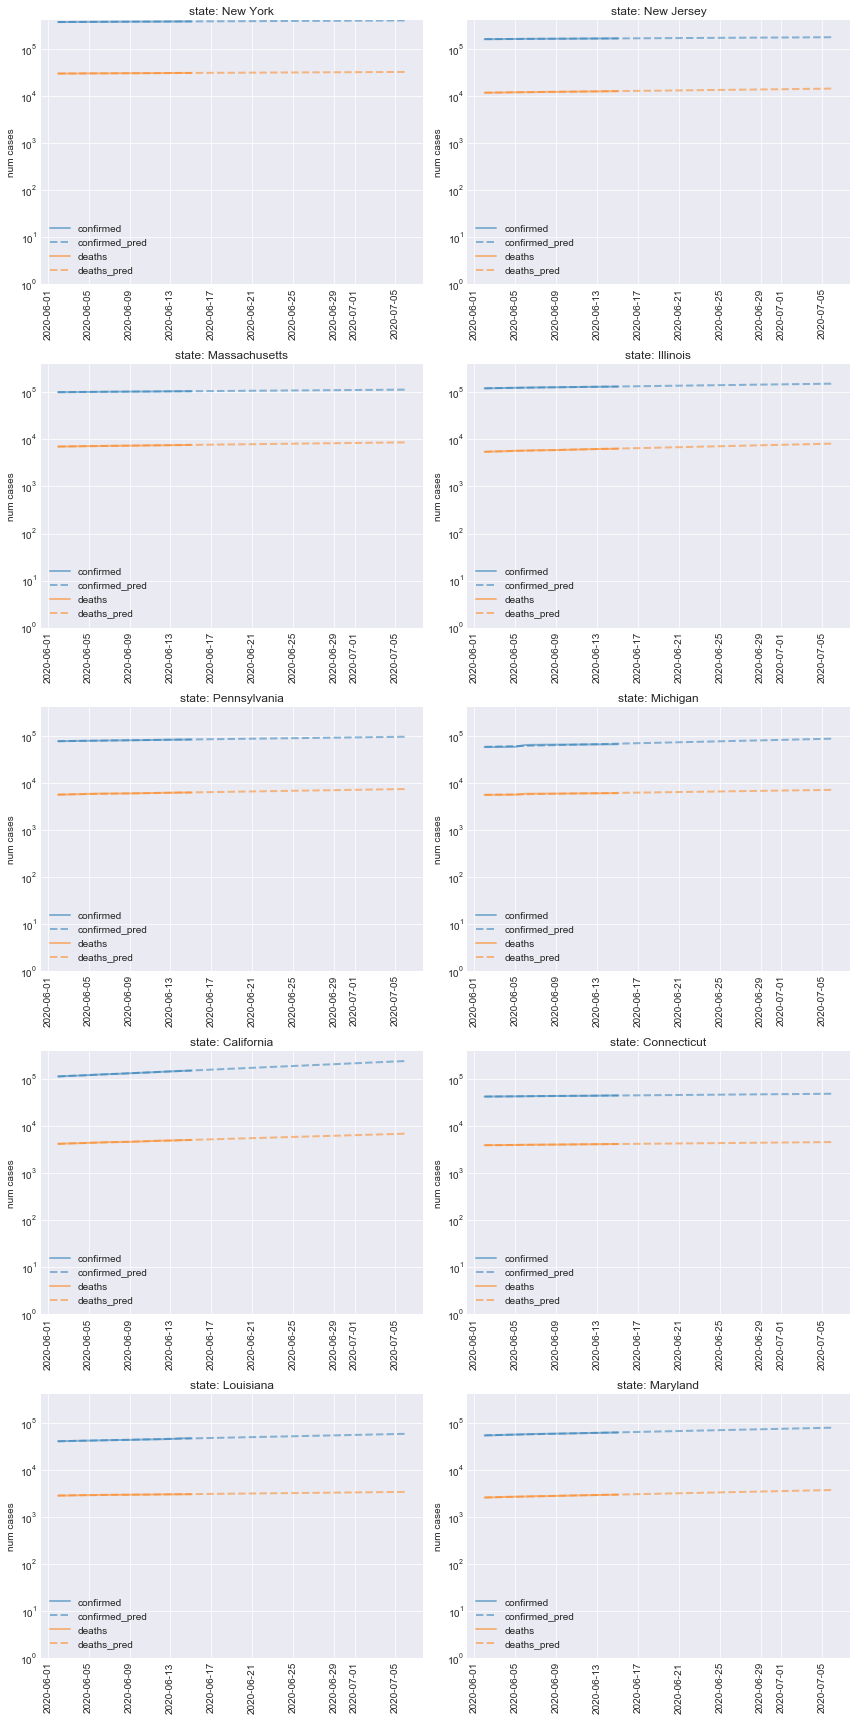

In [735]:
dfp_state_recent_2, dfp_state_forecasts_out_2 = fit_exp(dfp_us_g, 
                                                    n_days_predict=14,
                                                    n_days_into_future=[1,7,21],
                                                    col_locale='state', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_state_recent_2, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='state',
                  )

<a id='us_state_daily_increase_fraction'></a>
##### States and their daily increase fraction in confirmed cases/deaths
Computed via linear fit of the log of the confirmed cases/deaths over the last 7 days.

In [736]:
# increase_cols = ['state', 'frac_increase_confirmed', 'frac_increase_deaths']
# curr_cols = ['date', 'state', 'confirmed', 'deaths']
# dfp_state_increase_m = dfp_us_g_latest[curr_cols].merge(dfp_state_increase[increase_cols], on=['state'], how='inner')
# for col in ['confirmed', 'deaths']:
#     dfp_state_increase_m[col] = dfp_state_increase_m[col].apply(int)

In [737]:
# latest date
dt_latest = dfp_us_g['date'].max()
dfp_us_g_date_max = dfp_us_g.groupby(['state'], as_index=False).agg({'date': np.max})
#dfp_us_g_latest = dfp_us_g[dfp_us_g['date'] == dt_latest].copy()
dfp_us_g_latest = dfp_us_g.merge(dfp_us_g_date_max, on=['state', 'date'], how='inner')

# what is the distribution in % increase in deaths?
dfp_state_increase = (dfp_state_forecasts_out_1[(dfp_state_forecasts_out_1['date'] == dfp_state_forecasts_out_1['date'].max()) &
                                                (dfp_state_forecasts_out_1['deaths_pred'] > 2)
                                               ].
                      sort_values(by='frac_increase_deaths', ascending=0).
                      reset_index(drop=True)
                     )
increase_cols = ['state', 'frac_increase_confirmed', 'frac_increase_deaths']
curr_cols = ['date', 'state']
int_cols = ['confirmed', 'deaths', 'deaths_new']
float_cols = ['frac_increase_confirmed', 'frac_increase_deaths']
dfp_state_increase_m = dfp_us_g_latest[curr_cols + int_cols].merge(dfp_state_increase[increase_cols], on=['state'], how='inner')
for col in int_cols:
    dfp_state_increase_m[col] = dfp_state_increase_m[col].apply(int)
for col in float_cols:
    dfp_state_increase_m[col] = dfp_state_increase_m[col].apply(lambda x: np.round(float(x),3))
(dfp_state_increase_m[curr_cols + int_cols + float_cols].
 sort_values(by='frac_increase_deaths', ascending=0).
 reset_index(drop=True)
)


date                 state  confirmed  deaths  deaths_new  \
0  2020-06-15                Alaska        660      12           0   
1  2020-06-15              Nebraska      16730     215           0   
2  2020-06-15          South Dakota       5898      75           0   
3  2020-06-15              Arkansas      12501     179           2   
4  2020-06-15               Arizona      35706    1191           2   
5  2020-06-15                  Utah      14313     139           0   
6  2020-06-15         New Hampshire       5318     320           2   
7  2020-06-15             Tennessee      30343     474           2   
8  2020-06-15               Georgia      57681    2451           4   
9  2020-06-15             Minnesota      30471    1329          15   
10 2020-06-15            California     152300    5099          23   
11 2020-06-15            New Mexico       9723     435           4   
12 2020-06-15        North Carolina      44264    1132           5   
13 2020-06-15               Alabama      25615     773           0   
14 2020-06-15                 Texas      88523    1984          13   
15 2020-06-15               Florida      75568    2931           6   
16 2020-06-15        South Carolina      18795     600           1   
17 2020-06-15              Missouri      16262     885           0   
18 2020-06-15             Wisconsin      22758     692           1   
19 2020-06-15           Mississippi      19516     891           2   
20 2020-06-15              Illinois     132543    6308          19   
21 2020-06-15                  Ohio      41148    2559           3   
22 2020-06-15              Kentucky      12445     499           0   
23 2020-06-15              Maryland      61701    2939          13   
24 2020-06-15               Wyoming       1060      18           0   
25 2020-06-15         West Virginia       2290      88           0   
26 2020-06-15                  Iowa      23926     652           2   
27 2020-06-15          Pennsylvania      83203    6215           4   
28 2020-06-15              Delaware      10264     422           3   
29 2020-06-15                Nevada      11201     463           1   
30 2020-06-15               Indiana      39909    2422           9   
31 2020-06-15                 Idaho       3399      87           0   
32 2020-06-15  District of Columbia       9767     515           4   
33 2020-06-15                Oregon       5377     173           0   
34 2020-06-15            Washington      25834    1217           4   
35 2020-06-15              Virginia      54506    1546           5   
36 2020-06-15          Rhode Island      15947     833           0   
37 2020-06-15                Kansas      11101     245           0   
38 2020-06-15         Massachusetts     105603    7624          48   
39 2020-06-15            New Jersey     166881   12659          38   
40 2020-06-15               Montana        601      19           1   
41 2020-06-15              Colorado      29115    1598           1   
42 2020-06-15           Puerto Rico       5811     147           1   
43 2020-06-15           Connecticut      45088    4201          15   
44 2020-06-15              Oklahoma       8231     359           0   
45 2020-06-15          North Dakota       3080      74           0   
46 2020-06-15             Louisiana      46619    3014          10   
47 2020-06-15              Michigan      66054    6016           3   
48 2020-06-15              New York     383324   30825          30   
49 2020-06-15                 Maine       2793     100           0   
50 2020-06-15                  Guam        183       5           0   
51 2020-06-15                Hawaii        728      17           0   
52 2020-06-15        Virgin Islands         72       6           0   
53 2020-06-15               Vermont       1127      55           0   
54 2020-06-15        Grand Princess        103       3           0   

    frac_increase_confirmed  frac_increase_deaths  
0                     0.029         

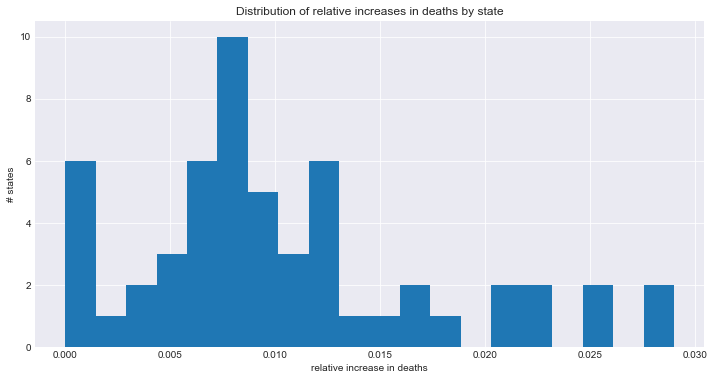

In [738]:
dfp_state_increase_m['frac_increase_deaths'].hist(bins=20)
plt.xlabel('relative increase in deaths')
plt.ylabel('# states')
plt.title('Distribution of relative increases in deaths by state')
plt.show()

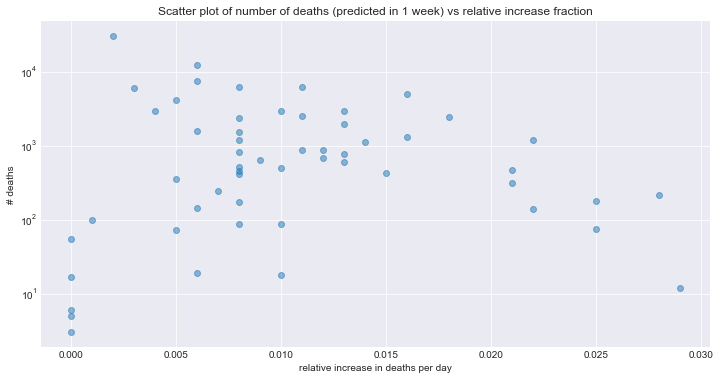

In [739]:
plt.plot(dfp_state_increase_m['frac_increase_deaths'], dfp_state_increase_m['deaths'], 'o', alpha=0.5)
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('relative increase in deaths per day')
plt.ylabel('# deaths')
plt.title('Scatter plot of number of deaths (predicted in 1 week) vs relative increase fraction')
plt.show()

<a id='state_infections_vs_wa'></a>
##### Compare US state infections against Washington

In [740]:
dfp_us_g = dfp_us_g[~(dfp_us_g['date']==datetime.datetime(2020,3,9))]

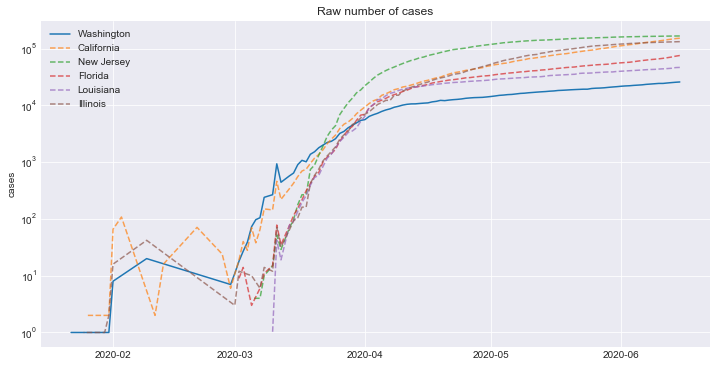

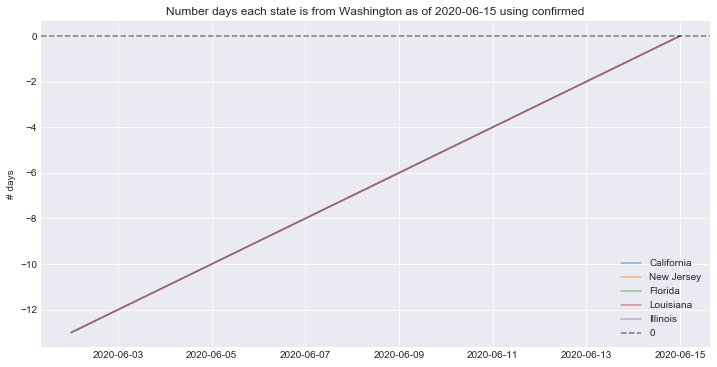

In [741]:
_ = days_behind_multi_country(['California', 'New Jersey', 'Florida', 'Louisiana', 'Illinois'], 
                              'Washington', 
                              dfp=dfp_us_g, 
                              country_col='state', 
                              compare_col='confirmed'
                             )

<a id='state_infections_vs_ny'></a>
##### Compare US state infections against New York

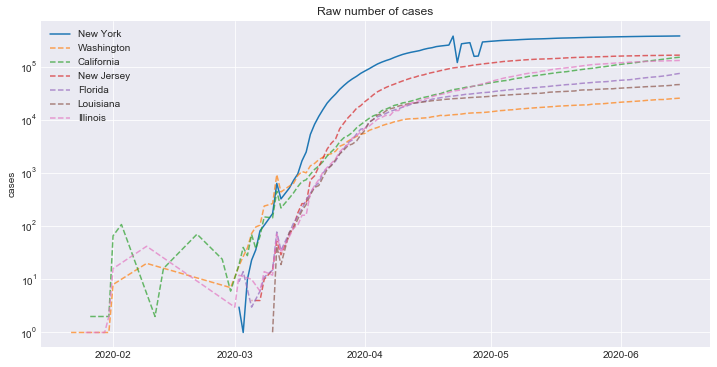

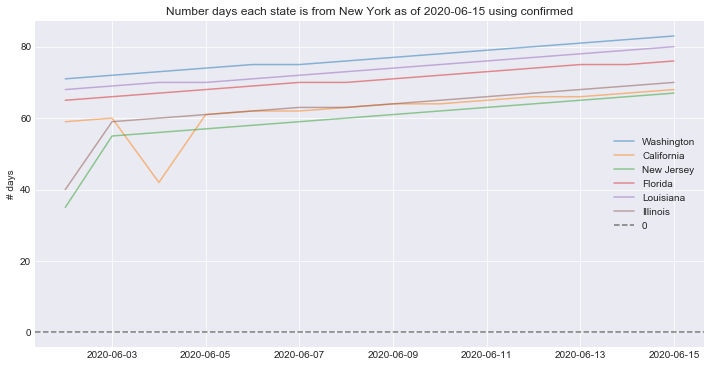

In [742]:
_ = days_behind_multi_country(['Washington', 'California', 'New Jersey', 'Florida', 'Louisiana', 'Illinois'], 
                              'New York', 
                              dfp=dfp_us_g, 
                              country_col='state', 
                              compare_col='confirmed'
                             )

<a id='mortality_by_us_state'></a>
### Mortality rate by US state

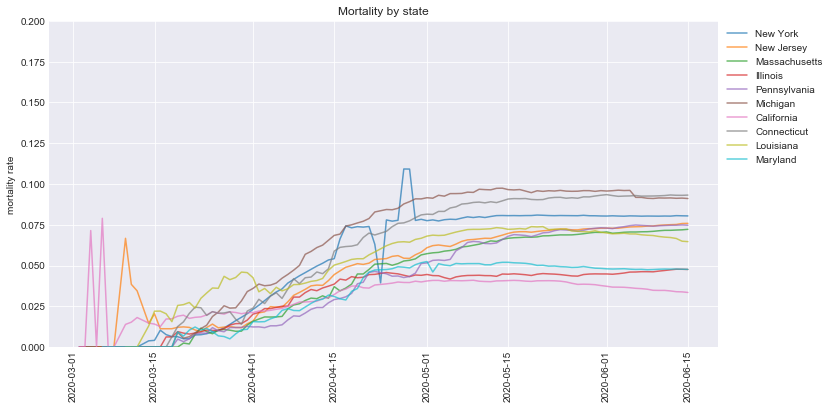

In [743]:
n_states = 10
states = dfp_us_top_states.iloc[:n_states]['state']

plot_mortality_rate(dfp_us_g, states, upper_lim=0.2, id_col='state', date_min=datetime.datetime(2020,3,2))

##### Relationship between mortality rate and number of cases

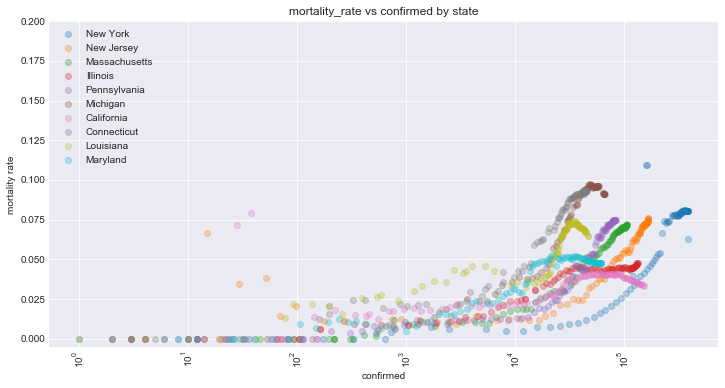

In [744]:
plot_mortality_rate_vs_infections(dfp_us_g, states, upper_lim=0.2, id_col='state', date_min=datetime.datetime(2020,3,1))

<a id='us_state_relative_increases'></a>
### Relative increases per day by state

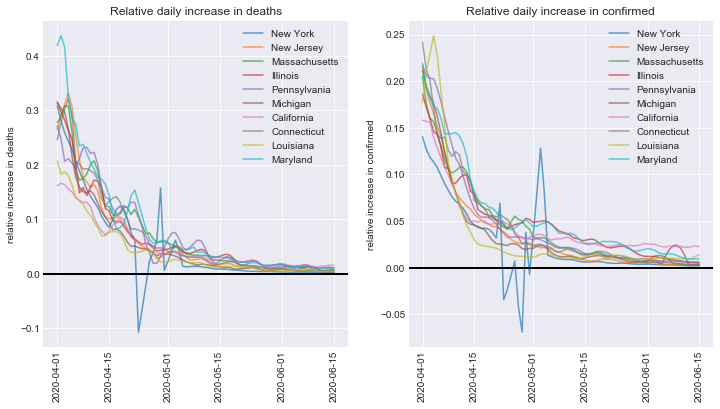

In [745]:
find_relative_increase_data_and_plot(dfp_us_g, n_locales=10, col_locale='state', dt=datetime.datetime(2020,4,1))


<a id='us_state_0_new'></a>
# When will each state hit 0 new deaths/confirmed? 

In [746]:
def fit_exp_new(dfp_country, 
            n_days_predict=14, 
            n_days_into_future=[1,7],
            col_locale='country', 
            top_countries=None, 
            n_countries=10, 
            date_most_recent=None,
            is_silent=False,
            fit_cols=['confirmed_new', 'deaths_new']
           ):
    
    # make predictions based on the last 2 weeks of data
    if date_most_recent is None:
        date_most_recent = dfp_country['date'].max()
    date_n_days_ago = date_most_recent - datetime.timedelta(days=n_days_predict-1)
    dfp_country_recent = (dfp_country[dfp_country['date'].between(date_n_days_ago, date_most_recent)].
                          sort_values(by=[col_locale, 'date'])
                         ).copy()

    # clean data for fit (convert to log)
    median_funcs = {}
    log_cols = []
    for col in fit_cols:
        log_col = f'{col}_log'
        dfp_country_recent[log_col] = dfp_country_recent[col].apply(lambda x: np.log10(x) if x > 1 else None)
        median_funcs[log_col] = np.nanmedian
        log_cols.append(log_col)
    dfp_country_recent['unixtime'] = dfp_country_recent['date'].apply(datetime_to_unixtime)
    
    # fill in the missing data with the median
    dfp_country_medians = dfp_country_recent.groupby(col_locale, as_index=False).agg(median_funcs).fillna(0)
    null_countries = list(dfp_country_recent[dfp_country_recent.isnull().any(axis=1)][col_locale].unique())
#     print(f"{col_locale}s with nulls: {','.join(null_countries)}")
#     display(dfp_country_medians.sample(n=5))
#     print(log_cols)
    for col in log_cols:
        for country in null_countries:
            val = dfp_country_medians[dfp_country_medians[col_locale] == country][col].values[0]
            #print(f"country={country}, median value={val:0.5f}")
            dfp_country_recent.loc[(dfp_country_recent[col_locale] == country) & (dfp_country_recent[col].isnull()), col] = val
    
    
    # make predictions to past, then future
    # add in future points
    dfp_country_recent_max_date = dfp_country_recent.groupby([col_locale], as_index=False).agg({'date': np.max})
    dfp_most_recent = dfp_country_recent.merge(dfp_country_recent_max_date, on=[col_locale, 'date'], how='inner').copy()
    list_dfp_recent = [dfp_country_recent]
    for n in n_days_into_future:
        dfp_most_recent_tmp = shift_future(dfp_most_recent, date_most_recent, n, cols_to_be_null_in_future=fit_cols)
        list_dfp_recent.append(dfp_most_recent_tmp)
    dfp_country_recent = pd.concat(list_dfp_recent, axis=0, sort=False)
    
    for col in fit_cols:
        dfp_country_recent, dfp_country_deaths_fit = fit_poly1(dfp_country_recent, 
                                                               col_fit=f'{col}_log', 
                                                               col_pred=f'{col}_pred', 
                                                               col_locale=col_locale, 
                                                               date_most_recent=date_most_recent
                                                              )
    #dfp_country_recent['mortality_rate_pred'] = dfp_country_recent['deaths_pred'] / dfp_country_recent['confirmed_pred']

    # look only at the predictions for top countries
    if top_countries is None:
        top_countries = (dfp_most_recent.
                         sort_values(by='deaths', ascending=0).iloc[:n_countries][col_locale].values)
    dfp_forecasts = dfp_country_recent[(dfp_country_recent['date'] > date_most_recent)
                                       
                                      ].sort_values(by=[col_locale, 'date']).reset_index(drop=True)
    frac_cols = [col for col in dfp_forecasts.columns if 'frac_increase' in col]
    pred_cols = [col for col in dfp_forecasts.columns if '_pred' in col]
    id_cols = ['date', col_locale]
    dfp_forecasts_out = dfp_forecasts[id_cols + pred_cols + frac_cols].copy()
    dfp_forecasts_out['date'] = dfp_forecasts_out['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

    # find the daily fractional increase in cases
    dfp_frac_increase = (dfp_forecasts_out.
                         groupby([col_locale]).
                         agg({x: np.mean for x in frac_cols}))
    dfp_frac_increase.columns = pd.MultiIndex.from_product([dfp_frac_increase.columns, ['']])

    # pivot so each date of prediction has its own column
    dfp_forecasts_print = dfp_forecasts_out.pivot(index=col_locale, 
                                                  columns='date', 
                                                  values=pred_cols  #'mortality_rate_pred'
                                                 ).sort_values(by=(pred_cols[0], dfp_forecasts_out['date'].min()), ascending=0)
    dfp_forecasts_print = dfp_forecasts_print.merge(dfp_frac_increase, on=col_locale, how='inner')
    if not is_silent:
        display(dfp_forecasts_print[dfp_forecasts_print.index.isin(top_countries)])
    return dfp_country_recent, dfp_forecasts_out


def plot_forecasts_new(dfp_country_recent, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='country',
                       top_countries=None,
                       cols_to_pred=['confirmed_new', 'deaths_new'],
                       cols_deaths='deaths_new',
                  ):
    # subset the top countries
    death_cols = [col for col in cols_to_pred if 'deaths' in col]
    dfp_non_pred = dfp_country_recent.dropna(subset=[death_cols[0]])
    dt_max = dfp_non_pred['date'].max()
    
    if top_countries is None:
        dfp_top_countries = (dfp_non_pred[dfp_non_pred['date'] == dt_max].
                             sort_values(by=death_cols[0], ascending=0).
                             iloc[:n_countries]
                            )
        top_countries = (dfp_top_countries.
                         iloc[:n_countries][col_locale].values
                        )
    else:
        n_countries = len(top_countries)
        
    dfp_country_recent = dfp_country_recent[dfp_country_recent[col_locale].isin(top_countries)]

    # plot the top countries
    i = 1
    n_rows = int(np.ceil(n_countries / n_columns))
    plt.figure(figsize=figsize)
    
    y_max = 1
    pred_cols = [x + '_pred' for x in cols_to_pred]
    for col in cols_to_pred:
        y_max = max(dfp_country_recent[col].max(), y_max)
    y_min = 1

    for country in top_countries:
        dfp_plot = dfp_country_recent[(dfp_country_recent[col_locale] == country) &
                               (dfp_country_recent['date'] >= date_min)
                              ].sort_values(by='date')
        
        # find total deaths
        dfp_plot_calcs = dfp_plot.dropna(subset={cols_deaths})
        dfp_plot_latest = dfp_plot_calcs[dfp_plot_calcs['date'] == dfp_plot_calcs['date'].max()]
        x = 1 + dfp_plot_calcs['frac_increase_deaths'].mean()
        n_days = (dfp_country_recent['date'].max() - dfp_plot_calcs['date'].max()).days
        multiplier = (x**n_days - 1) / (x - 1)
        curr_deaths_new = dfp_plot_latest[f'{cols_deaths}_pred'].values[0]
        curr_deaths_total = dfp_plot_latest['deaths'].values[0]
        n_deaths_pred = curr_deaths_new * multiplier + curr_deaths_total
        
        
        plt.subplot(n_rows, n_columns, i)
        for key in cols_to_pred:
            p = plt.plot(dfp_plot['date'], dfp_plot[key], alpha=0.5, linewidth=2, label=key)
            pred_col = f'{key}_pred'
            plt.plot(dfp_plot['date'], dfp_plot[pred_col], linestyle='--', linewidth=2, alpha=0.5, color=p[0].get_color(), label=pred_col)
        plt.legend(loc='best')
        plt.ylabel('num cases')
        plt.title(f'{col_locale}: {country}, pred_tot_deaths = {n_deaths_pred:0.0f}, curr_deaths = {curr_deaths_total:0.0f}, x={x:0.3f}')
        plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()
    return None
                       
                       
def save_forecast_new(dfp_forecasts_out, dfp_country_recent, col_locale='state', n_days_training=14):
    date_most_recent = dfp_country_recent.dropna(subset=['deaths'])['date'].max()
    dfp_forecasts_out['date_of_forecast'] = date_most_recent
    save_name = f"new_cases_covid-19_{col_locale}_forecast_from_{date_most_recent.strftime('%Y-%m-%d')}_n_days_training={n_days_training}.csv"
    save_path = os.path.join('predictions', save_name)
    dfp_forecasts_out.to_csv(save_path, index=False)
    print(f'saved forecast to {save_path}')
    return None

In [747]:
n_days_training = 21
dfp_us_g['deaths_new_smooth'] = dfp_us_g.groupby(['country', 'state'], as_index=False)['deaths_new'].rolling(7).mean().reset_index(0,drop=True)
dfp_us_g['confirmed_new_smooth'] = dfp_us_g.groupby(['country', 'state'], as_index=False)['confirmed_new'].rolling(7).mean().reset_index(0,drop=True)
dfp_us_recent_1, dfp_forecasts_us_out_1 = fit_exp_new(dfp_us_g, 
                                                    n_days_predict=n_days_training,
                                                    n_days_into_future=[1,7,2*7,4*7,8*7,12*7,16*7,20*7,24*7,32*7], 
                                                    col_locale='state', 
                                                    top_countries=None,
                                                      fit_cols=['confirmed_new_smooth', 'deaths_new_smooth'],
                                                   )

confirmed_new_smooth_pred                                   \
date                         2020-06-16 2020-06-22 2020-06-29 2020-07-13   
state                                                                      
California                         3172       3526       3990       5107   
New York                            731        575        434        247   
Illinois                            651        460        306        136   
Michigan                            595        662        749        960   
Maryland                            562        469        380        249   
Louisiana                           462        496        538        634   
Pennsylvania                        452        389        326        229   
New Jersey                          376        279        197         98   
Massachusetts                       373        278        197         99   
Connecticut                         150        115         85         46   

                                                                      \
date          2020-08-10 2020-09-07 2020-10-05 2020-11-02 2020-11-30   
state                                                                  
California          8368      13710      22462      36803      60299   
New York              80         26          8          2          0   
Illinois              26          5          1          0          0   
Michigan            1579       2595       4264       7009      11518   
Maryland             107         46         20          8          3   
Louisiana            880       1221       1695       2352       3263   
Pennsylvania         113         55         27         13          6   
New Jersey            24          6          1          0          0   
Massachusetts         25          6          1          0          0   
Connecticut           13          4          1          0          0   

                         deaths_new_smooth_pred                        \
date          2021-01-25             2020-06-16 2020-06-22 2020-06-29   
state                                                                   
California        161865                     68         70         73   
New York               0                     61         50         40   
Illinois               0                     62         56         50   
Michigan           31109                     33         31         28   
Maryland               0                     27         24         21   
Louisiana           6281                     14         13         12   
Pennsylvania           1                     38         31         24   
New Jersey             0                     65         59         53   
Massachusetts          0                     42         34         27   
Connecticut            0                     14         10          7   

                                                                      \
date          2020-07-13 2020-08-10 2020-09-07 2020-10-05 2020-11-02   
state                                                                  
California            79         92        107        126        147   
New York              26         10          4          1          0   
Illinois              40         26         16         10          6   
Michigan              23         16         11          8          5   
Maryland              16          9          5          3          1   
Louisiana             10          7          5          3          2   
Pennsylvania          14          5          1          0          0   
New Jersey            44         29         19         13          8   
Massachusetts         16          6          2          0          0   
Connecticut            3          0          0          0          0   

                                    frac_increase_confirmed  \
date          2020-11-30 2021-01-25                           
state                                                         
California  

In [748]:
#dfp_us_recent_1[dfp_us_recent_1.date == '2020-05-29'].sort_values(by='deaths_new_pred', ascending=0).reset_index(drop=True)

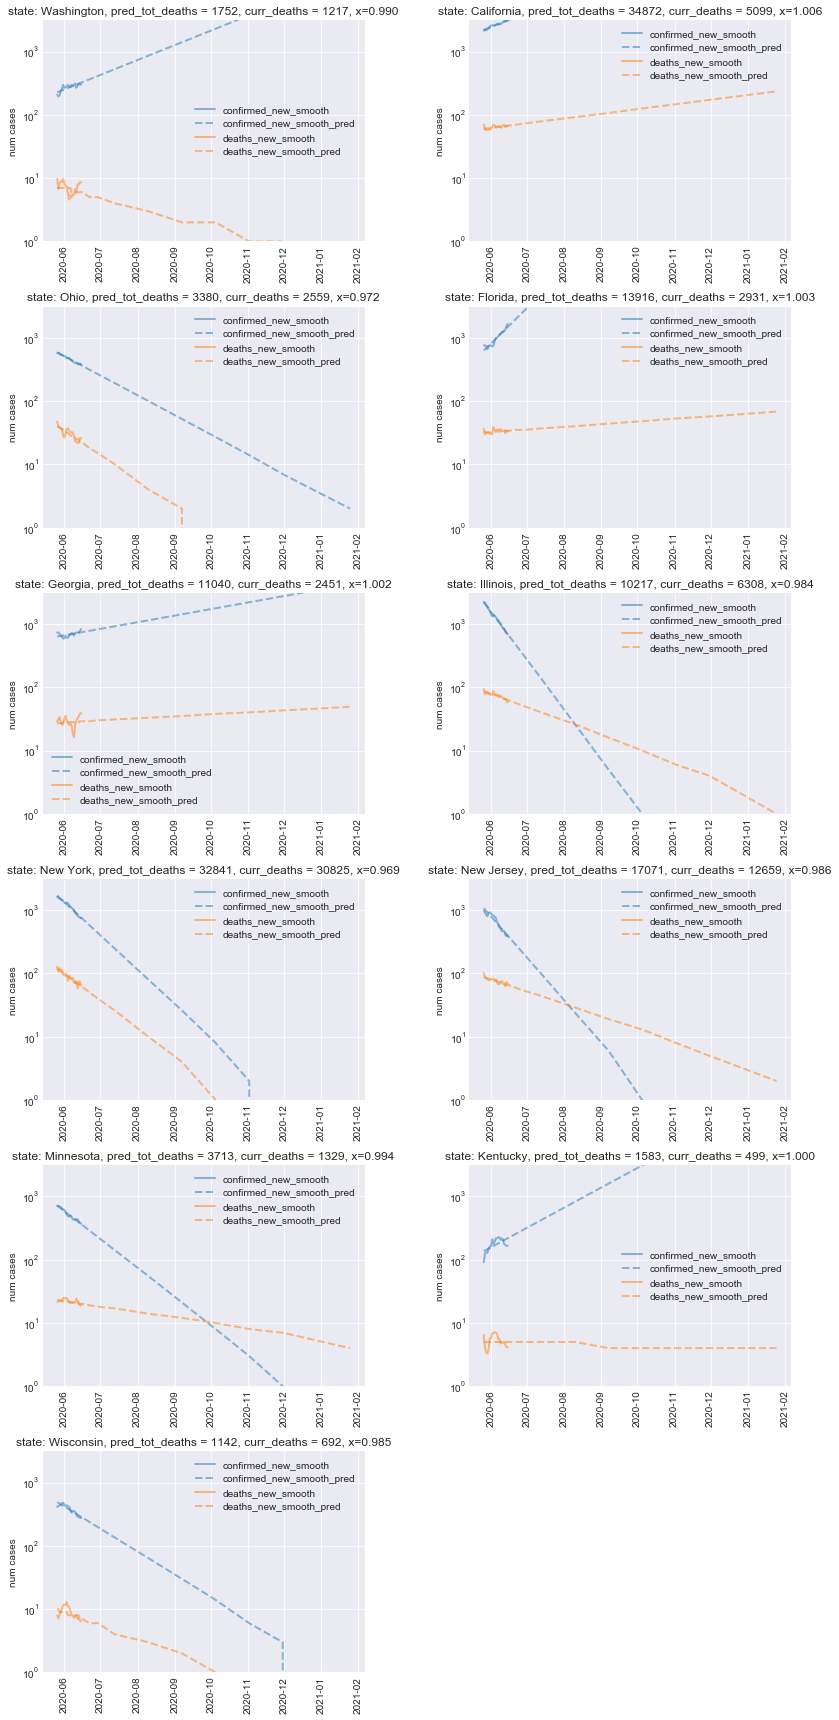

In [749]:
plot_forecasts_new(
    dfp_us_recent_1, 
    col_locale='state', 
    top_countries=['Washington', 'California', 'Ohio', 'Florida', 'Georgia', 'Illinois', 'New York', 'New Jersey', 'Minnesota', 'Kentucky', 'Wisconsin'],
    cols_to_pred=['confirmed_new_smooth', 'deaths_new_smooth'],
    cols_deaths='deaths_new_smooth',
)

In [750]:
save_forecast_new(dfp_forecasts_us_out_1, dfp_us_recent_1, 'state', n_days_training=n_days_training)

saved forecast to predictions/new_cases_covid-19_state_forecast_from_2020-06-15_n_days_training=21.csv


<a id='us_state_smoothed_trend'></a>
### Plot trends

In [751]:
dfp_us_g_new_confirmed = dfp_us_g[dfp_us_g['date'] > datetime.datetime(2020,4,1)].groupby('state', as_index=False).agg({'confirmed_new': np.sum})
states_minimum_thresh = dfp_us_g_new_confirmed[(dfp_us_g_new_confirmed['confirmed_new'] > 100)].state

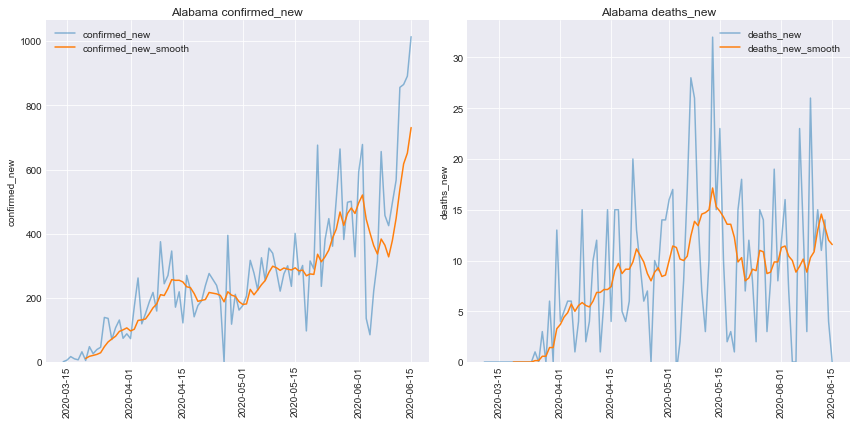

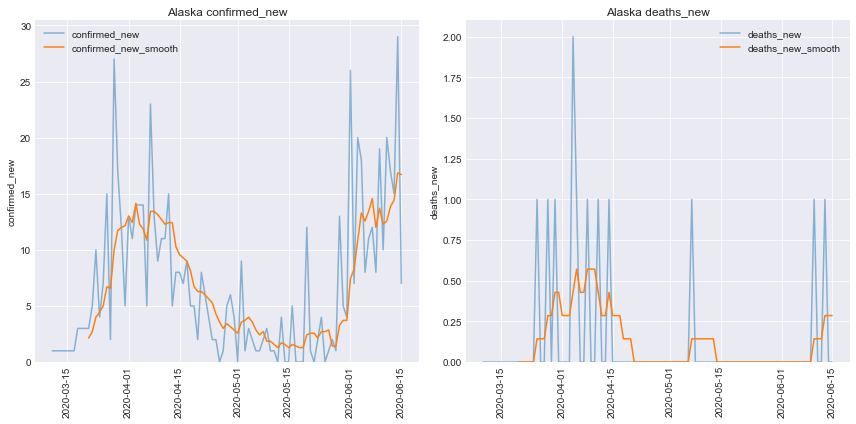

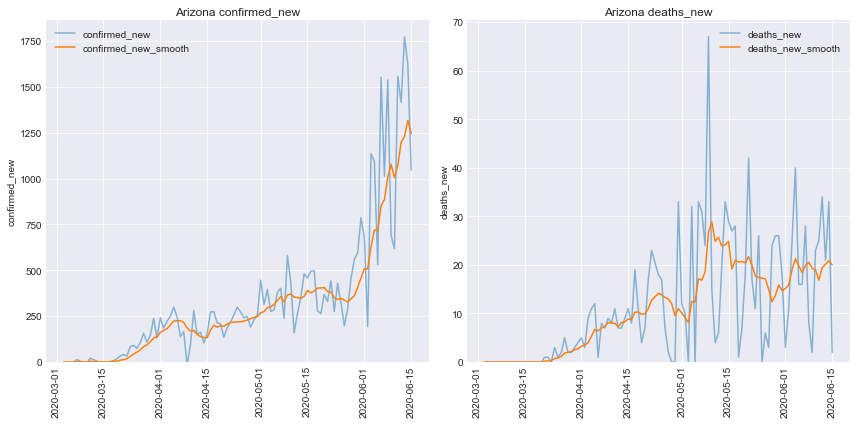

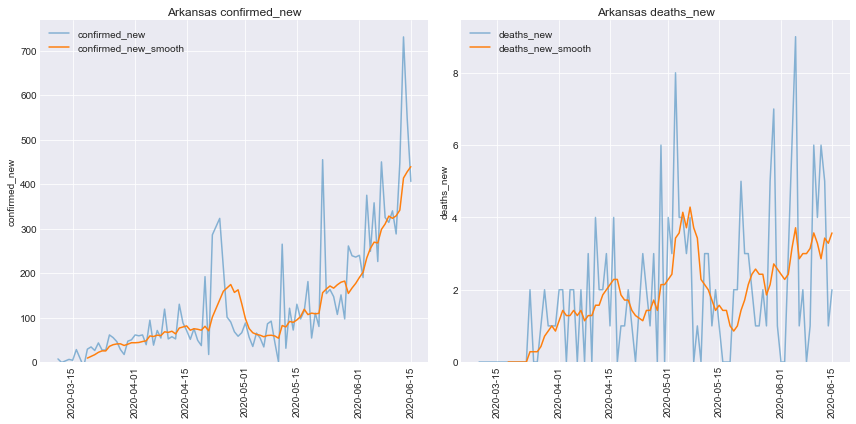

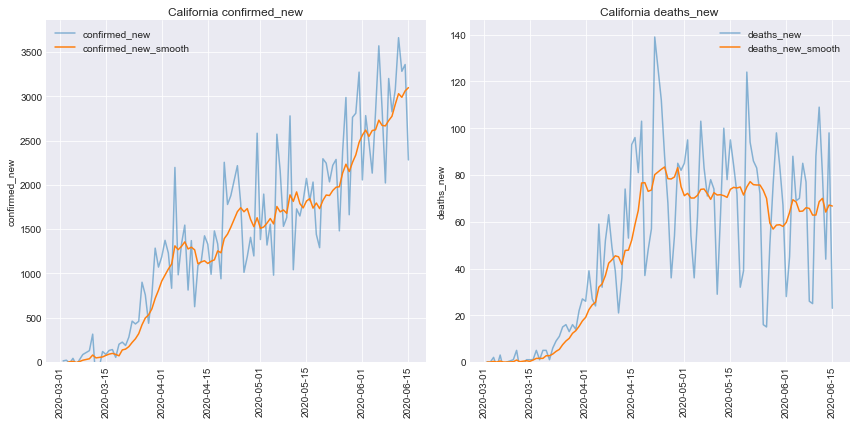

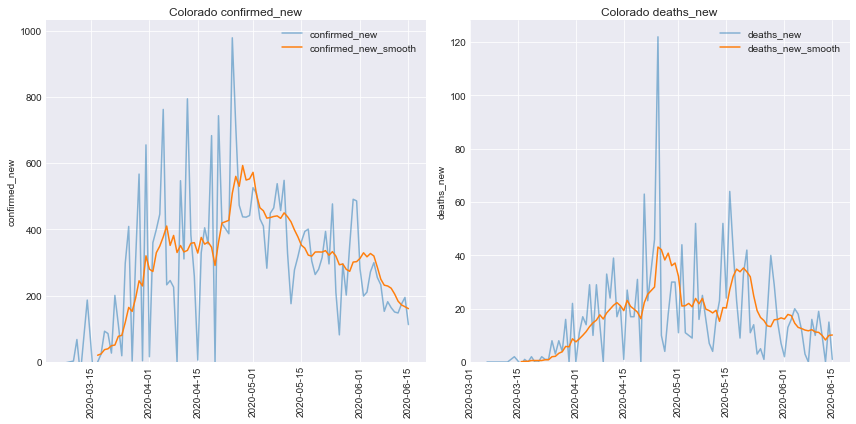

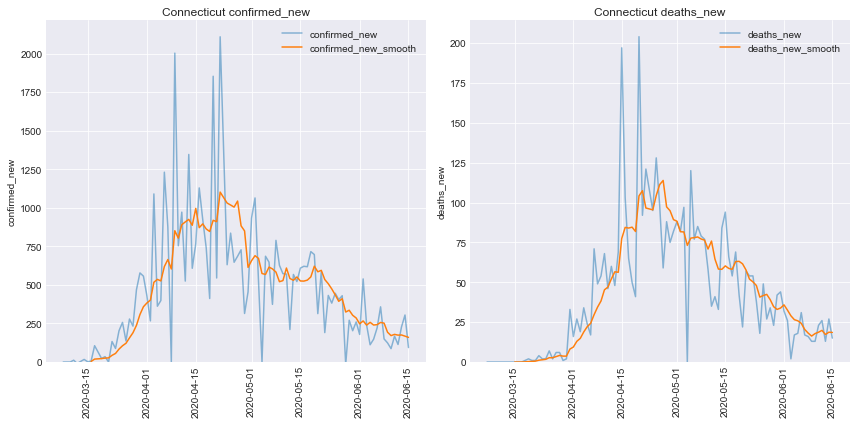

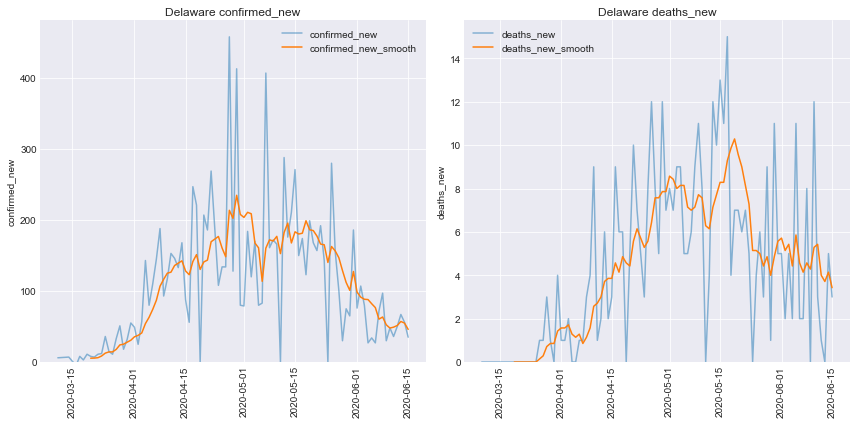

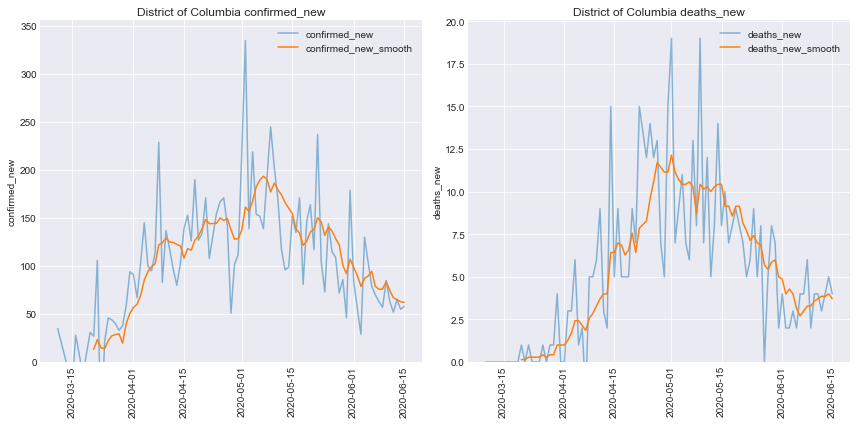

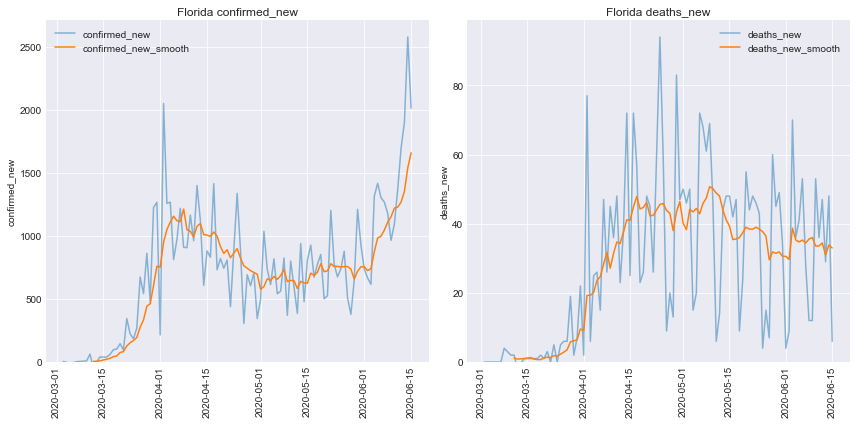

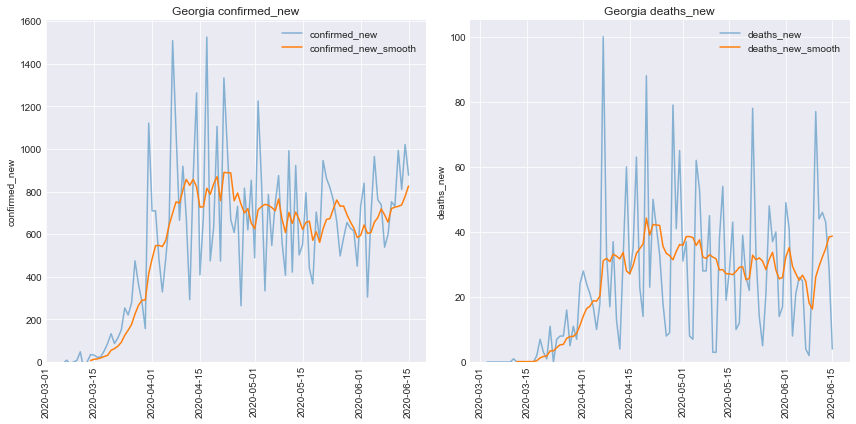

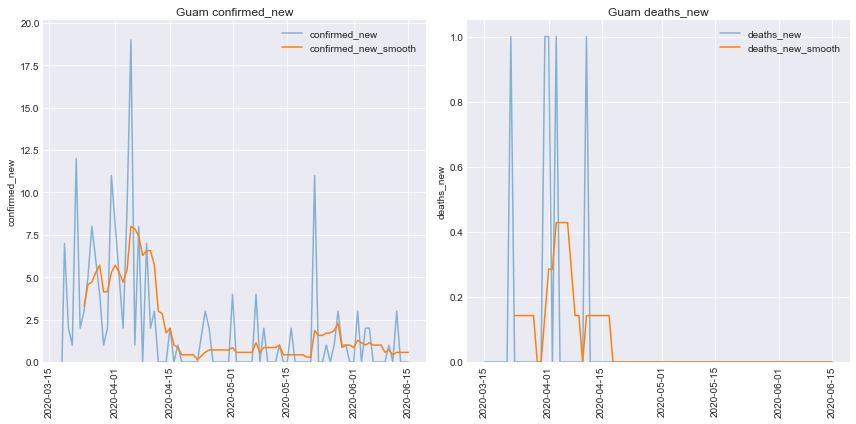

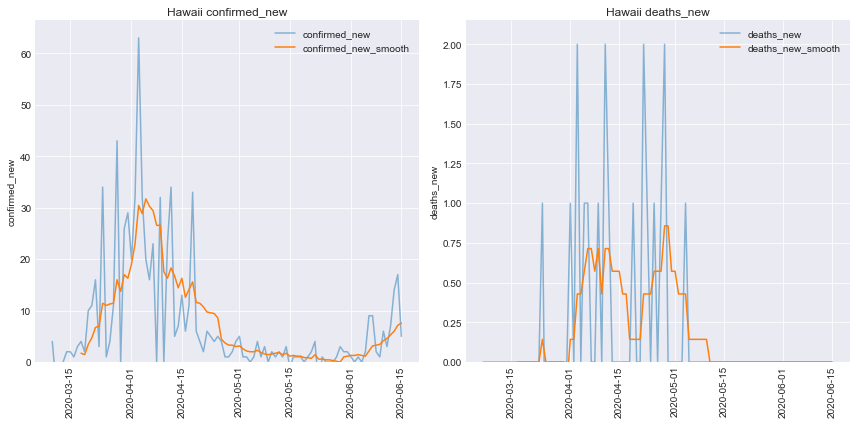

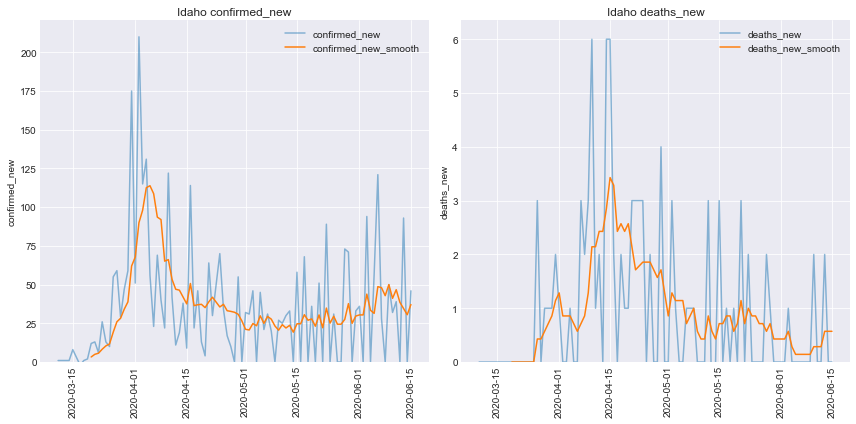

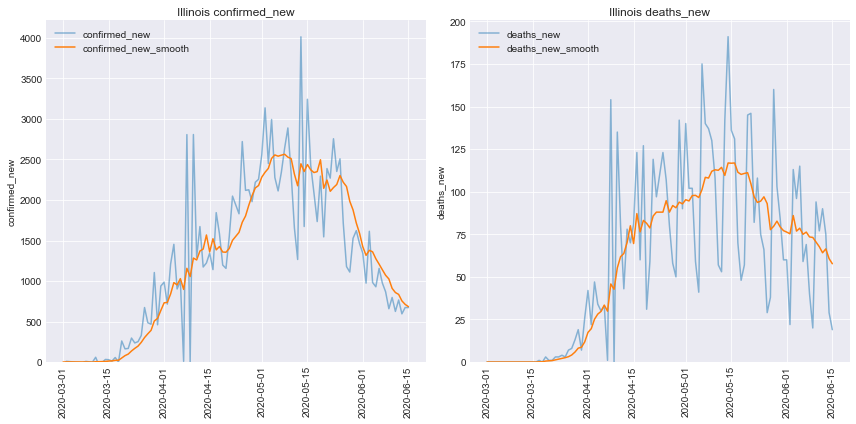

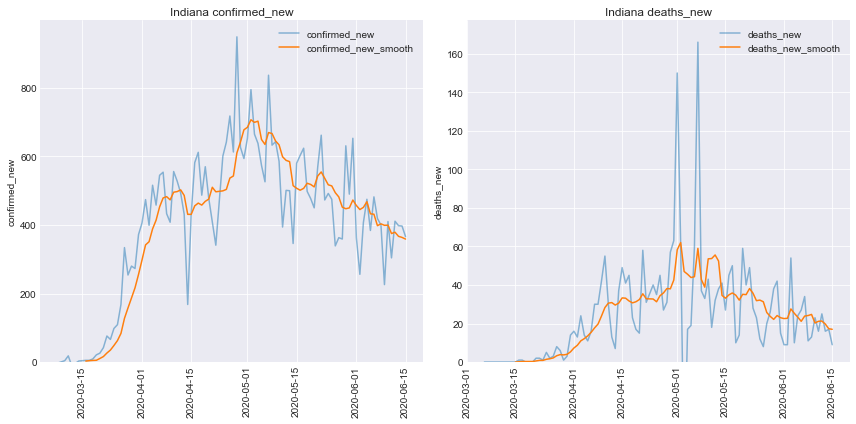

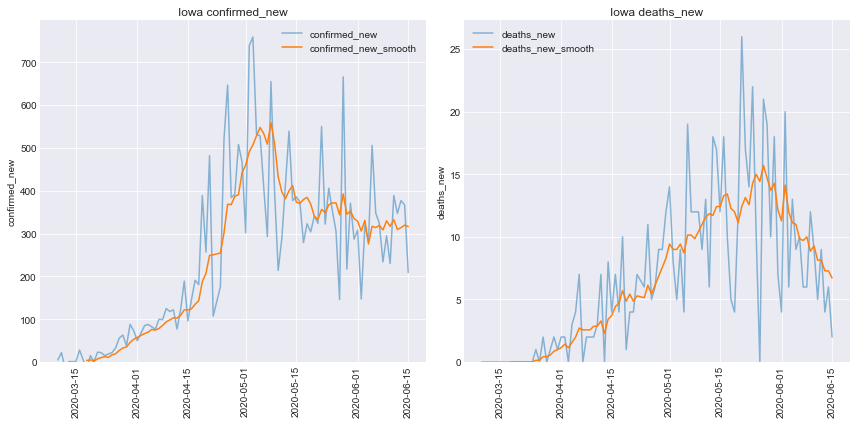

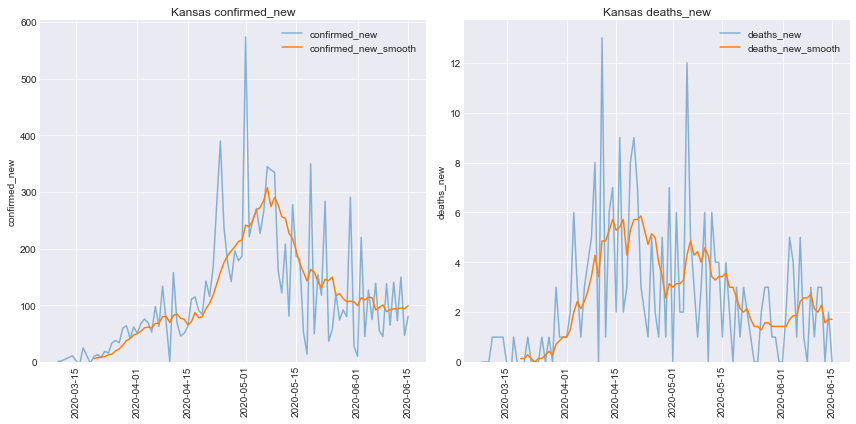

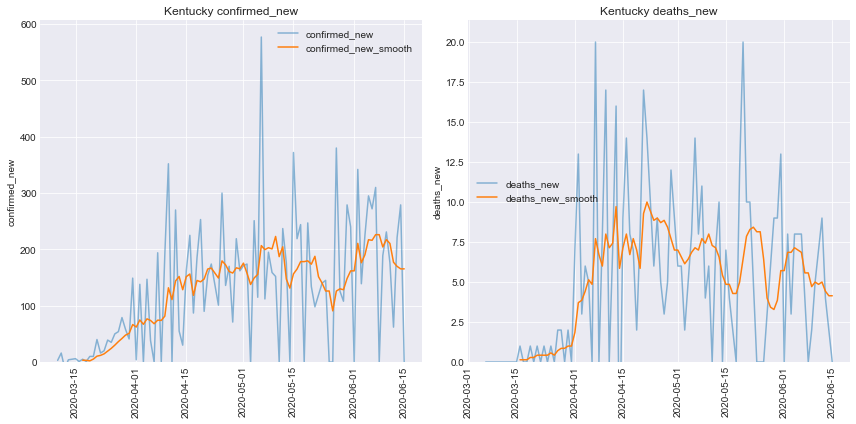

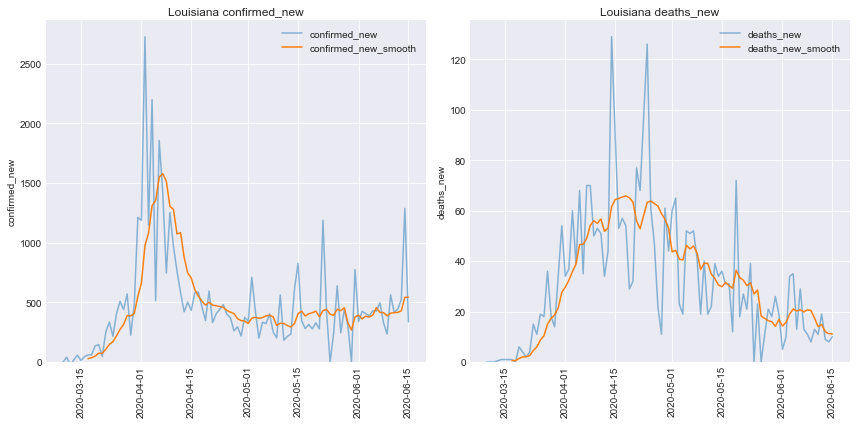

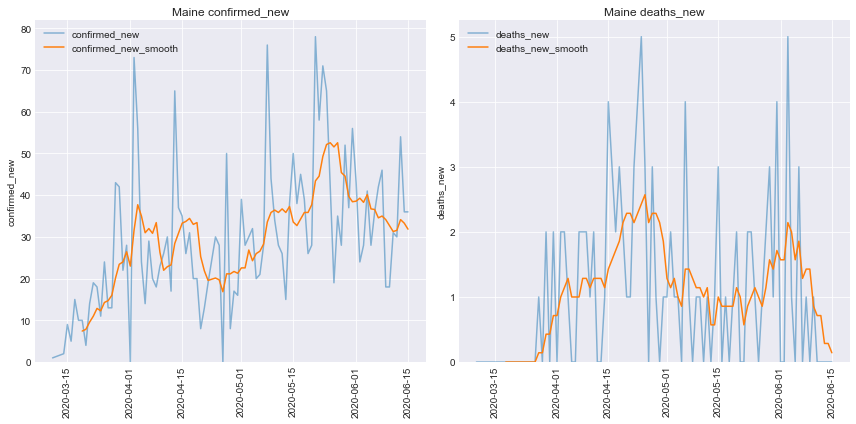

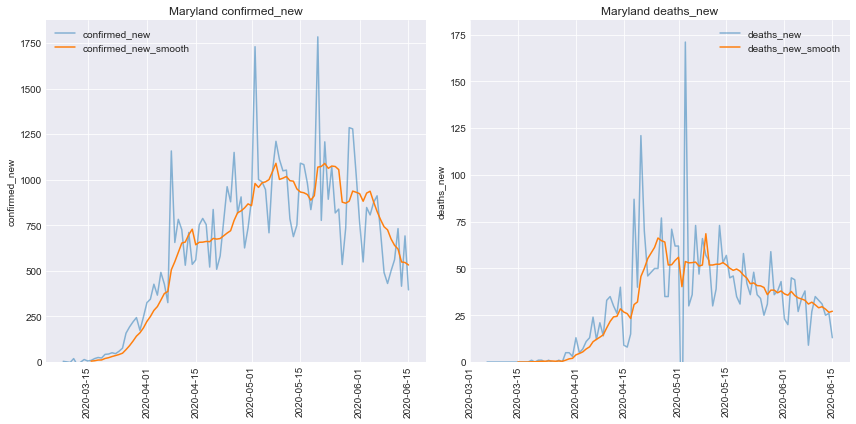

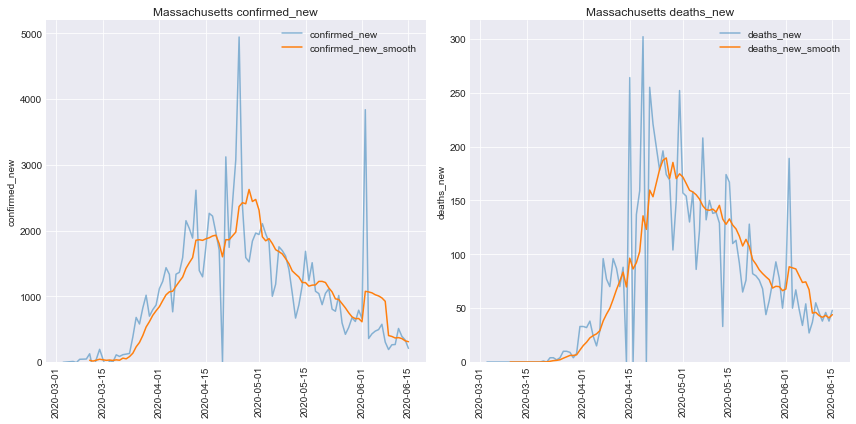

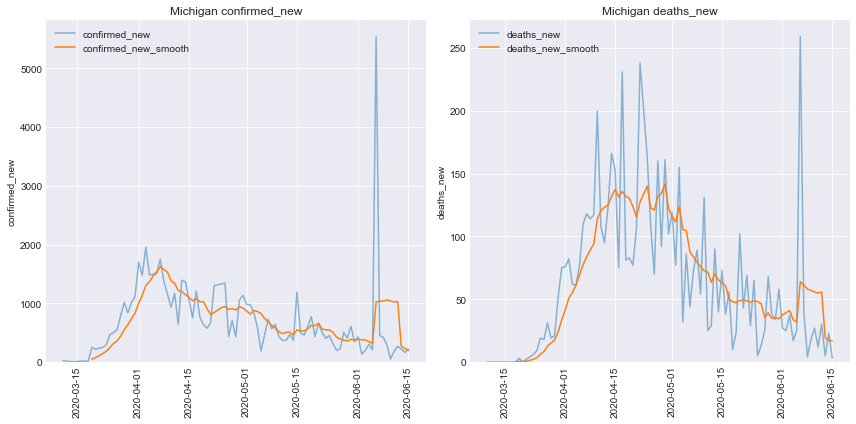

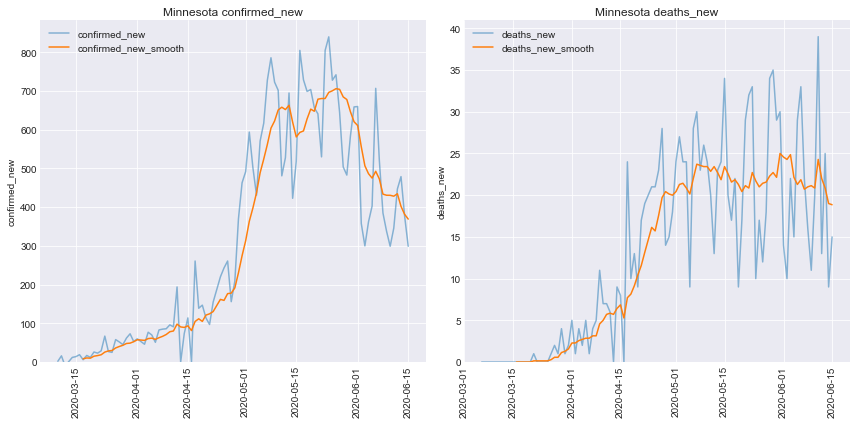

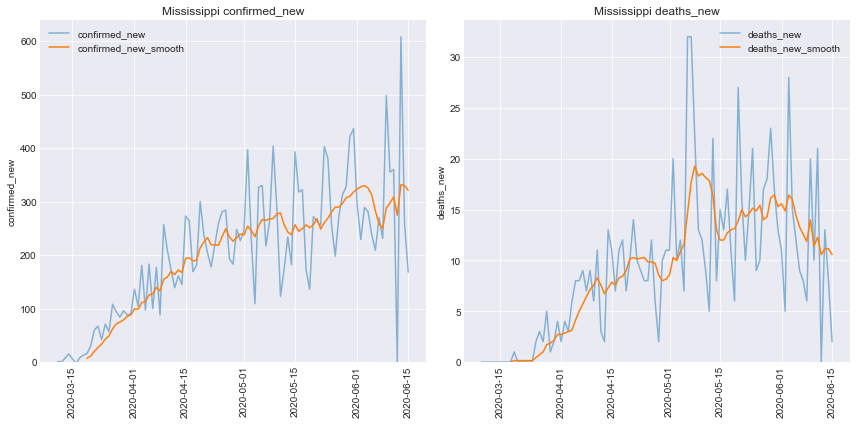

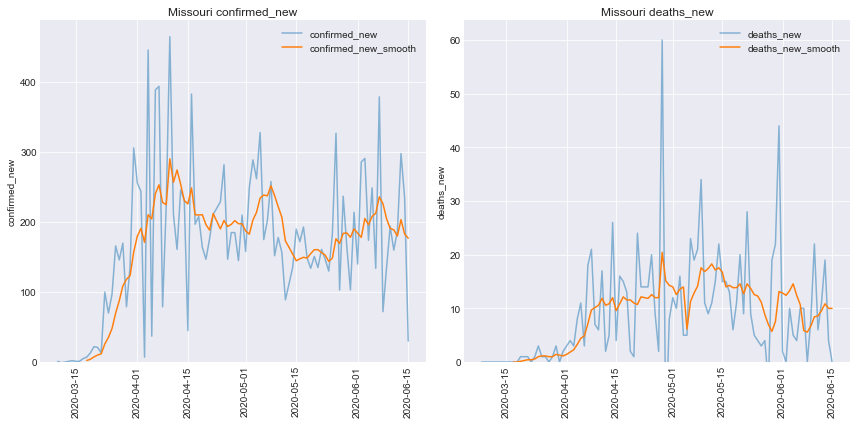

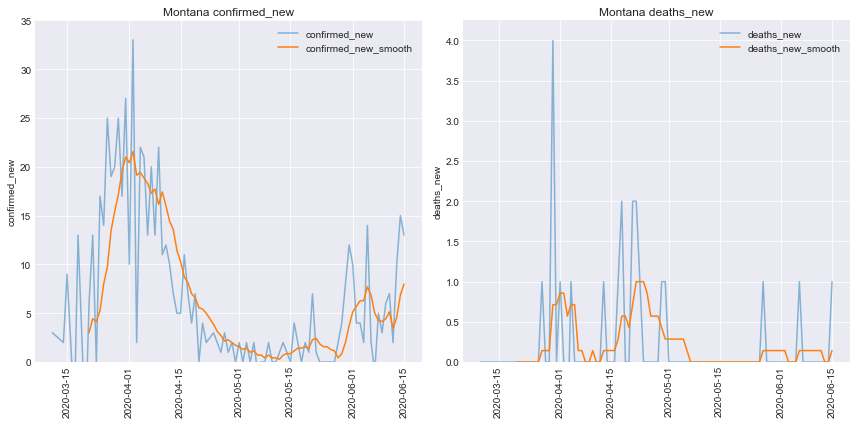

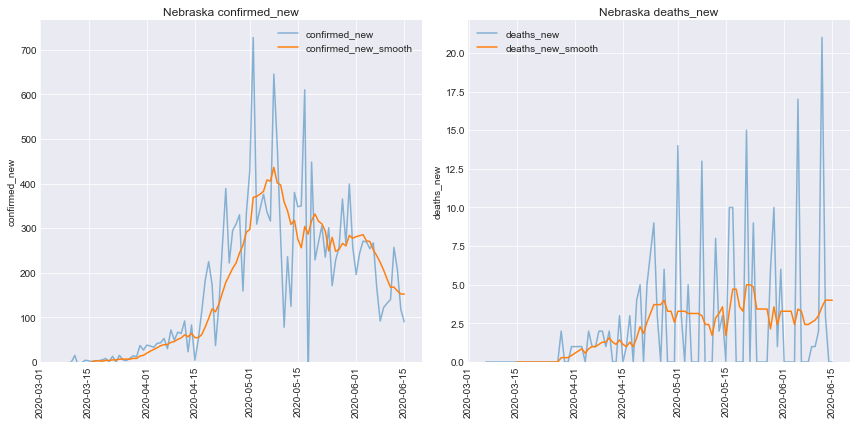

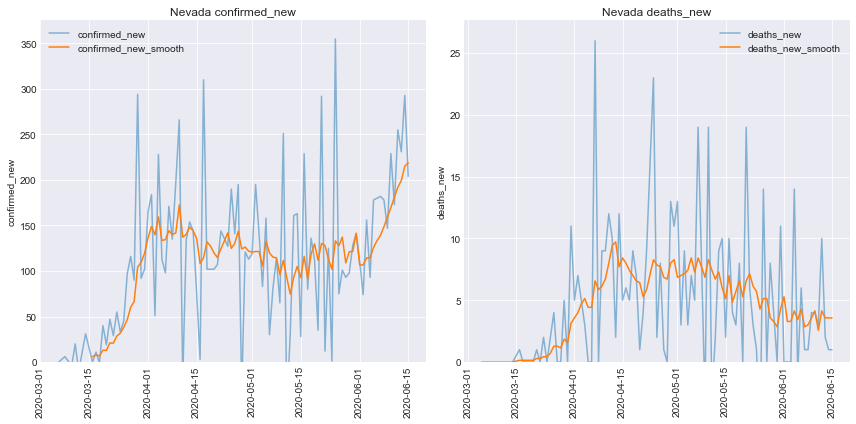

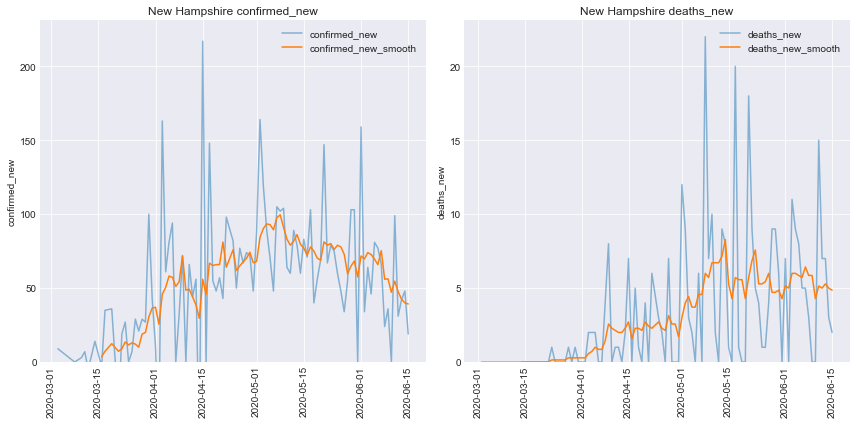

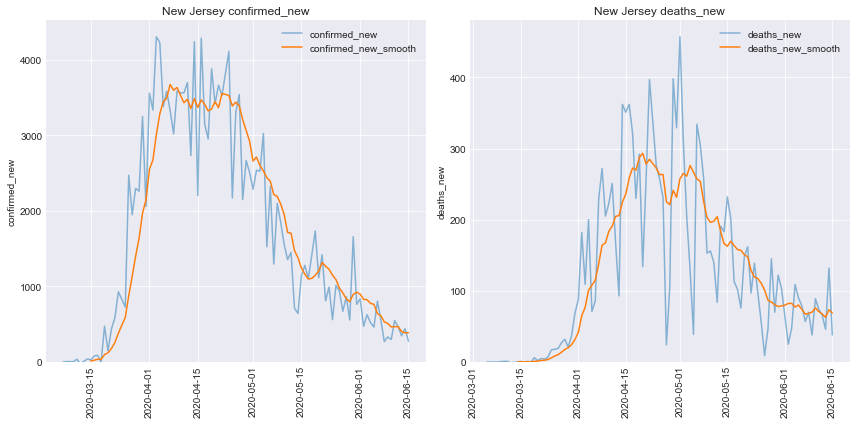

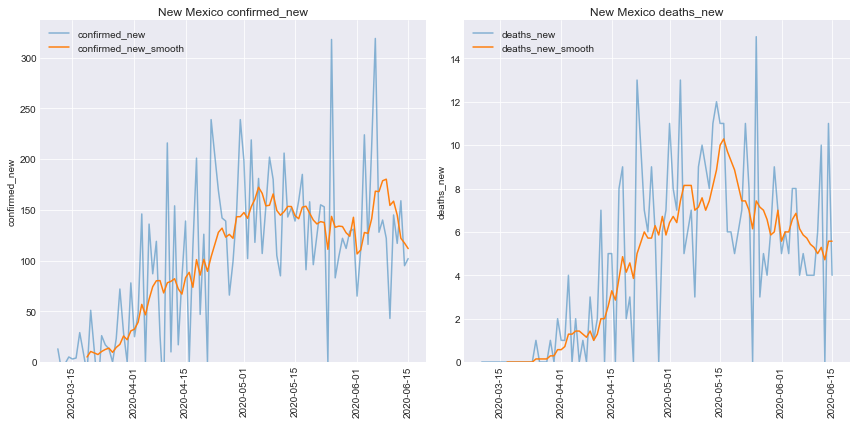

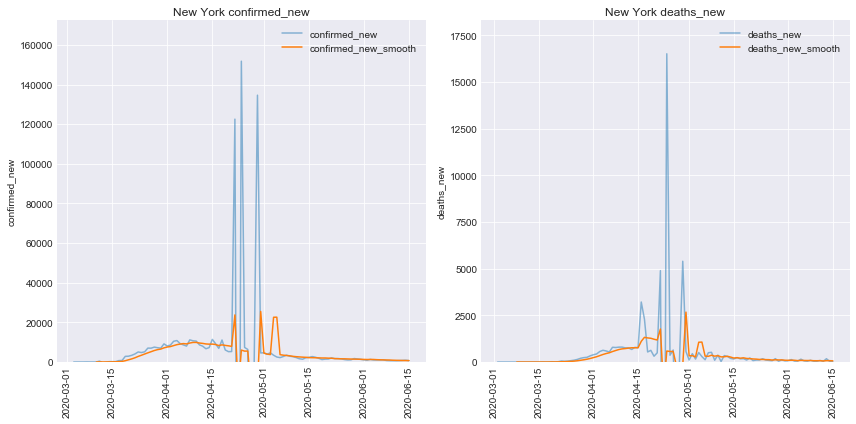

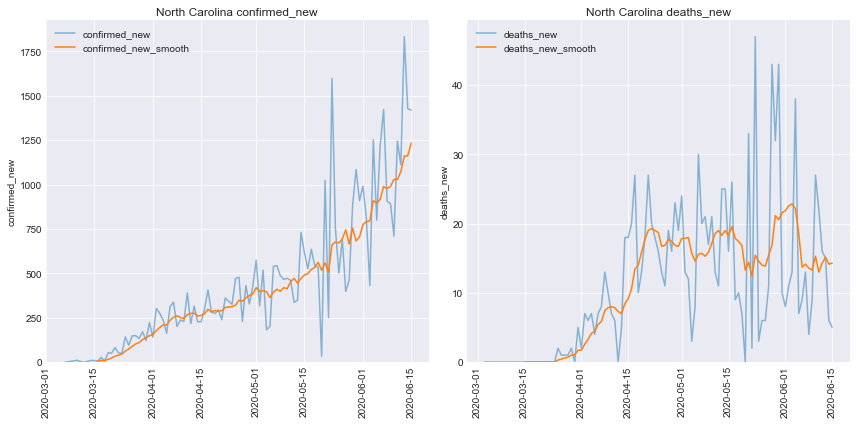

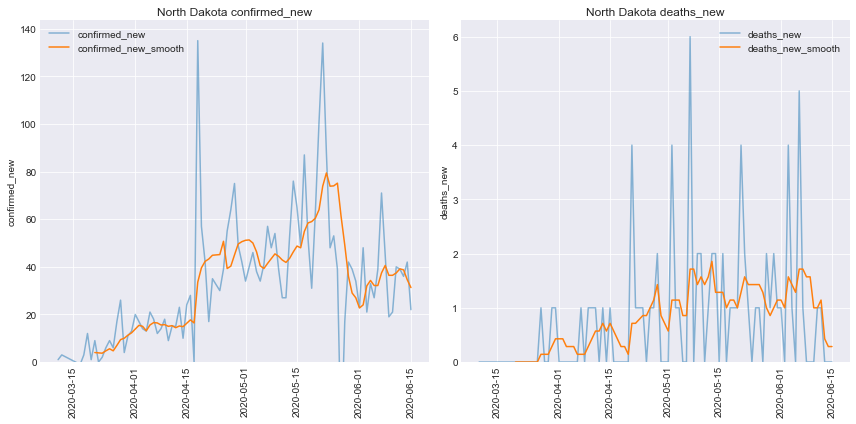

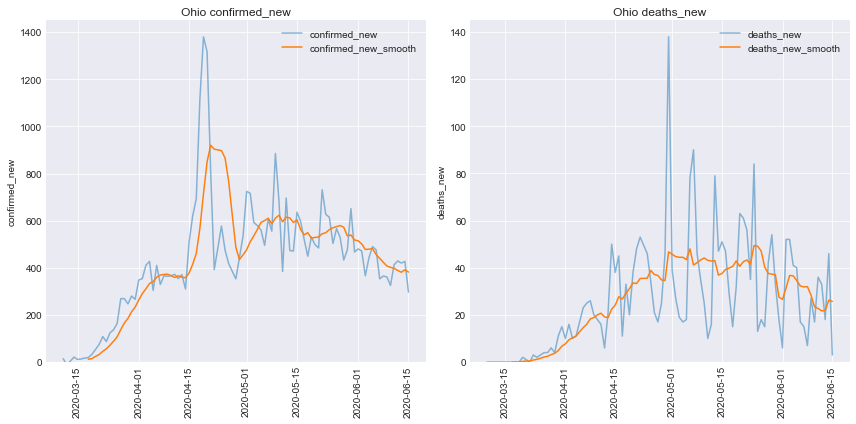

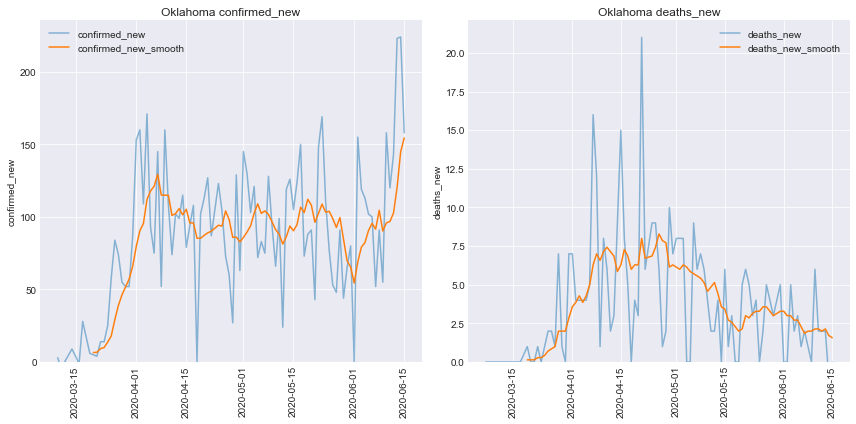

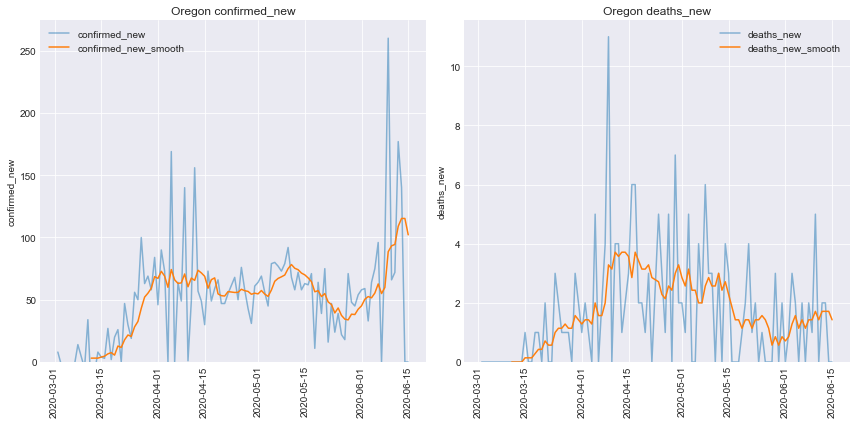

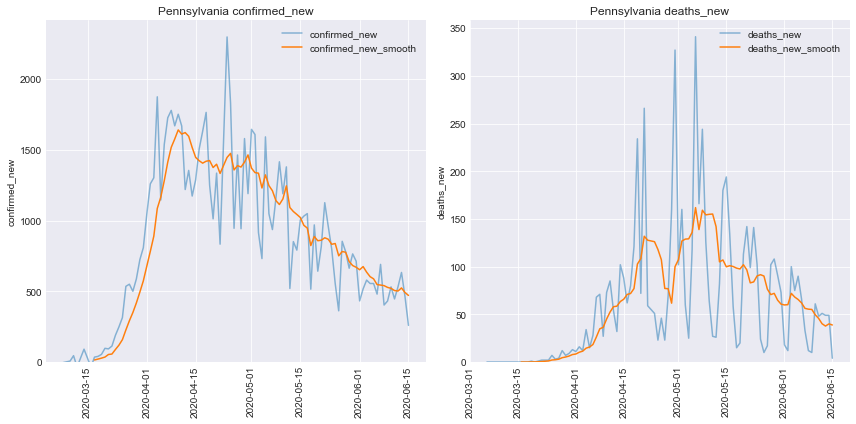

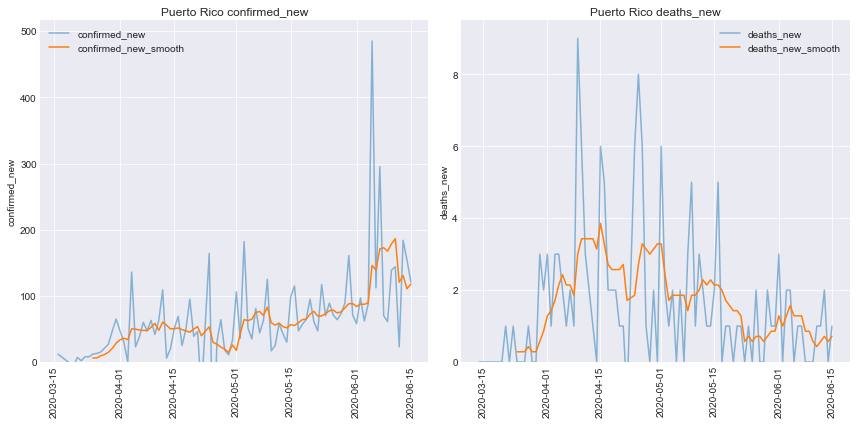

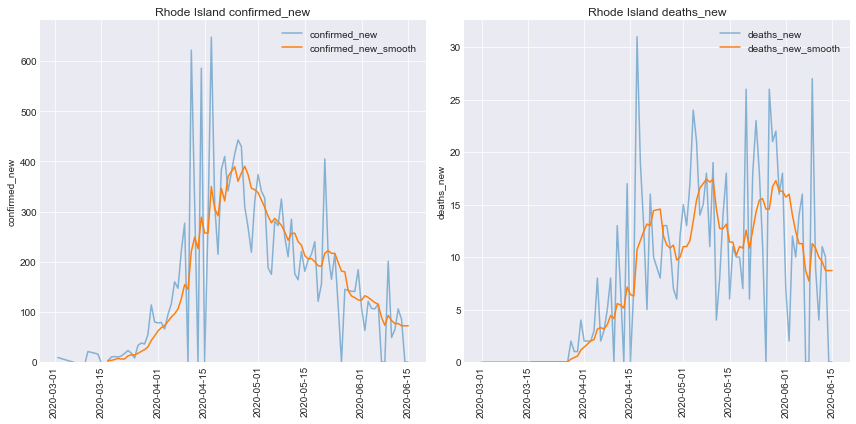

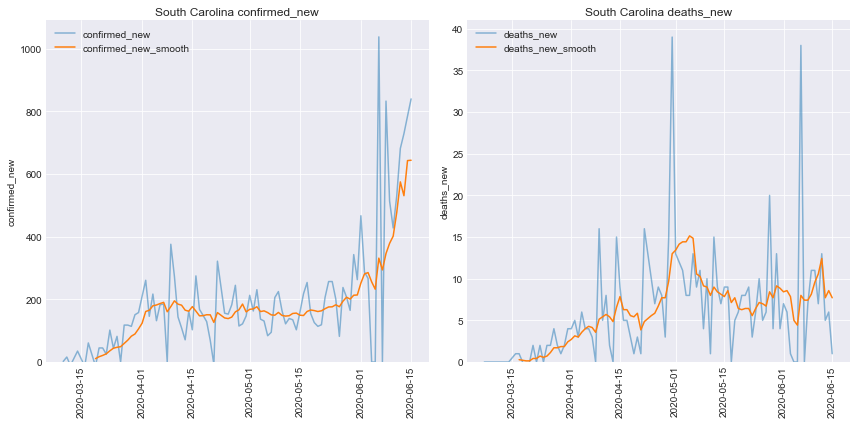

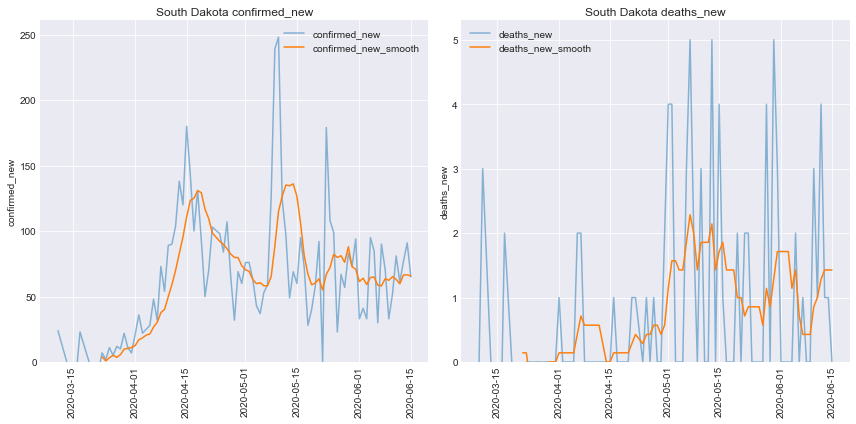

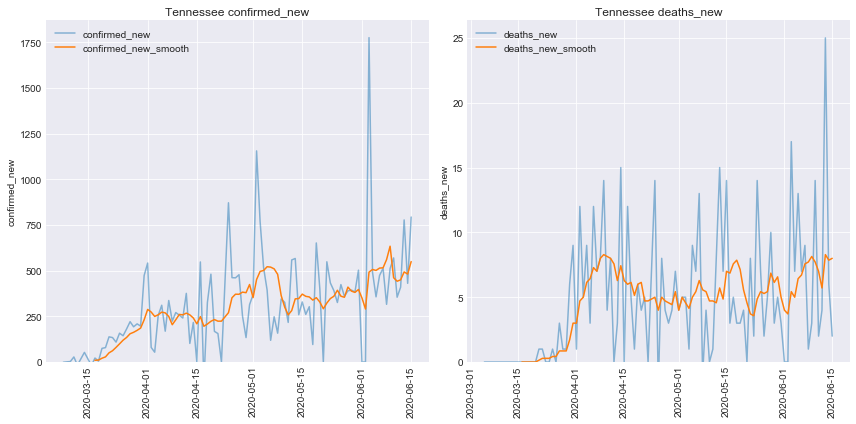

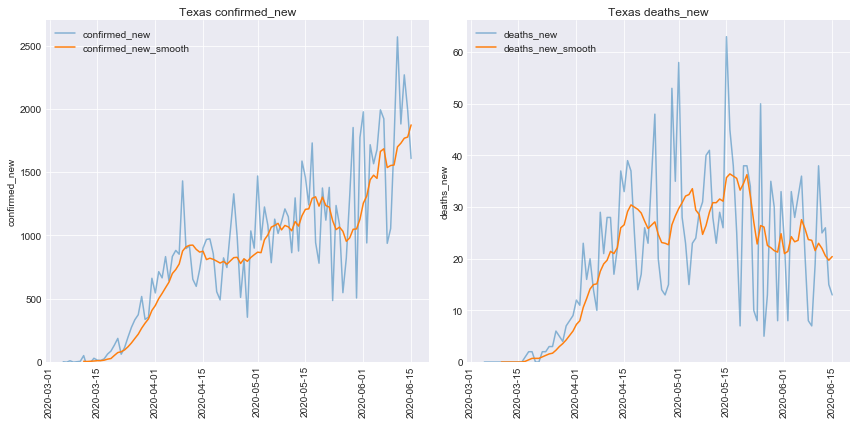

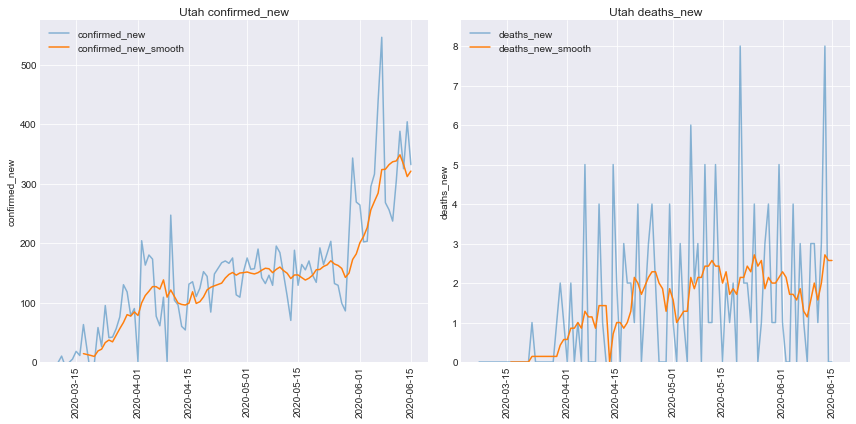

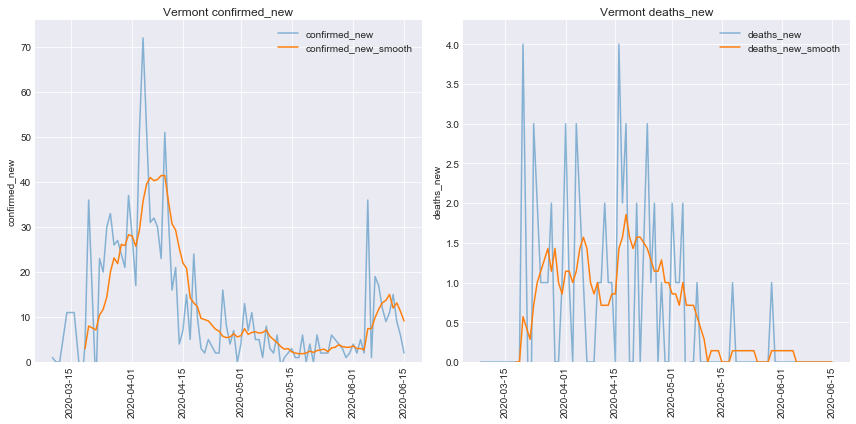

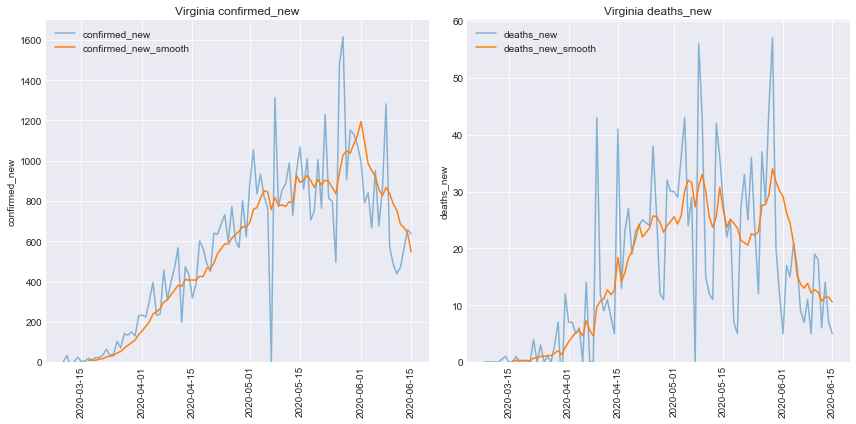

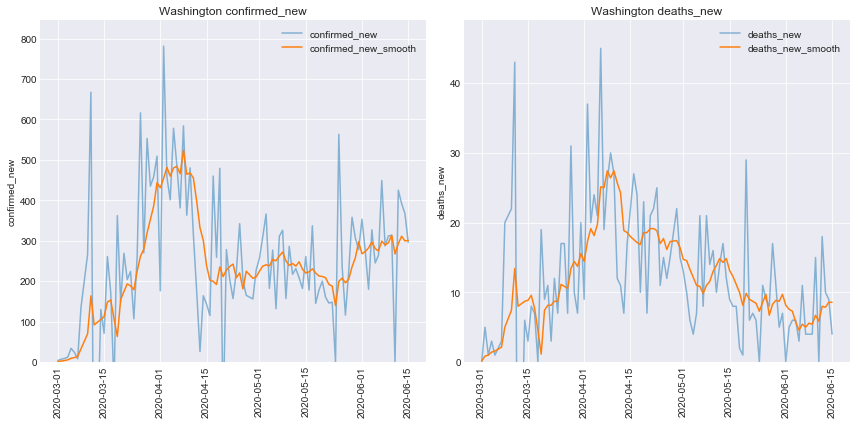

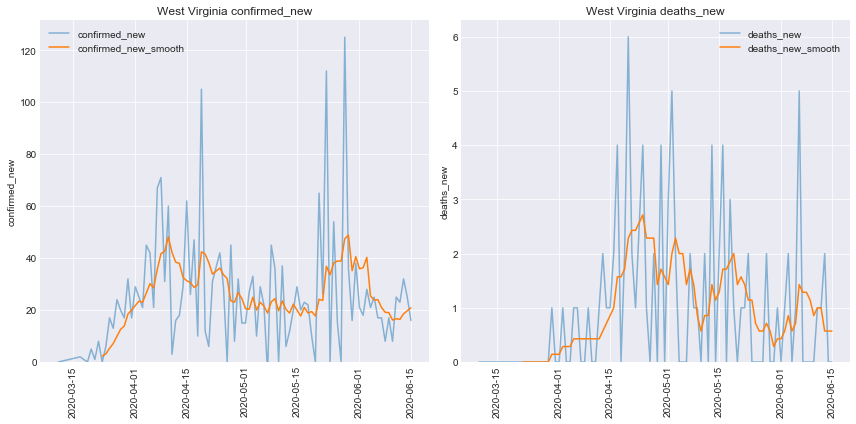

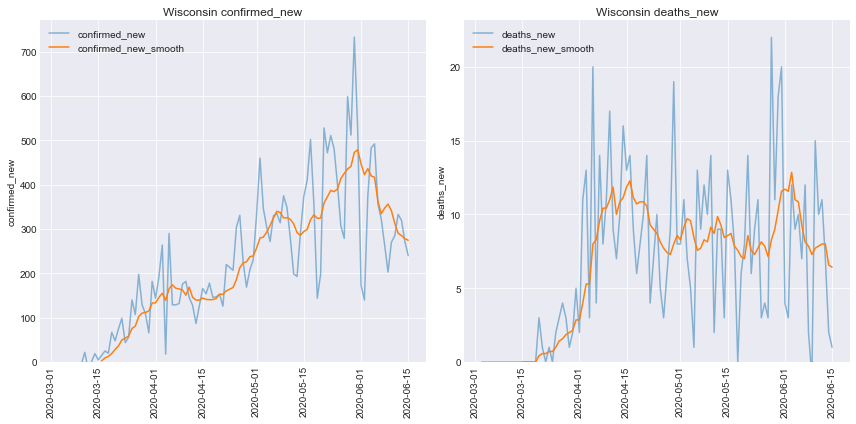

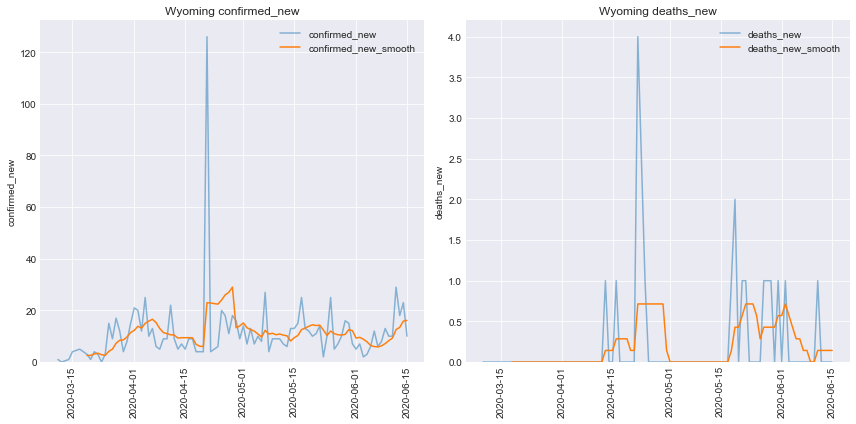

In [752]:
def plot_smoothed_trend(dfp_us_g, states, cols_plot=['confirmed_new'], dt_start=datetime.datetime(2020,3,1)):
    
    for state in states:
        i = 1
        for col_plot in cols_plot:
            plt.subplot(1,len(cols_plot),i)
            col_plot_smooth = f'{col_plot}_smooth'
            dfp_plot = dfp_us_g[(dfp_us_g['state'] == state) & (dfp_us_g['date'] >= dt_start)]
            plt.plot(dfp_plot['date'], dfp_plot[col_plot], alpha=0.5, label=col_plot)
            plt.plot(dfp_plot['date'], dfp_plot[col_plot_smooth], label=col_plot_smooth)
            plt.legend(loc='best')
            plt.xticks(rotation=90)
            plt.ylabel(col_plot)
            plt.title(f'{state} {col_plot}')
            plt.ylim(ymin=0)
            i += 1
        plt.tight_layout()
        plt.show()
    return None

#plot_smoothed_trend(dfp_us_g, ['Washington', 'Ohio', 'California', 'Texas', 'Minnesota', 'Wisconsin'], cols_plot=['confirmed_new', 'deaths_new'])

plot_smoothed_trend(dfp_us_g, states_minimum_thresh, cols_plot=['confirmed_new', 'deaths_new'])

### All states sorted by new deaths DESC

In [753]:
dfp_us_frac_new_increase = (dfp_us_recent_1[['state', 'frac_increase_deaths', 'frac_increase_confirmed']].
                             drop_duplicates().
                             sort_values(by='frac_increase_deaths', ascending=0).
                             reset_index(drop=True)
                            )
dfp_us_frac_new_increase

state  frac_increase_deaths  frac_increase_confirmed
0                   Arkansas              0.024262                 0.053761
1                  Tennessee              0.022354                 0.020444
2                     Kansas              0.021535                -0.011526
3                    Arizona              0.018542                 0.080728
4                    Alabama              0.011966                 0.010539
5                     Oregon              0.009086                 0.068324
6             South Carolina              0.008934                 0.065943
7                   Nebraska              0.007882                -0.030839
8                 California              0.005585                 0.017789
9               North Dakota              0.003145                -0.010946
10                   Florida              0.003110                 0.043890
11                   Georgia              0.002400                 0.007830
12                     Maine              0.001197                -0.021832
13  Northern Mariana Islands              0.000936                 0.000000
14             New Hampshire              0.000001                -0.027072
15                   Vermont              0.000000                 0.094175
16            Virgin Islands              0.000000                 0.000000
17                    Alaska              0.000000                 0.118036
18                 Recovered              0.000000                 0.000000
19                   Montana              0.000000                 0.047179
20                   Wyoming              0.000000                 0.004543
21                     Idaho              0.000000                 0.022490
22          Diamond Princess              0.000000                 0.000000
23            Grand Princess              0.000000                 0.000000
24                      Guam              0.000000                -0.007698
25                    Hawaii              0.000000                 0.055536
26               Puerto Rico             -0.000261                 0.038869
27                  Kentucky             -0.000291                 0.023887
28             West Virginia             -0.000475                -0.053509
29              South Dakota             -0.000843                -0.011493
30                      Utah             -0.001106                 0.049097
31                  Missouri             -0.001682                 0.004226
32                     Texas             -0.004302                 0.034360
33                 Minnesota             -0.006396                -0.033124
34                Washington             -0.010038                 0.017646
35                  Delaware             -0.010500                -0.058996
36                    Nevada             -0.010585                 0.031541
37                 Louisiana             -0.012111                 0.011763
38                  Michigan             -0.012583                 0.017900
39                New Mexico             -0.013901                 0.004553
40                New Jersey             -0.014375                -0.048469
41                 Wisconsin             -0.015015                -0.026351
42                  Illinois             -0.015643                -0.056245
43                   Indiana             -0.016454                -0.015042
44            North Carolina             -0.017397                 0.030442
45                  Maryland             -0.018876                -0.029586
46               Mississippi             -0.020319                 0.000072
47                  Colorado             -0.027446                -0.031387
48                      Ohio             -0.027975                -0.022923
49      District of Columbia             -0.029194                -0.033436
50                  New York             -0.031221                -0.039375
51             Massachusetts             -0.033787                -0.04

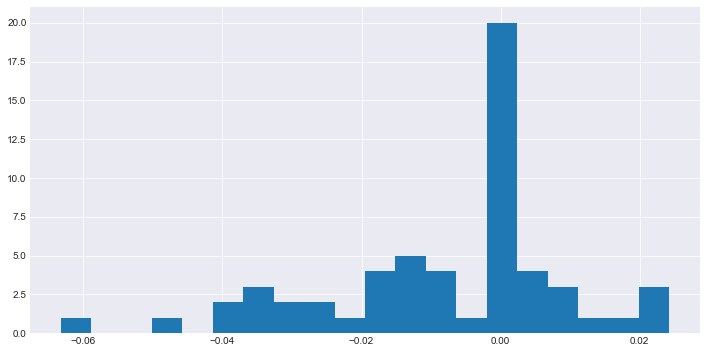

In [754]:
dfp_us_frac_new_increase.frac_increase_deaths.hist(bins=20)

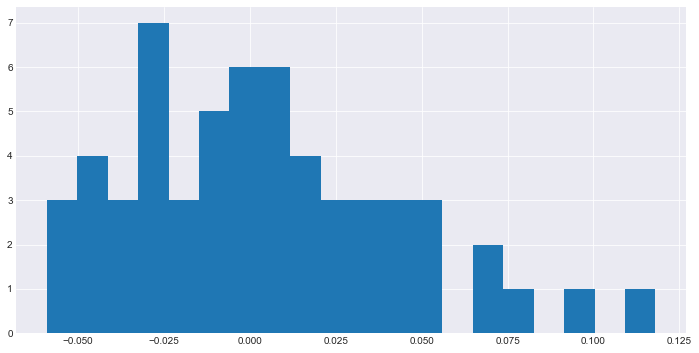

In [755]:
dfp_us_frac_new_increase.frac_increase_confirmed.hist(bins=20)

### Which states are increasing in new deaths <u>most</u> quickly?

In [756]:
dfp_us_frac_new_increase = (dfp_us_recent_1[['state', 'frac_increase_deaths', 'frac_increase_confirmed']].
                             drop_duplicates().
                             sort_values(by='frac_increase_deaths', ascending=0).
                             reset_index(drop=True)
                            )
dfp_us_frac_new_increase.head(10)

state  frac_increase_deaths  frac_increase_confirmed
0        Arkansas              0.024262                 0.053761
1       Tennessee              0.022354                 0.020444
2          Kansas              0.021535                -0.011526
3         Arizona              0.018542                 0.080728
4         Alabama              0.011966                 0.010539
5          Oregon              0.009086                 0.068324
6  South Carolina              0.008934                 0.065943
7        Nebraska              0.007882                -0.030839
8      California              0.005585                 0.017789
9    North Dakota              0.003145                -0.010946

### Which states are increasing in new deaths <u>least</u> quickly?

In [757]:
dfp_us_frac_new_increase.tail(10)

state  frac_increase_deaths  frac_increase_confirmed
48                  Ohio             -0.027975                -0.022923
49  District of Columbia             -0.029194                -0.033436
50              New York             -0.031221                -0.039375
51         Massachusetts             -0.033787                -0.047834
52          Pennsylvania             -0.035251                -0.024872
53          Rhode Island             -0.036495                -0.044993
54              Oklahoma             -0.038014                 0.024876
55                  Iowa             -0.039595                -0.006935
56           Connecticut             -0.048416                -0.042350
57              Virginia             -0.063268                -0.029153

### Is there a day-of-the-week effect on new deaths?

In [758]:
dfp_us_recent_1['dow'] = dfp_us_recent_1['date'].apply(lambda x: x.weekday())
dfp_us_dow = dfp_us_recent_1.dropna(subset={'deaths_new'}).copy()

In [759]:
deaths_new_col, death_pred_col = 'deaths_new', 'deaths_new_smooth_pred'
confirmed_new_col, confirmed_pred_col = 'confirmed_new', 'confirmed_new_smooth_pred'
dfp_us_dow['death_delta'] = dfp_us_dow[deaths_new_col]- dfp_us_dow[death_pred_col]
dfp_us_dow['death_rel_delta'] = (dfp_us_dow['death_delta']) / dfp_us_dow[death_pred_col]

dfp_us_dow['confirmed_delta'] = dfp_us_dow[confirmed_new_col]- dfp_us_dow[confirmed_pred_col]
dfp_us_dow['confirmed_rel_delta'] = dfp_us_dow['confirmed_delta'] / dfp_us_dow[confirmed_pred_col]
dfp_us_dow_deltas = (dfp_us_dow.groupby(['state', 'dow'], as_index=False).
                     agg({'death_delta': np.mean, 
                          'death_rel_delta': np.mean, # np.median
                          deaths_new_col: np.mean, 
                          death_pred_col: np.mean, 
                          'confirmed_delta': np.mean, 
                          'confirmed_rel_delta': np.mean}) # np.median
                    )

In [760]:
dfp_us_dow_deltas[dfp_us_dow_deltas.state == 'Washington']

state  dow  death_delta  death_rel_delta  deaths_new  \
378  Washington    0    -3.666667        -0.555556    2.666667   
379  Washington    1    -0.666667        -0.111111    6.000000   
380  Washington    2     3.000000         0.500000    9.666667   
381  Washington    3     1.000000         0.095238    7.666667   
382  Washington    4     4.000000         0.666667   10.666667   
383  Washington    5     2.000000         0.317460    8.666667   
384  Washington    6     0.333333         0.055556    6.666667   

     deaths_new_smooth_pred  confirmed_delta  confirmed_rel_delta  
378                6.333333        25.666667             0.109022  
379                6.666667        16.666667             0.063318  
380                6.666667       -59.333333            -0.249054  
381                6.666667       -83.333333            -0.271077  
382                6.666667        70.666667             0.263619  
383                6.666667        44.333333             0.159549  
384                6.333333        83.000000             0.294089

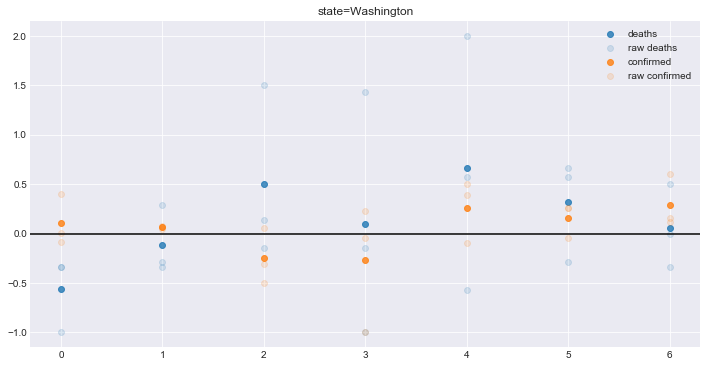

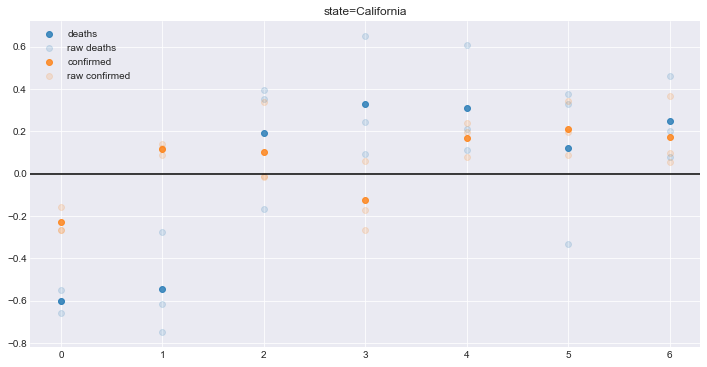

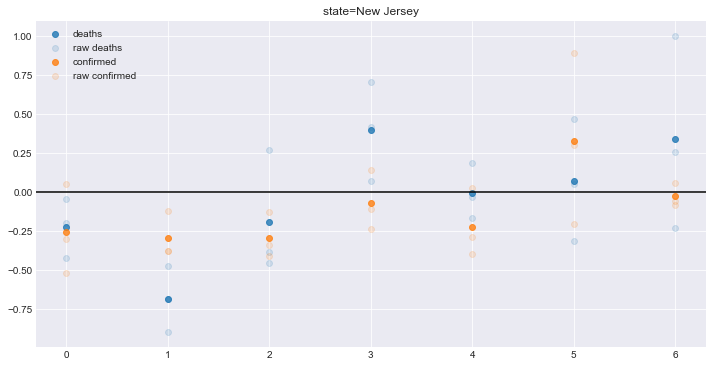

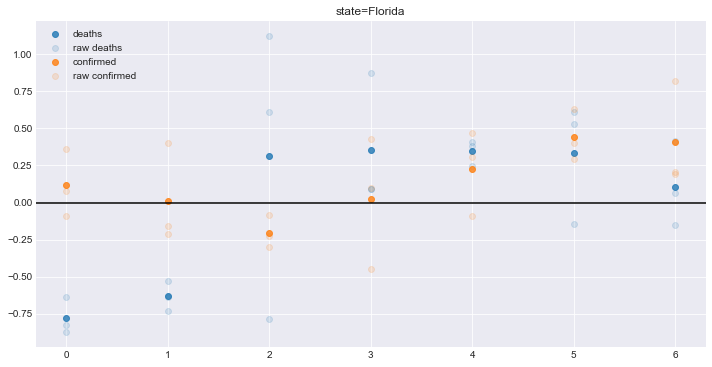

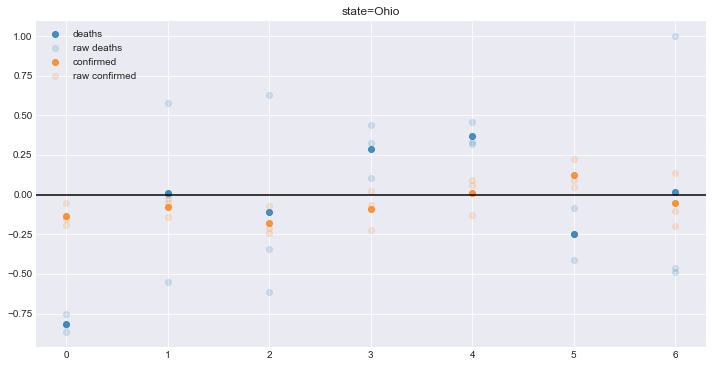

In [761]:
alpha_soft = 0.15
alpha_hard = 0.8
for state in ['Washington', 'California', 'New Jersey', 'Florida', 'Ohio']:
    dfp_plot = dfp_us_dow_deltas[(dfp_us_dow_deltas.state == state)]  #(dfp_us_dow_deltas.deaths_new >= 10) & 
    dfp_plot_raw = dfp_us_dow[dfp_us_dow.state == state]
    
    p = plt.plot(dfp_plot['dow'], dfp_plot['death_rel_delta'], 'o', alpha=alpha_hard, label='deaths')
    color = p[0].get_color()
    plt.plot(dfp_plot_raw['dow'], dfp_plot_raw['death_rel_delta'], 'o', alpha=alpha_soft, label='raw deaths', color=color)
    
    q = plt.plot(dfp_plot['dow'], dfp_plot['confirmed_rel_delta'], 'o', alpha=alpha_hard, label='confirmed')
    color = q[0].get_color()
    plt.plot(dfp_plot_raw['dow'], dfp_plot_raw['confirmed_rel_delta'], 'o', alpha=alpha_soft, label='raw confirmed', color=color)
    
    plt.legend(loc='best')
    plt.axhline(0, color='k')
    plt.title(f'state={state}')

    #plt.ylim([-0.5,0.5])
    #plt.ylim([-2,2])
    plt.show()